Import Libraries and load in data:

In [1]:
from legend_plot_style import LEGENDPlotStyle as lps
lps.use("legend_talks")
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import math
from collections import Counter
from scipy.interpolate import interp1d

file_path = '/home/eric/sim/WWLegend/Archive/Neutrontaggerruns/'
""" Amount is required to know how many entries belong to each neutron. 
    nPMMA is an array where each entry says how many photon timestamp belong to that neutron.
    Time for the time entries. Each entry is one photon timestamp.
    no is required to match Shower IDs, Identifier for something else.
    Read in 2 different setups to compare!"""
nPMMA = np.loadtxt(file_path + "Warwick with ArgonModerator/LoadedScintillator/LoadedScintWithPMTQEAmount.csv", dtype=float, delimiter=',', skiprows=5, unpack=True) #first name
timePMMA,WavelengthsPMMA = np.loadtxt(file_path + "Warwick with ArgonModerator/LoadedScintillator/LoadedScintWithPMTQETimes.csv", dtype=float, skiprows=5, delimiter=',', unpack=True)

nPMMAFoil = np.loadtxt(file_path + "Warwick with ArgonModerator/Baseline/BaselineWithPMTQEAmount.csv", dtype=float, delimiter=',', skiprows=5, unpack=True) #second name
timePMMAFoil, WavelengthsPMMAFoil = np.loadtxt(file_path + "Warwick with ArgonModerator/Baseline/BaselineWithPMTQETimes.csv", dtype=float, skiprows=5, delimiter=',', unpack=True)

nPMMA_Allmuons = np.loadtxt(file_path + "Warwick without ArgonModerator all events/Foil Behind PMMA/PMMAAmount.txt", dtype=float, delimiter=',', skiprows=5, unpack=True) #All muons for deadtime
timePMMA_Allmuons = np.loadtxt(file_path + "Warwick without ArgonModerator all events/Foil Behind PMMA/PMMATimes.txt", dtype=float, skiprows=5, delimiter=',', unpack=True)

""" no carries the id to which shower each neutron belongs. """
no, x, y, z, ekin, NeutronCaptureTimeDelay = np.loadtxt(file_path + "Warwick with ArgonModerator/ShowerIDs2.txt", dtype=float, delimiter=',', unpack=True) #first name
identifierPMMA, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick with ArgonModerator/PMMARun2.txt", dtype=float, delimiter=',', unpack=True)

no2, x2, y2, z2, ekin2, NeutronCaptureTimeDelay2 = np.loadtxt(file_path + "Warwick with ArgonModerator/ShowerIDs2.txt", dtype=float, delimiter=',', unpack=True) 
identifierPMMA2, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick with ArgonModerator/PMMARun2.txt", dtype=float, delimiter=',', unpack=True) #second name

no_All, x_All, y_All, z_All, ekin_All, NeutronCaptureTimeDelay_All = np.loadtxt(file_path + "Warwick without ArgonModerator all events/ShowerIDs.txt", dtype=float, delimiter=',', skiprows=1, unpack=True) 
identifierPMMA_All, useless, session, session2, bruh, bruh2 = np.loadtxt(file_path + "Warwick without ArgonModerator all events/PMMARun.txt", dtype=float, delimiter=',', unpack=True) #All muons for deadtime

name1= "Loaded Scint"  # belongs to "first" read in setup
name2 = "Baseline" # belongs to "second" read in setup

Functions For the SHOWERS plot

In [2]:
def subarray_it_up(n, time, id):
    """ Takes array of number of timestamps per neutron, the timestamps 
        and the array of ids of the corresponding Shower of the neutron. 
        Returns Array where each subarray corresponds to all 
        Timestamps of one Shower. Size should be amount of Showers."""
    unique, counts = np.unique(id, return_counts=True)
    cum_counts = np.cumsum(counts)
    cum_counts = cum_counts.astype(int)
    cum_n = np.cumsum(n)
    cum_n = cum_n.astype(int)
    subarrays = [time[0 if i == 0 else cum_n[(cum_counts[i-1]) - 1]:cum_n[(cum_counts[i])-1]] for i in range(len(counts))]
    return subarrays

def mult_to_phot(mult, Npmt):
    """ Uses surface of Hit area and single PMT area (hardcoded).
        Takes the given multiplicity of PMTs + deployed amount of PMTs.
        Returns how many photon hits are required to fullfill multiplicity
        assuming isotropic hit location. ADJUSTED TO ASSUME PMT QE WAS ALREADY APPLIED"""
    F = 467
    Fpmt = 0.05
    return (mult * F /( Npmt * Fpmt))

def histlist(AllShowers, window, timeMax):
    """ Takes whole Shower array and divides each Shower 
        in time windows of size "window" up to timeMax.
        Returns Array with histogram for each Shower
        with window/timeMax bins and max range timeMax."""
    b = int(timeMax/window)
    hists_list = []
    for Shower in AllShowers:
        x, y = np.histogram(Shower, bins=b, range=(0, timeMax))
        hists_list.append(x)
    hists_array = np.array(hists_list)
    return hists_array

def bins_over_thresh(arr, threshold):
    """ Takes single array and a threshold.
        Returns how many entries are above threshold"""
    res = np.sum(arr > threshold)
    return res

def distinguished_neutrons(AllShowers, mult, Npmt, window, timeMax):
    """ Takes whole Shower array, a given multiplicity, 
        given Amount of PMTs, size of coincidence intervall
        (in ns) and maximum time delay (in ns).
        Returns an array where each entry is the amount of neutrons
        of that Shower that would be detected with these 4 conditions.
    """
    hists_array = histlist(AllShowers, window,timeMax)
    threshold = mult_to_phot(mult, Npmt)
    results_array = np.array([])
    for i in hists_array:
        results_array = np.append(results_array, bins_over_thresh(i, threshold))
    return results_array

def random_rate(mult, Npmt, window, timeMax):
    """ Calculates the random rate of PMTs from the
        required multiplicity threshold, Amount of PMTs,
        coincidence Intervall and maximum time delay after
        muon. The darkrate is hardcoded (default 5000 Hz)."""
    log_numer = math.log(np.math.factorial(Npmt)) # Have to use logs as numbers get way too large
    log_denom = math.log(np.math.factorial(mult))
    log_denom2 = math.log(np.math.factorial(Npmt-mult))
    D = 5000 # random rate 5000 hz
    rate = np.exp(log_numer - log_denom - log_denom2 + mult * math.log(D) + (mult - 1) * math.log(window * 10**-9)) # in Hz
    randoms = rate * timeMax * 10**-9 # timeMax in nanoseconds
    return randoms

#Returns how many showers have seen more than x neutrons.
def more_than_x_Neutrons(neutrons, x):
    """ Takes array "neutrons" and threshold x.
        Returns the percentage of entries that
        are above threshold."""
    size = np.size(neutrons)
    return (np.sum(neutrons >= x) / size)

#Returns the entire Array for all multiplicitys
def more_than_x_Array(AllShowers, x, multiplicitys, Npmts = 500):
    """ Takes whole Shower array, neutron threshold x and array of multiplicities.
        Returns an array that has an entry for each multiplicity giving the percentage
        of Showers that would be detected with given multiplicity and neutron threshold.
        Other Parameters (Amount of PMTs, coincidence intervall, max time delay) are 
        hardcoded."""
    results_array = np.array([])
    for i in multiplicitys:
        neutrons = distinguished_neutrons(AllShowers=AllShowers,mult=i, Npmt=Npmts, window=200, timeMax=200000)
        results_array = np.append(results_array, more_than_x_Neutrons(neutrons,x))
    return results_array

def random_rates_array(multiplicitys):
    """ Takes an array of multiplicites.
        Returns array with statistical PMT
        random rate per multiplicity."""
    results_array = np.array([])
    for i in multiplicitys:
        i = i.astype(int)
        rr = random_rate(mult=i, Npmt=500, window=200, timeMax=200000)
        results_array = np.append(results_array, rr)
    return results_array


Functions for the "Photons hitting sensitive wall area per Ncapture" plot

In [3]:
def Photons_in_intervall(n,times,startTime,endTime):
    """ Takes the array of photons per Ncapture and counts only those within the time intervall.
    Returns array of photons within intervall per Ncapture. """
    cum_index = np.cumsum(n)
    cum_index = cum_index.astype(int)
    # Insert 0 as the first starting index
    start_indexes = np.insert(cum_index[:-1], 0, 0)
    end_indexes = cum_index

    # Initialize an array to store the counts
    counts = np.zeros(len(start_indexes), dtype=int)

    for i, (start, end) in enumerate(zip(start_indexes, end_indexes)):
        # Get the times within the interval
        times_within_interval = times[start:end]
        # Count the values in the time interval
        counts[i] = np.sum((times_within_interval > startTime) & (times_within_interval < endTime))
    return counts

def Photons_in_intervall_and_200ns(n,times,startTime,endTime):
    """ Takes the array of photons per Ncapture and counts only those within the time intervall + only those that are within 200ns of the first.
    Returns array of photons within intervall per Ncapture. """
    cum_index = np.cumsum(n)
    cum_index = cum_index.astype(int)
    # Insert 0 as the first starting index
    start_indexes = np.insert(cum_index[:-1], 0, 0)
    end_indexes = cum_index

    # Initialize an array to store the counts
    counts = np.zeros(len(start_indexes), dtype=int)

    for i, (start, end) in enumerate(zip(start_indexes, end_indexes)):
        # Get the times within the interval
        times_within_interval = times[start:end]
        if len(times_within_interval) > 0:
            first = np.min(times_within_interval)
            # Count the values in the time interval
            counts[i] = np.sum(((times_within_interval > startTime) & (times_within_interval < endTime)) & (times_within_interval < (first + 200)))
    return counts

Functions for the derived % of Neutroncapture detected vs p.e. plot

In [4]:
def PE_per_Ncapture(n,PE,NPMTs, size):
    """Takes the array of Photons per NCapture, the x-axis array of PEs and the amount of PMTs.
        Returns the percentage of NCaptures detected for the given PEs and the coverage."""
    results_array = np.array([])
    for i in PE:
        Photonthreshold = mult_to_phot(i,NPMTs)
        num = np.sum(n > Photonthreshold)
        Percentage = num / size
        results_array= np.append(results_array, Percentage)
    return results_array

Functions for the derived % of Neutroncapture detected vs p.e. plot for only captures in Water!

In [5]:
def remove_nonWater_captures(n,identifier):
    """Takes the array of Photonhits per NC and removes all captures that were not in the water
        according to the identiefier."""
    result = n[(identifier != 4)]
    return result

Functions for the Percentage of detected Neutron Showers with more than x Captures in the Water

In [6]:
def sub_neutrons(identifier, sub, id, x):
    """Like subarray_it_up but takes the neutron identifiers and returns the list reduced to showers with >x neutron captures
        Takes the identifier array, the subarray after subarray_it_up and the original shower id array and x"""
    unique, counts = np.unique(id, return_counts=True)
    cum_counts = np.cumsum(counts)
    cum_counts = cum_counts.astype(int)
    subarrays = [identifier[0 if i == 0 else cum_counts[i-1]:cum_counts[i]] for i in range(len(counts))]
    subCaptures=np.array([])

    # Now find out which of these arrays in subID has less than x neutron captures in water. (Meaning less than 50 3,1 or 0)
    for arr in subarrays:
        element_counts = Counter(arr)
        count_of_3 = element_counts[3]
        count_of_1 = element_counts[1]
        count_of_0 = element_counts[0]
        subCaptures = np.append(subCaptures, (count_of_0 + count_of_1 + count_of_3))
    subCaptures = subCaptures.astype(int)
    mask = subCaptures > x
    sub50 = [sub[i] for i in range(len(sub)) if mask[i]]
    return sub50

def average_neutrons_detected(identifier, sub, id, x, multiplicity):
    """Takes the identifer, the subarray after subarray_it_up and the original shower id array and an array of x values
        returns an array that for each x value has the average number of detected neutron captures of showers that have
        at least x captures in water, by given p.e. multiplicity"""
    results_array = np.array([])
    for i in x:
        tempArray = sub_neutrons(identifier, sub, id, i)
        neutrons = distinguished_neutrons(AllShowers=tempArray,mult=multiplicity, Npmt=500, window=200, timeMax=200000)
        averageNumber = np.mean(neutrons)
        results_array = np.append(results_array,averageNumber)
    return results_array

def average_showers_detected(identifier, sub, id, x, multiplicity, neutronThreshold, Npmts = 500):
    """Takes the identifer, the subarray after subarray_it_up and the original shower id array, array of x values, multiplicity value for the analysis cut
        and the neutronThreshold for the analysis cut
        returns an array that for each x value has the average percentage of detected showers that have
        at least x captures in water, by given p.e. multiplicity and neutronThreshold"""
    results_array = np.array([])
    for i in x:
        tempArray = sub_neutrons(identifier, sub, id, i)
        neutrons = distinguished_neutrons(AllShowers=tempArray,mult=multiplicity, Npmt=Npmts, window=200, timeMax=200000)
        detected = np.sum(neutrons > neutronThreshold)
        percentage = detected / len(tempArray)
        results_array = np.append(results_array,percentage)
    return results_array

Functions to calculate dead time using all muon events

In [7]:
def Percentage_triggered_muons(neutrons,x):
    """ Takes array "neutrons" and threshold x.
        Returns the percentage of entries that
        are above threshold in regards to a hard coded normalization."""
    size = 100000
    return (np.sum(neutrons >= x) / size)

Deadtime stuff, same as More than x array but iterates over neutron multiplicities instead of PMT multiplicity

In [8]:
def more_than_x_Array_neutrons(AllShowers, x, multiplicity):
    """ Takes whole Shower array, neutron threshold x and array of multiplicities.
        Returns an array that has an entry for each multiplicity giving the percentage
        of Showers that would be detected with given multiplicity and neutron threshold.
        Other Parameters (Amount of PMTs, coincidence intervall, max time delay) are 
        hardcoded."""
    results_array = np.array([])
    neutrons = distinguished_neutrons(AllShowers=AllShowers,mult=multiplicity, Npmt=500, window=200, timeMax=200000)
    for i in x:
        results_array = np.append(results_array, more_than_x_Neutrons(neutrons,i))
    return results_array

def more_than_x_Array_detected(AllShowers, x, multiplicity):
    
    results_array = np.array([])
    neutrons = distinguished_neutrons(AllShowers=AllShowers,mult=multiplicity, Npmt=500, window=200, timeMax=200000)
    for i in x:
        results_array = np.append(results_array, more_than_x_Neutrons(neutrons,i))
    return results_array

ABOVE: Function Area

BELOW: Computing Area

Time consuming steps for histogramm "Photons hitting sensitive wall area per Ncapture" and derived Plots:

In [9]:
Photons_inTime = Photons_in_intervall(nPMMA, timePMMA, 10000, 200000)
Photons_inTimeSetup2 = Photons_in_intervall(nPMMAFoil, timePMMAFoil, 10000, 200000)
Photons_inTime200 = Photons_in_intervall_and_200ns(nPMMA, timePMMA, 10000, 200000)
Photons_inTime200Setup2 = Photons_in_intervall_and_200ns(nPMMAFoil, timePMMAFoil, 10000, 200000)
xPEs = np.linspace(1,12,12)
Only_Water = remove_nonWater_captures(nPMMA,identifierPMMA)
Only_WaterSetup2 = remove_nonWater_captures(nPMMAFoil,identifierPMMA2)
PePerNCapture = PE_per_Ncapture(Photons_inTime200,xPEs, 500, np.size(Photons_inTime200))
PePerNCaptureSetup2 = PE_per_Ncapture(Photons_inTime200Setup2,xPEs, 500, np.size(Photons_inTime200Setup2))



PePerNCaptureWater = PE_per_Ncapture(Photons_inTime200,xPEs, 500, np.size(Only_Water))
PePerNCaptureWater_250PMTs = PE_per_Ncapture(Photons_inTime200,xPEs, 250, np.size(Only_Water))
PePerNCaptureWater_200PMTs = PE_per_Ncapture(Photons_inTime200,xPEs, 200, np.size(Only_Water))
PePerNCaptureWater_150PMTs = PE_per_Ncapture(Photons_inTime200,xPEs, 200, np.size(Only_Water))
PePerNCaptureWaterSetup2 = PE_per_Ncapture(Photons_inTime200Setup2,xPEs, 500, np.size(Only_WaterSetup2))

Here do all the time consuming steps and calculations etc for Shower Plot

In [10]:
multiplicitys = np.linspace(2,10,9)
subPMMA = subarray_it_up(nPMMA, timePMMA, no)
subPMMASetup2 = subarray_it_up(nPMMAFoil, timePMMAFoil, no2)
subPMMADeadtime = subarray_it_up(nPMMA_Allmuons, timePMMA_Allmuons, no_All)
print(len(subPMMA))
print(len(subPMMASetup2))

PMMA1 = more_than_x_Array(AllShowers = subPMMA,x=15, multiplicitys = multiplicitys)
PMMA1_250PMTs = more_than_x_Array(AllShowers = subPMMA,x=15, multiplicitys = multiplicitys, Npmts=250)
PMMA1_200PMTs = more_than_x_Array(AllShowers = subPMMA,x=15, multiplicitys = multiplicitys, Npmts=200)
PMMA1_150PMTs = more_than_x_Array(AllShowers = subPMMA,x=15, multiplicitys = multiplicitys, Npmts=150)
PMMA1Setup2 = more_than_x_Array(AllShowers = subPMMASetup2,x=15, multiplicitys = multiplicitys)

209
209


Time consuming steps for more than x neutrons plot

In [11]:
subPMMA50 = sub_neutrons(identifierPMMA, subPMMA, no, 50)
subPMMA50Setup2 = sub_neutrons(identifierPMMA2, subPMMASetup2, no2, 50)
print(len(subPMMA50))

PMMA1_morethan50 = more_than_x_Array(AllShowers=  subPMMA50,x=15, multiplicitys = multiplicitys)


PMMA1_morethan50Setup2 = more_than_x_Array(AllShowers=  subPMMA50Setup2,x=15, multiplicitys = multiplicitys)


neutrons_per_shower = np.linspace(2,51,50)
detected_on_average = average_neutrons_detected(identifierPMMA, subPMMA, no, neutrons_per_shower, 6)
detected_on_averageSetup2 = average_neutrons_detected(identifierPMMA2, subPMMASetup2, no2, neutrons_per_shower, 6)
Showers_detected = average_showers_detected(identifierPMMA, subPMMA, no, neutrons_per_shower, 6, 15)
Showers_detected_50PMTs = average_showers_detected(identifierPMMA, subPMMA, no, neutrons_per_shower, 6, 15, Npmts=50)
Showers_detected_100PMTs = average_showers_detected(identifierPMMA, subPMMA, no, neutrons_per_shower, 6, 15, Npmts=100)
Showers_detected_150PMTs = average_showers_detected(identifierPMMA, subPMMA, no, neutrons_per_shower, 6, 15, Npmts=150)
Showers_detected_200PMTs = average_showers_detected(identifierPMMA, subPMMA, no, neutrons_per_shower, 6, 15, Npmts=200)
Showers_detected_250PMTs = average_showers_detected(identifierPMMA, subPMMA, no, neutrons_per_shower, 6, 15, Npmts=250)
Showers_detectedSetup2 = average_showers_detected(identifierPMMA2, subPMMASetup2, no2, neutrons_per_shower, 6, 15)

76


Time consuming stuff for Deadtime

In [12]:
# PMMADeadtime_firstPlot_7 = more_than_x_Array(AllShowers = subPMMADeadtime,x=7, multiplicitys = multiplicitys)
# PMMADeadtime_firstPlot_5 = more_than_x_Array(AllShowers = subPMMADeadtime,x=5, multiplicitys = multiplicitys)
# PMMADeadtime_firstPlot_10 = more_than_x_Array(AllShowers = subPMMADeadtime,x=10, multiplicitys = multiplicitys)
# PMMADeadtime_firstPlot_15 = more_than_x_Array(AllShowers = subPMMADeadtime,x=15, multiplicitys = multiplicitys)

# PMMA15_morethan50 = more_than_x_Array(AllShowers = subPMMA50, x=15, multiplicitys = multiplicitys)
# PMMA5_morethan50 = more_than_x_Array(AllShowers = subPMMA50, x=5, multiplicitys = multiplicitys)
# PMMA7_morethan50 = more_than_x_Array(AllShowers = subPMMA50, x=7, multiplicitys = multiplicitys)

# Neutron_x = np.linspace(1,30,30)
# PMMADeadtime = more_than_x_Array_neutrons(AllShowers=subPMMADeadtime, x = Neutron_x, multiplicity=6)
# PMMADetected6 = more_than_x_Array_detected(AllShowers=subPMMA, x = Neutron_x, multiplicity= 6)
# PMMADetected650 = more_than_x_Array_detected(AllShowers=subPMMA50, x = Neutron_x, multiplicity= 6)
# PMMADeadtime5 = more_than_x_Array_neutrons(AllShowers=subPMMADeadtime, x = Neutron_x, multiplicity=5)
# PMMADetected5 = more_than_x_Array_detected(AllShowers=subPMMA, x = Neutron_x, multiplicity= 5)
# PMMADetected550 = more_than_x_Array_detected(AllShowers=subPMMA50, x = Neutron_x, multiplicity= 5)
# PMMADeadtime7 = more_than_x_Array_neutrons(AllShowers=subPMMADeadtime, x = Neutron_x, multiplicity=7)
# PMMADetected7 = more_than_x_Array_detected(AllShowers=subPMMA, x = Neutron_x, multiplicity= 7)
# PMMADetected750 = more_than_x_Array_detected(AllShowers=subPMMA50, x = Neutron_x, multiplicity= 7)
# PMMADeadtime8 = more_than_x_Array_neutrons(AllShowers=subPMMADeadtime, x = Neutron_x, multiplicity=8)
# PMMADetected8 = more_than_x_Array_detected(AllShowers=subPMMA, x = Neutron_x, multiplicity= 8)
# PMMADetected850 = more_than_x_Array_detected(AllShowers=subPMMA50, x = Neutron_x, multiplicity= 8)

Code for time distribution of a single neutron

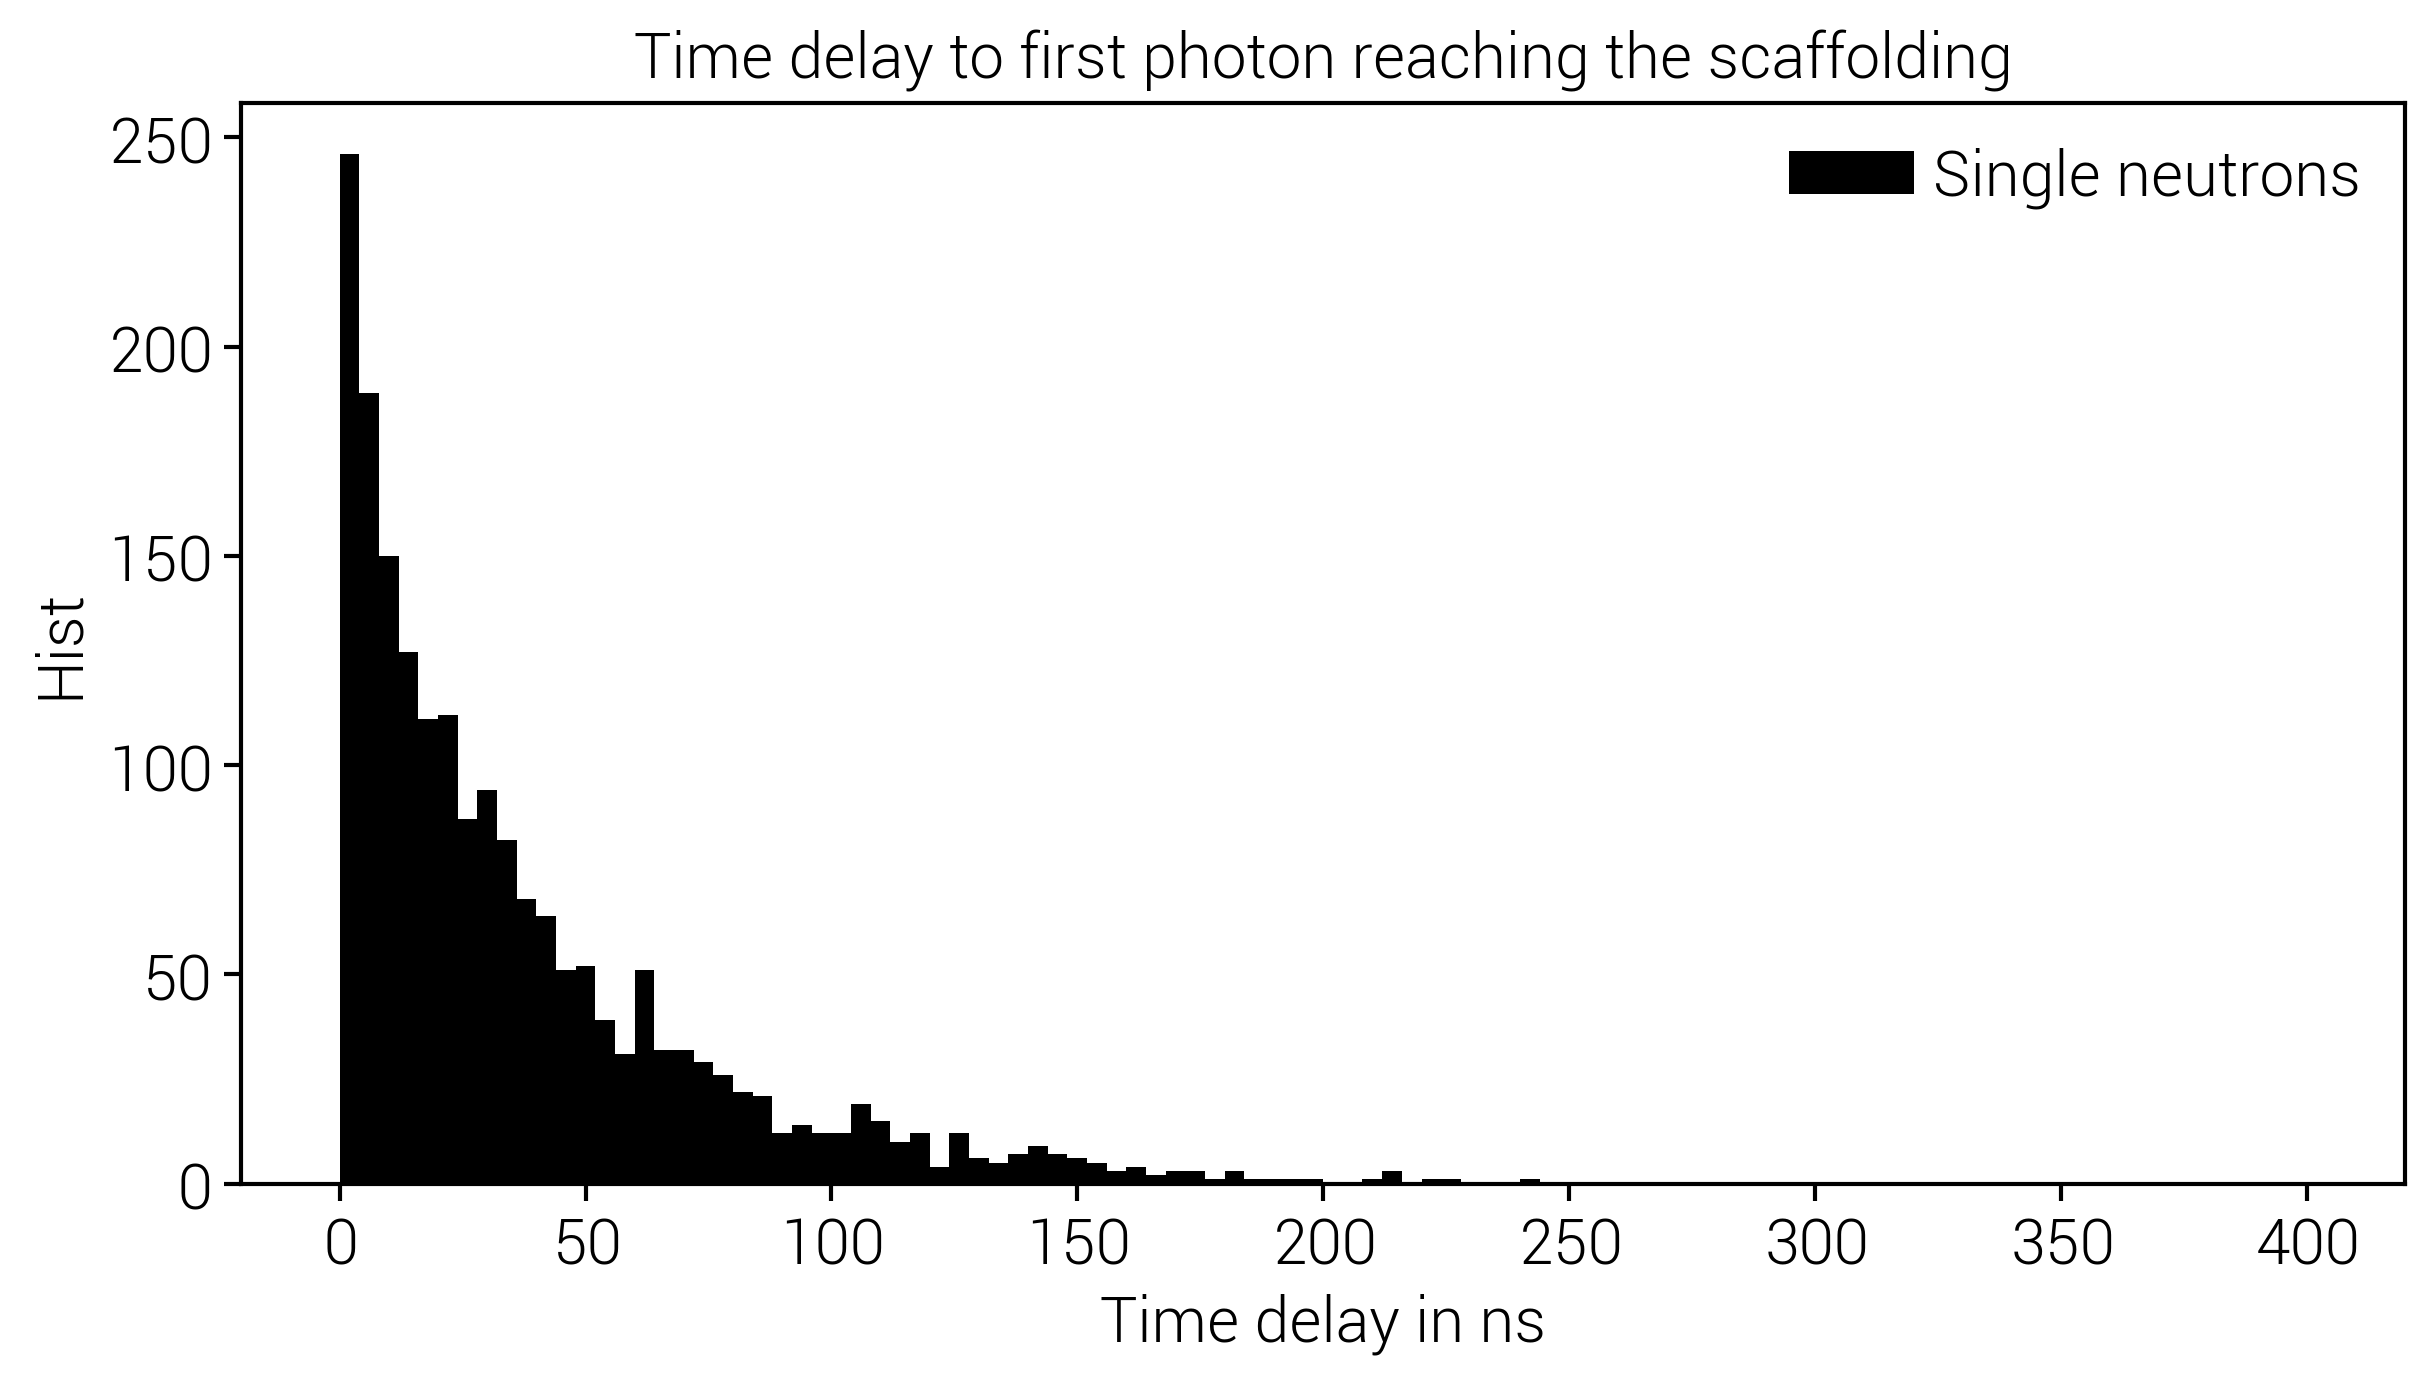

In [13]:
n_as_int = nPMMA.astype(int)


cumulative_sum = np.cumsum(n_as_int)

subarrays = [timePMMA[0 if i == 0 else cumulative_sum[i - 1]:cumulative_sum[i]] for i in range(len(n_as_int))]

Phtons = subarrays[3] - np.min(subarrays[3])


fig, ax = plt.subplots()

ax.hist(Phtons, bins = 100, range= (0,400), label= "Single neutrons")



ax.set_xlabel('Time delay in ns')
ax.set_ylabel('Hist')
ax.set_title('Time delay to first photon reaching the scaffolding')
ax.legend(loc= "upper right")
#ax.grid()


plt.show()

Time distribution of an Event

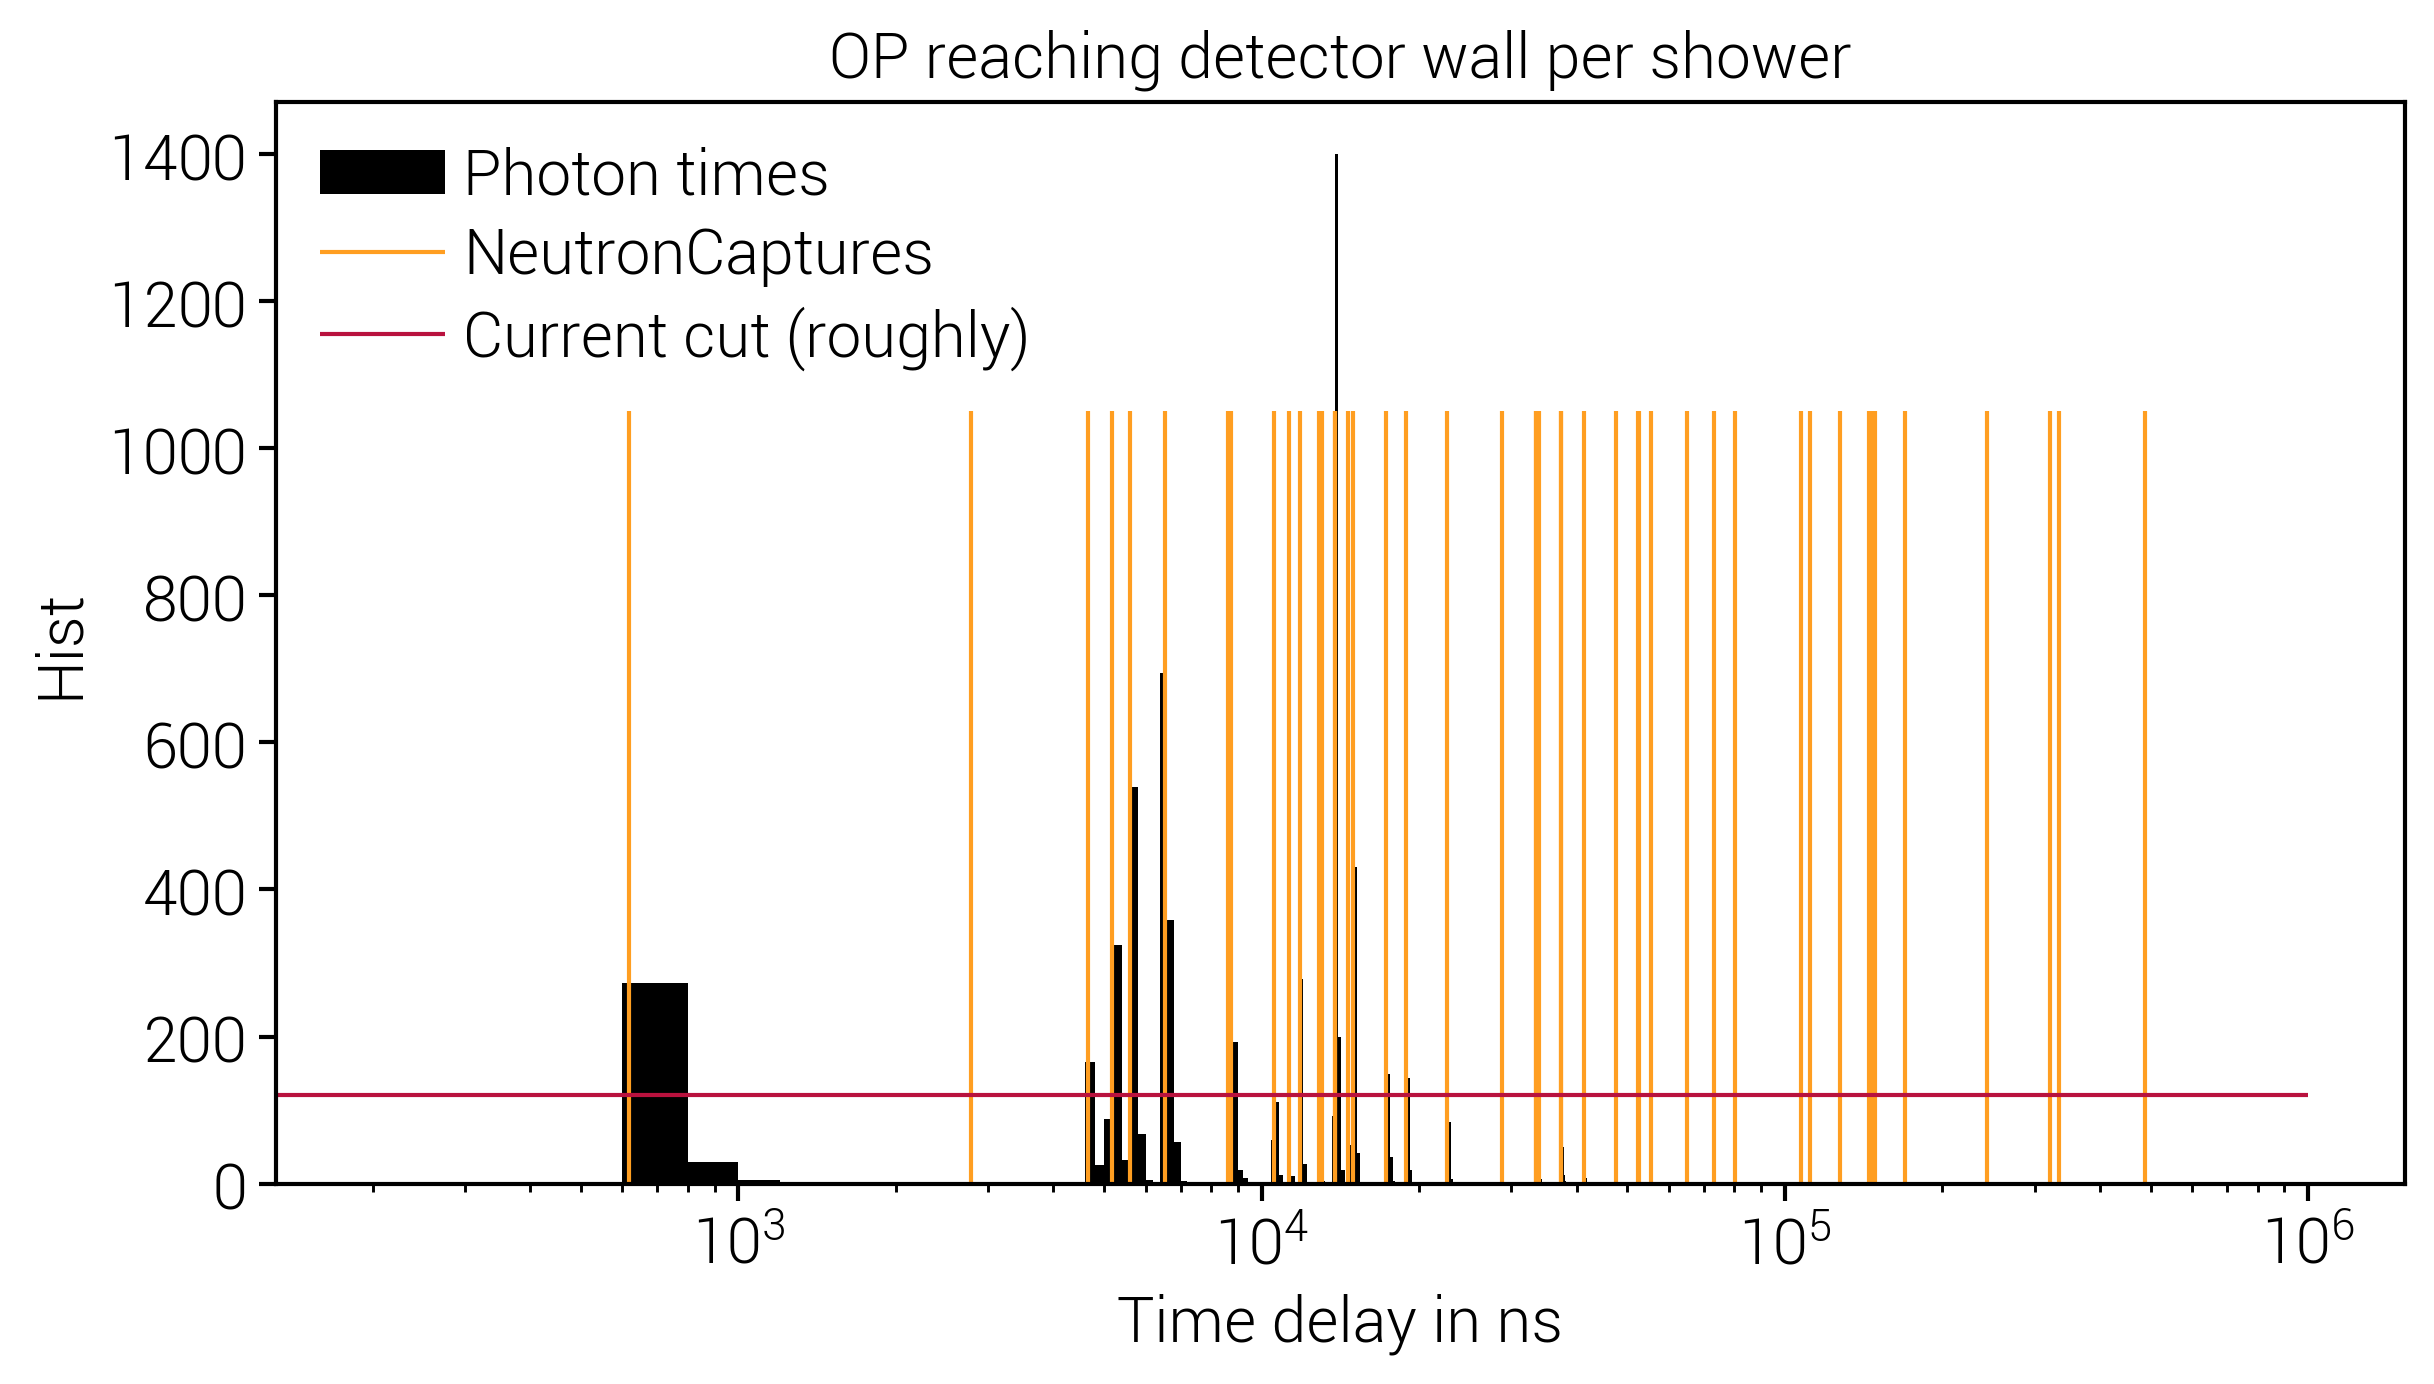

In [14]:
ShowerNumber = 5
Neutrontimes = NeutronCaptureTimeDelay[(no == ShowerNumber) & (identifierPMMA != 4)]


fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(subPMMASetup2[ShowerNumber], bins = 5000, range = (0, 1000000), label= "Photon times")

ax1.set_xlabel('Time delay in ns')
ax1.set_ylabel('Hist')
ax1.set_title('OP reaching detector wall per shower')
ax1.set_xscale('log')
#ax1.set_ylim(bottom=0, top=1000)
ax1.vlines(Neutrontimes, ymin=0,ymax=np.max(n)*0.75, color=lps.colors["legend_orange"], label = "NeutronCaptures")
ax1.hlines(y=120,xmin=0, xmax=1000000, color = lps.colors["red"], label="Current cut (roughly)")
ax1.legend(loc= "upper left")
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/Scintillator/EventNeutronTimesScint.png")
plt.show()

Photons hitting sensitive wall area per Ncapture 

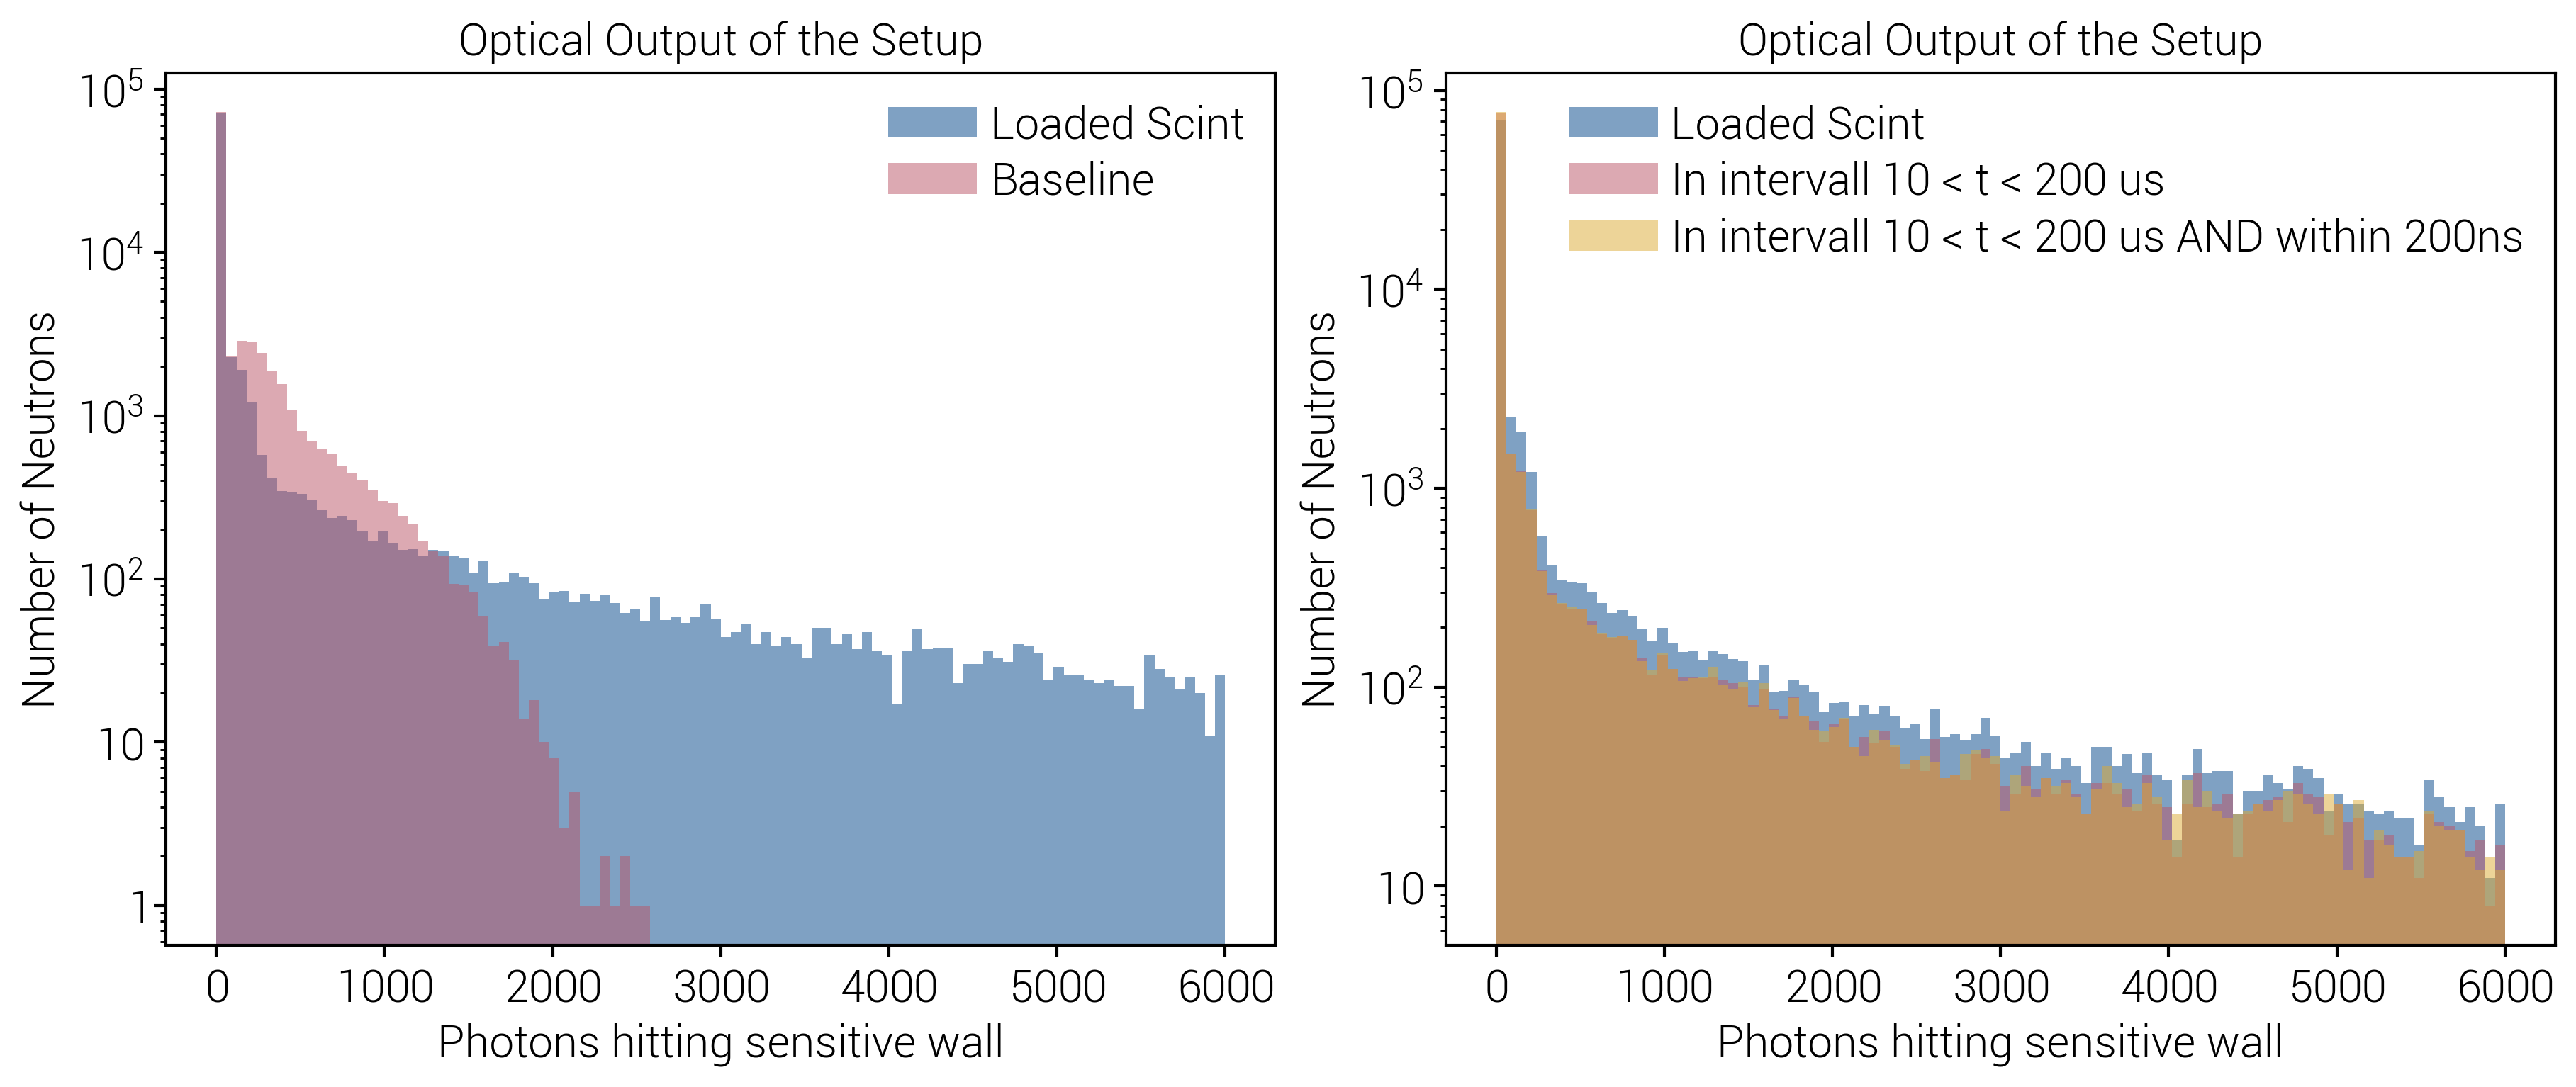

93505
93505


In [15]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 5))
n_bins = 100
binrange = (0, 6000)
ax.hist(nPMMA,bins=n_bins, range=binrange, alpha = 0.5, color = "#004488", label=name1)
ax.hist(nPMMAFoil,bins=n_bins,range=binrange, alpha = 0.5, color = "#BB5566", label=name2)

ax.set_xlabel('Photons hitting sensitive wall')
ax.set_ylabel('Number of Neutrons')
ax.set_title('Optical Output of the Setup')
ax.set_yscale("log")
#ax.grid()
ax.legend(loc='best')

ax2.hist(nPMMA,bins=n_bins, range=binrange, alpha = 0.5, color = "#004488", label=name1)
ax2.hist(Photons_inTime,bins=n_bins,range=binrange, alpha = 0.5, color = "#BB5566", label="In intervall 10 < t < 200 us")
ax2.hist(Photons_inTime200,bins=n_bins,range=binrange, alpha = 0.5, color = "#DDAA33", label="In intervall 10 < t < 200 us AND within 200ns")

ax2.set_xlabel('Photons hitting sensitive wall')
ax2.set_ylabel('Number of Neutrons')
ax2.set_title('Optical Output of the Setup')
ax2.set_yscale("log")
#ax2.grid()
ax2.legend(loc='best')
plt.tight_layout()
#plt.savefig("/home/eric/sim/WWLegend/Plots/Scintillator/PhotonsPerCapture.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()
print(np.size(nPMMA))
print(np.size(nPMMAFoil))

Derived Plot: % of Neutroncapture detected vs p.e.

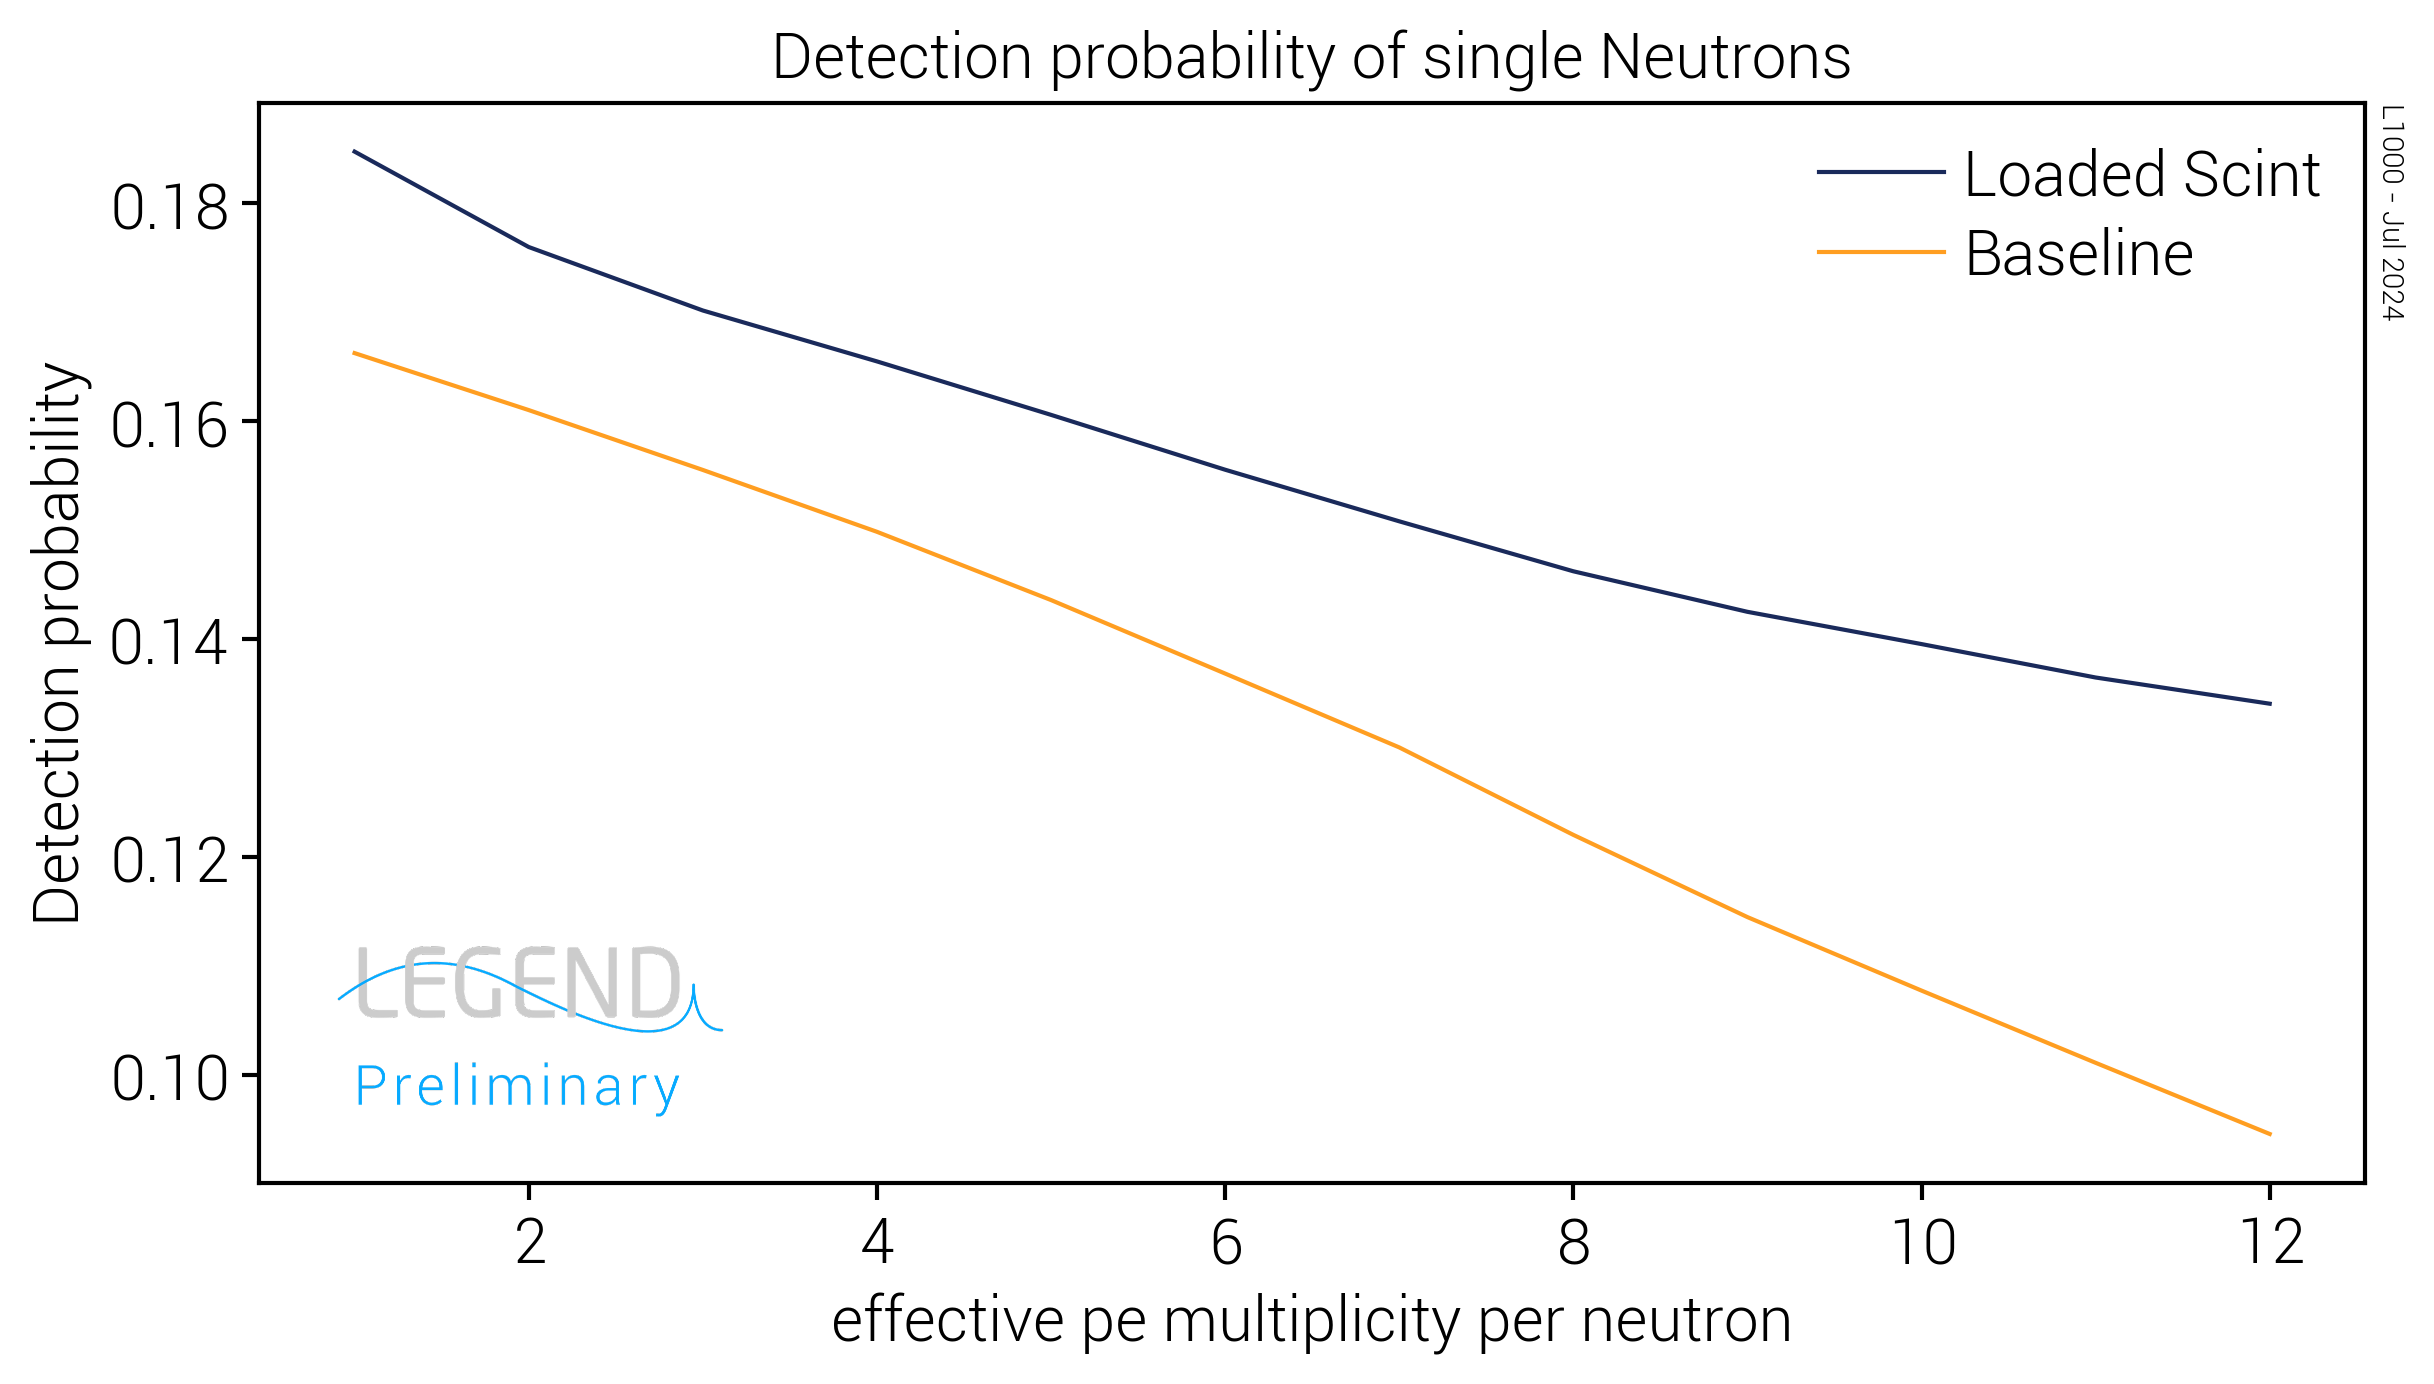

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(xPEs, PePerNCapture,  color = lps.colors["legend_darkblue"], label = name1)
ax1.plot(xPEs, PePerNCaptureSetup2,  color = lps.colors["legend_orange"], label = name2)

ax1.set_xlabel('effective pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of single Neutrons')
#ax1.grid()
ax1.legend(loc='best')
ax1.set_legend_logo(position="lower left")
ax1.set_legend_annotation()
#plt.savefig("/home/eric/sim/WWLegend/Plots/ArgonModvsWithout/SingleDetectionChance.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

Derived Plot: % of Neutroncapture detected vs p.e. Only captures in Water

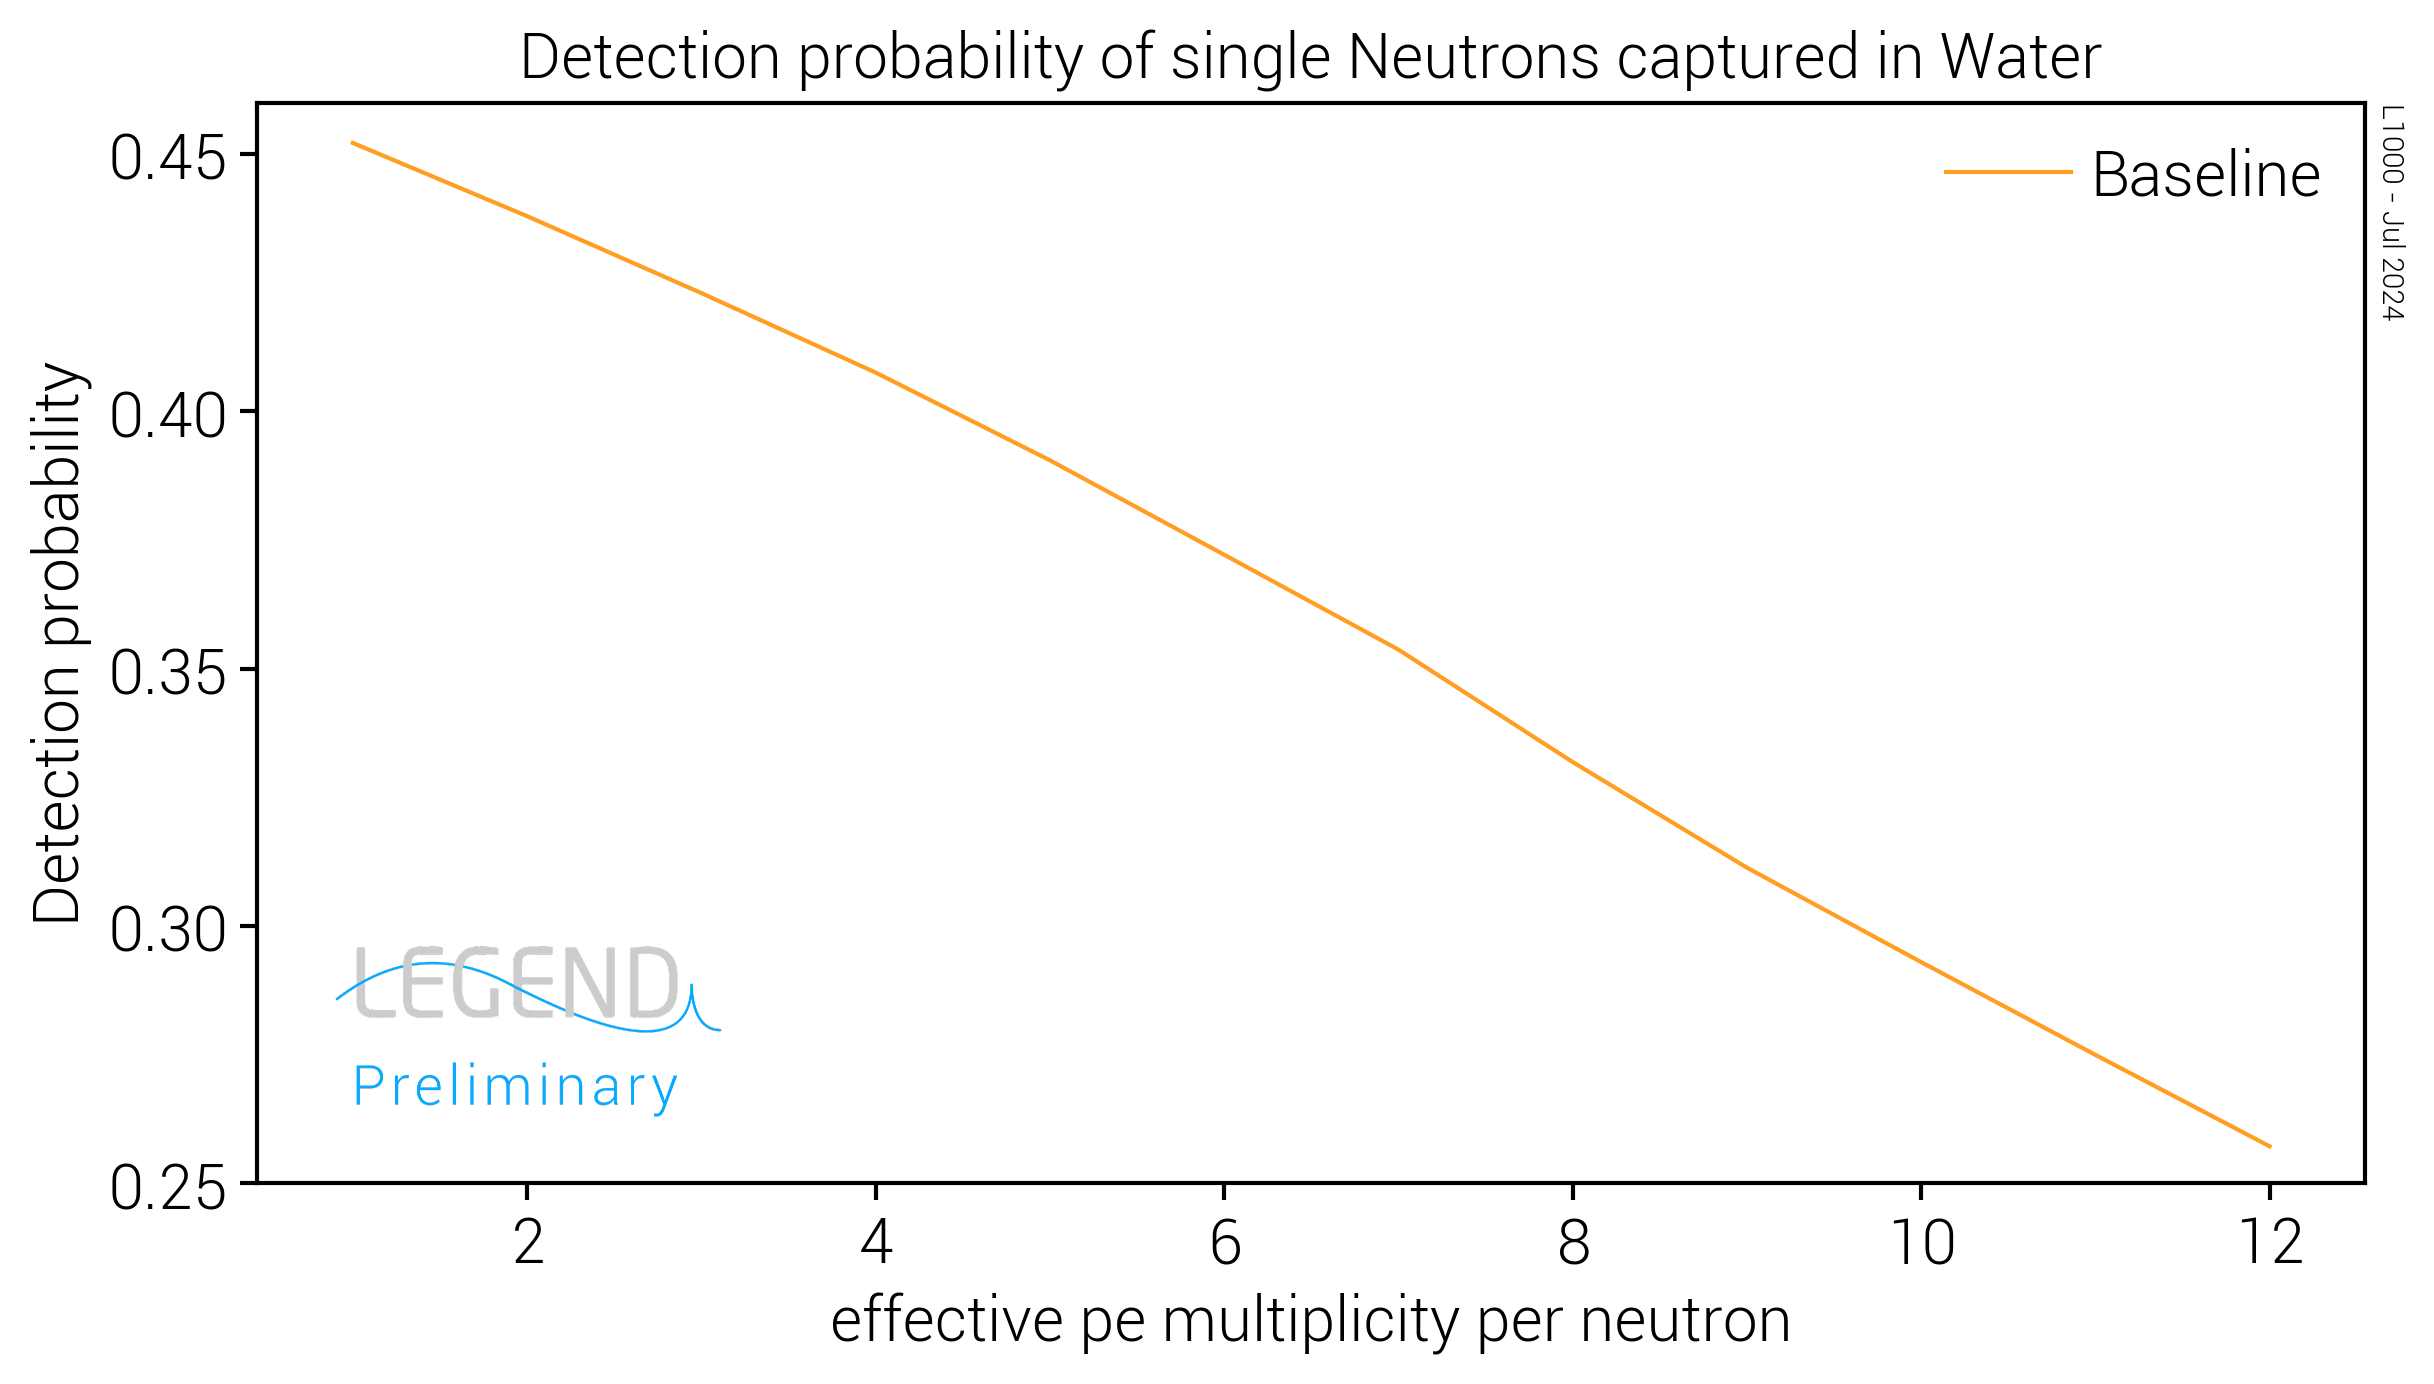

In [26]:
fig, ax1 = plt.subplots()
ax1.plot(xPEs, PePerNCaptureWater,  color = lps.colors["legend_darkblue"], label = name1 + " 500 PMTs")
ax1.plot(xPEs, PePerNCaptureWater_250PMTs,  color = lps.colors["legend_green"], label = name1 + " 250 PMTs")
ax1.plot(xPEs, PePerNCaptureWater_200PMTs,  color = lps.colors["legend_darkgreen"], label = name1 + " 200 PMTs")
ax1.plot(xPEs, PePerNCaptureWater_150PMTs,  color = lps.colors["legend_blue"], label = name1 + " 150 PMTs")
ax1.plot(xPEs, PePerNCaptureWaterSetup2,  color = lps.colors["legend_orange"], label = name2)

ax1.set_xlabel('effective pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of single Neutrons captured in Water')
#ax1.grid()
ax1.legend(loc='best')
ax1.set_ylim(ymin = 0.25, ymax= 0.46)
ax1.set_legend_logo(position="lower left")
ax1.set_legend_annotation()
#plt.savefig("/home/eric/sim/WWLegend/Plots/PMTsImplemented/SingleDetectionChanceWaterCapturesOnlyREFERENZ.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

Showers plot

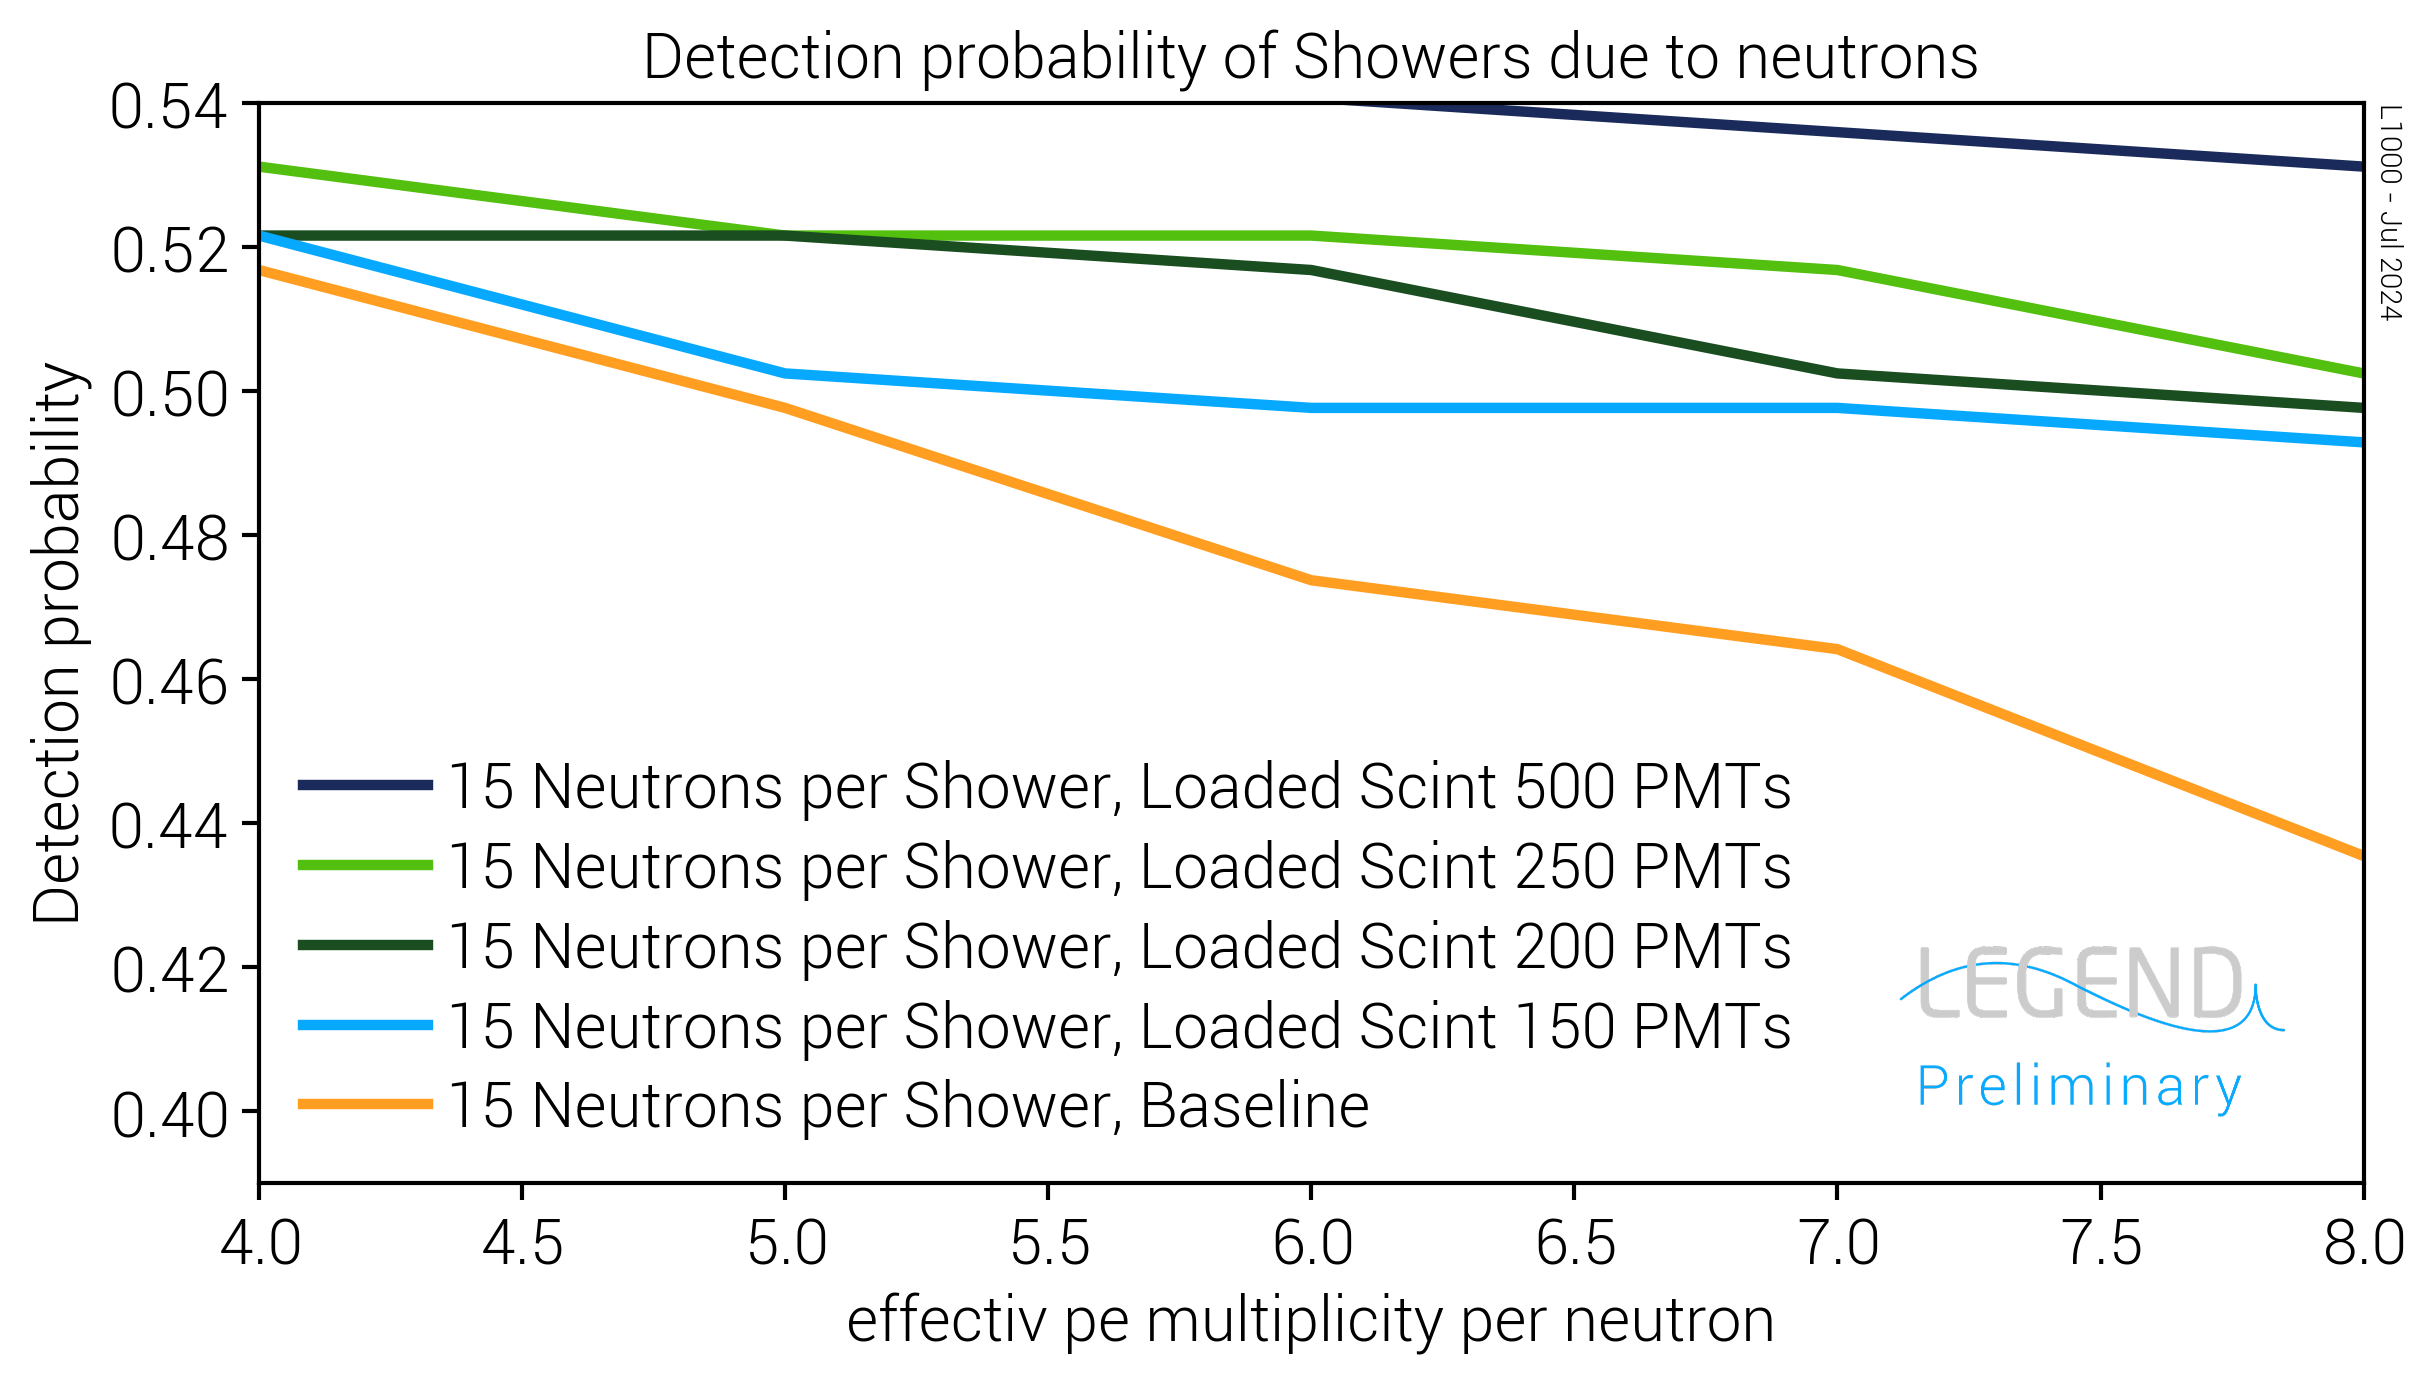

In [18]:
fig, ax1 = plt.subplots()

ax1.plot(multiplicitys, PMMA1, color = lps.colors["legend_darkblue"], linewidth=2.5 ,  label="15 Neutrons per Shower, " + name1 + " 500 PMTs"  )
ax1.plot(multiplicitys, PMMA1_250PMTs, color = lps.colors["legend_green"], linewidth=2.5 ,  label="15 Neutrons per Shower, " + name1 + " 250 PMTs"  )
ax1.plot(multiplicitys, PMMA1_200PMTs, color = lps.colors["legend_darkgreen"], linewidth=2.5 ,  label="15 Neutrons per Shower, " + name1 + " 200 PMTs"  )
ax1.plot(multiplicitys, PMMA1_150PMTs, color = lps.colors["legend_blue"], linewidth=2.5 ,  label="15 Neutrons per Shower, " + name1 + " 150 PMTs"  )
ax1.plot(multiplicitys, PMMA1Setup2, color = lps.colors["legend_orange"], linewidth=2.5,  label="15 Neutrons per Shower, " + name2  )


ax1.set_xlabel('effectiv pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of Showers due to neutrons')
ax1.set_xlim(xmin = 4, xmax= 8)
ax1.set_ylim(ymin = 0.39, ymax= 0.54)
#ax1.grid()



ax1.legend(loc='best')
ax1.set_legend_logo(position="lower right")
ax1.set_legend_annotation()
#info_lines2 = [
#    "solid line = 77Ge inducing",
#    "dashed line = All muons"
#    ]
#info_text2 = '\n'.join(info_lines2)
#
#ax1.text(0.05, 0.15, info_text2, transform=plt.gca().transAxes, bbox=dict(facecolor='C1', alpha=0.3),fontsize=15)

#plt.savefig("/home/eric/sim/WWLegend/Plots/LoadedScint/LoadedScintDetectionAllAndGe.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

Showers more than x plots

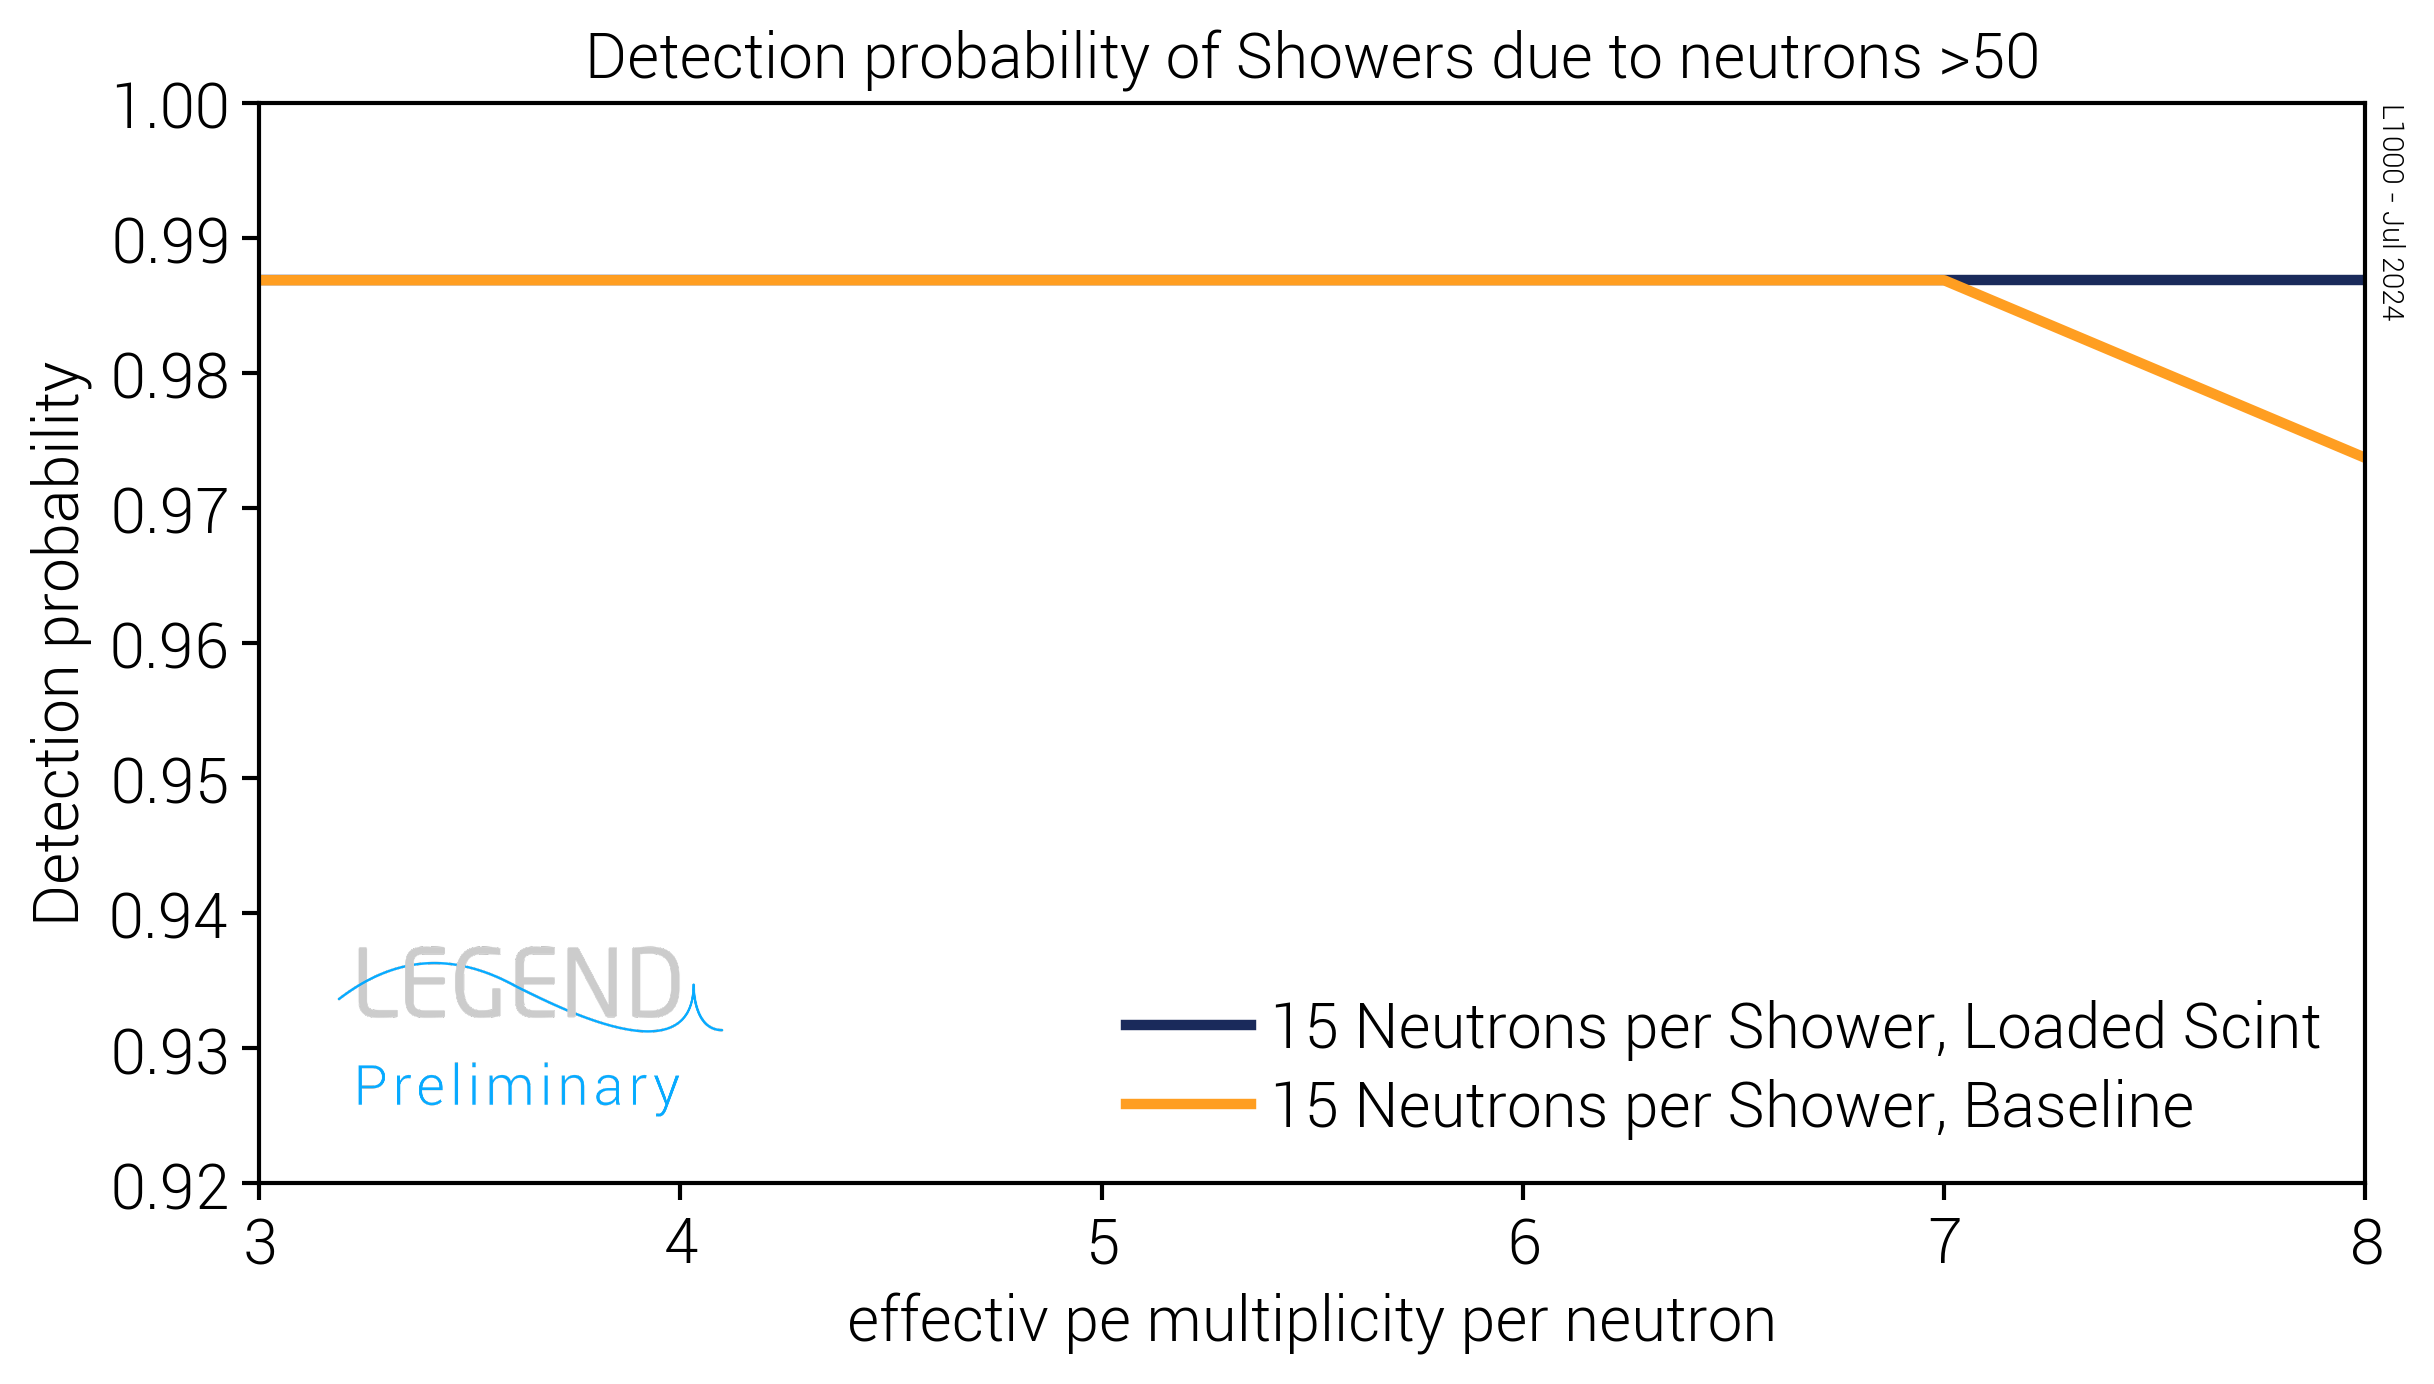

In [19]:
fig, ax1 = plt.subplots()

ax1.plot(multiplicitys, PMMA1_morethan50, color = lps.colors["legend_darkblue"], linewidth=2.5 ,  label="15 Neutrons per Shower, " + name1  )
ax1.plot(multiplicitys, PMMA1_morethan50Setup2, color = lps.colors["legend_orange"], linewidth=2.5 ,  label="15 Neutrons per Shower, " + name2  )

ax1.set_xlabel('effectiv pe multiplicity per neutron')
ax1.set_ylabel('Detection probability')
ax1.set_title('Detection probability of Showers due to neutrons >50')
ax1.set_xlim(xmin = 3, xmax= 8)
ax1.set_ylim(ymin=0.92, ymax= 1)
#ax1.grid()


ax1.legend(loc='lower right')
ax1.set_legend_logo(position="lower left")
ax1.set_legend_annotation()

#info_lines2 = [
#    "solid line = Foil on Cryostat",
#    "dashed line = Foil on PMMA"
#    ]
#info_text2 = '\n'.join(info_lines2)
#
#ax1.text(0.06, 0.21, info_text2, transform=plt.gca().transAxes, bbox=dict(facecolor='C1', alpha=0.3),fontsize=15)

#plt.savefig("/home/eric/sim/WWLegend/Plots/ArgonModvsWithout/Detected_morethan50.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

Plot the average amount of detected neutrons vs amount of water captures

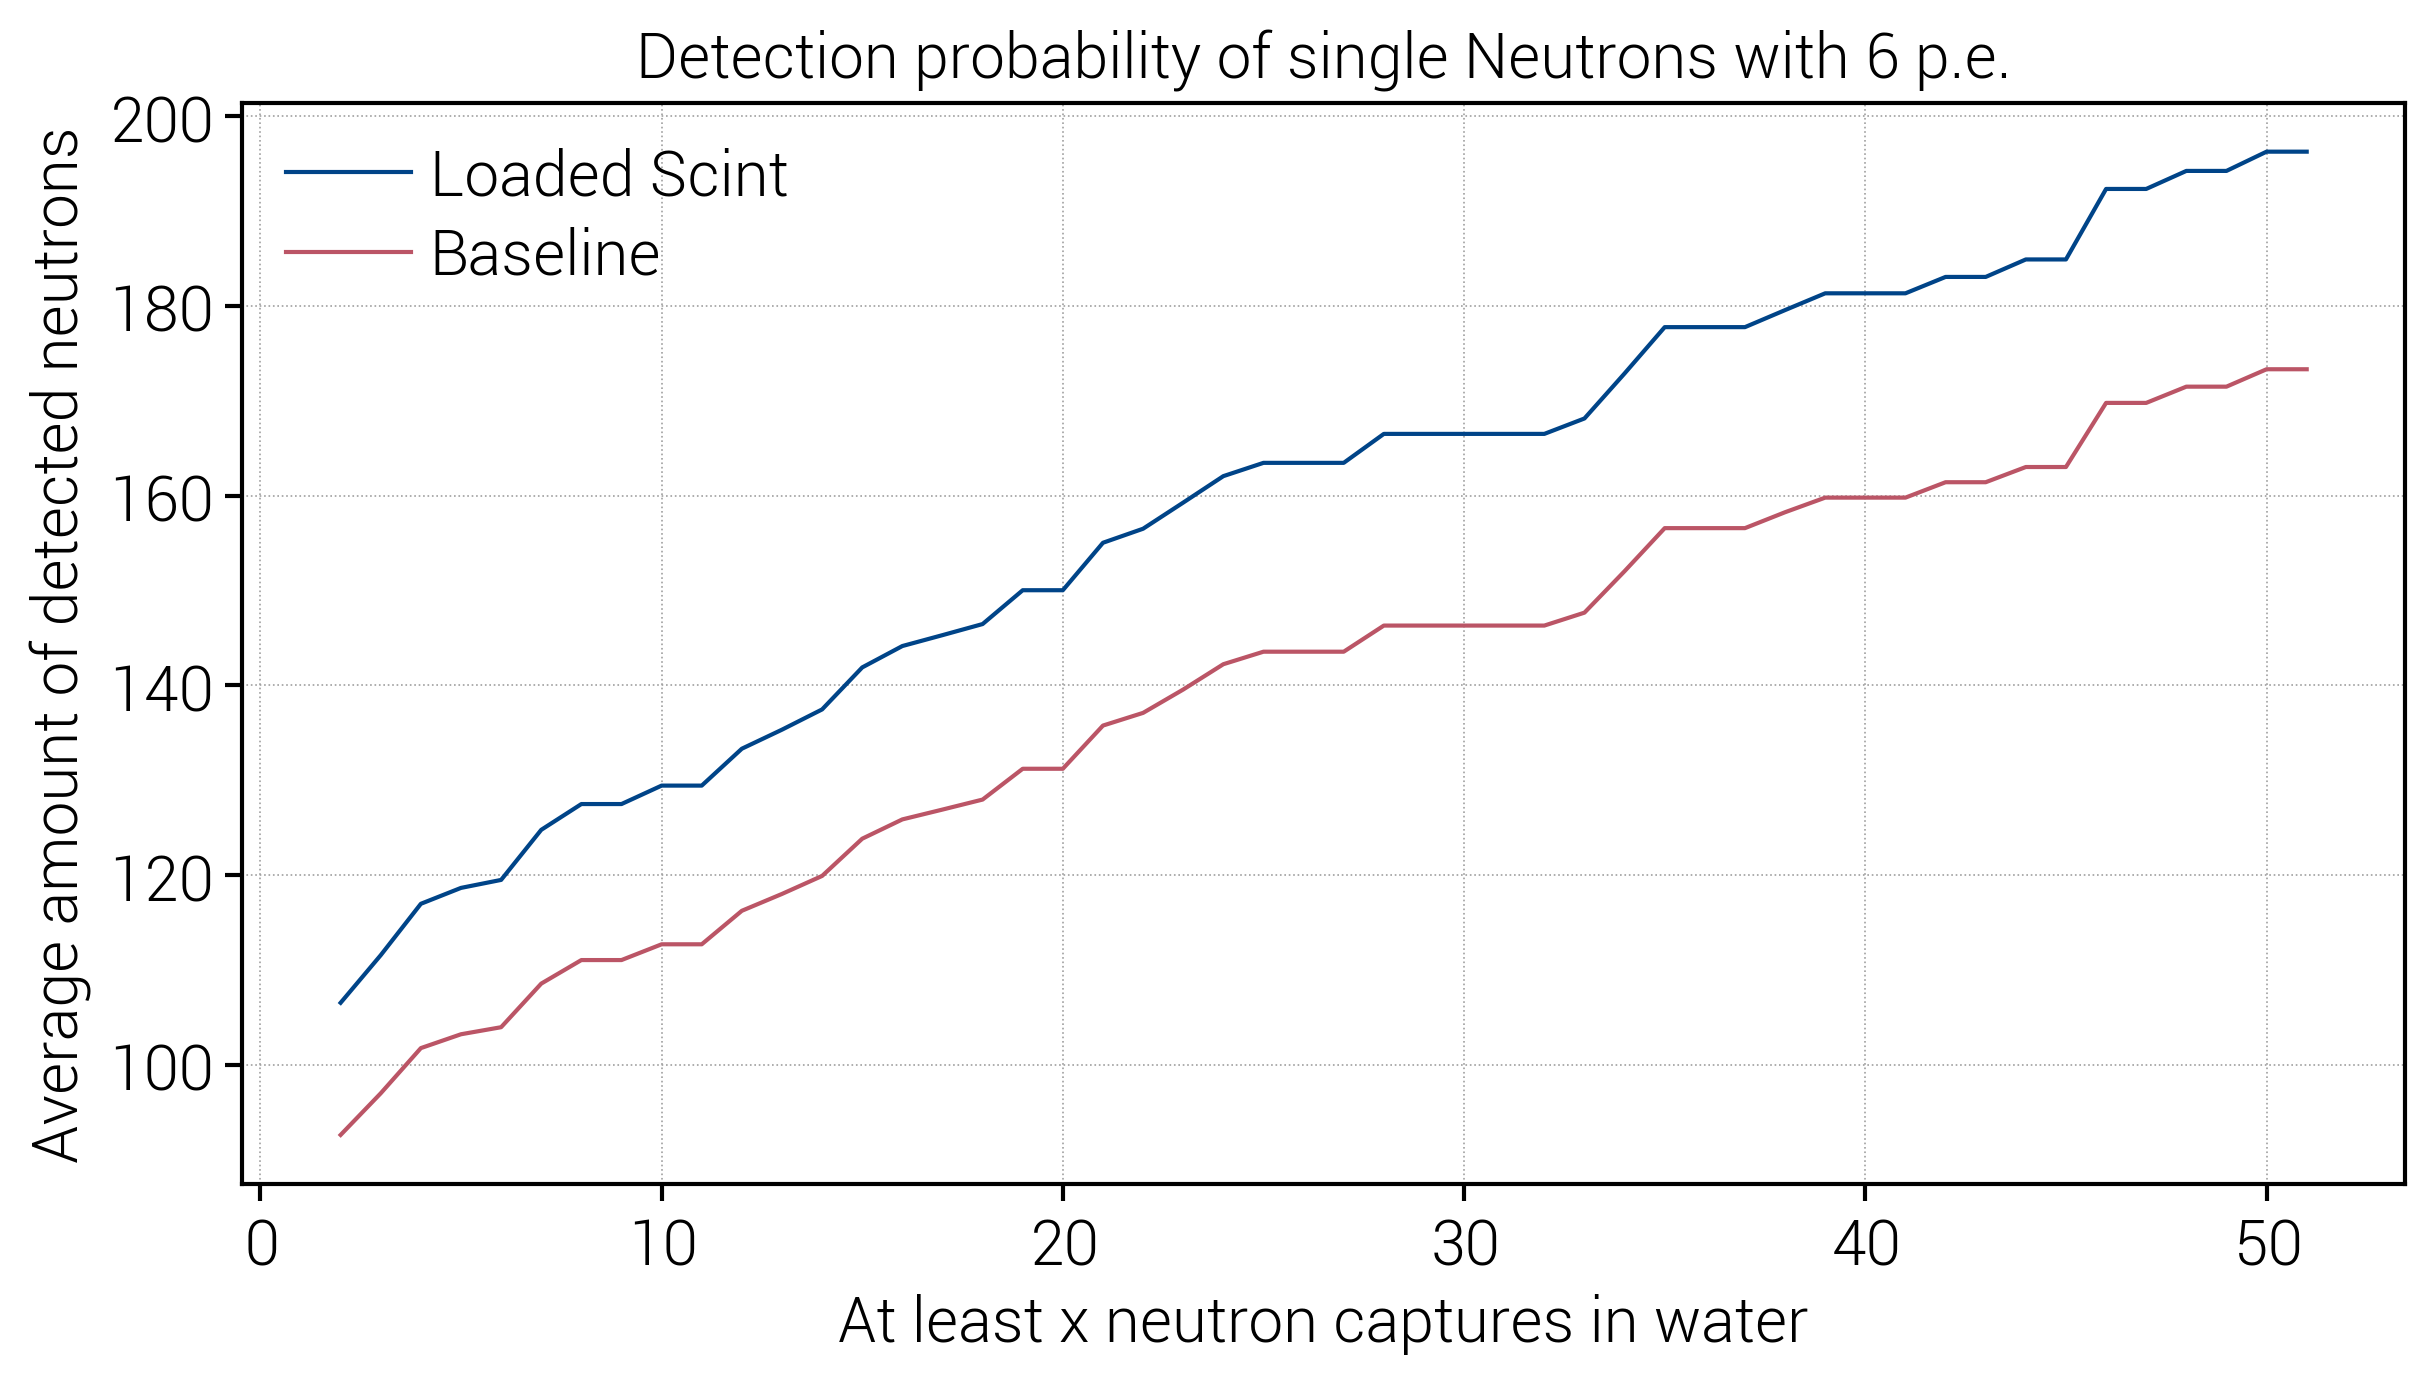

In [20]:
fig, ax1 = plt.subplots()
ax1.plot(neutrons_per_shower, detected_on_average,  color = "#004488", label = name1)
ax1.plot(neutrons_per_shower, detected_on_averageSetup2,  color = "#BB5566", label = name2)

ax1.set_xlabel('At least x neutron captures in water')
ax1.set_ylabel('Average amount of detected neutrons')
ax1.set_title('Detection probability of single Neutrons with 6 p.e.')
ax1.grid()
ax1.legend()
#plt.savefig("/home/eric/sim/WWLegend/Plots/Minimum_neutrons_detected.png")
plt.show()

Plot the average amount of Showers detected for the given Cuts vs amount of water captures

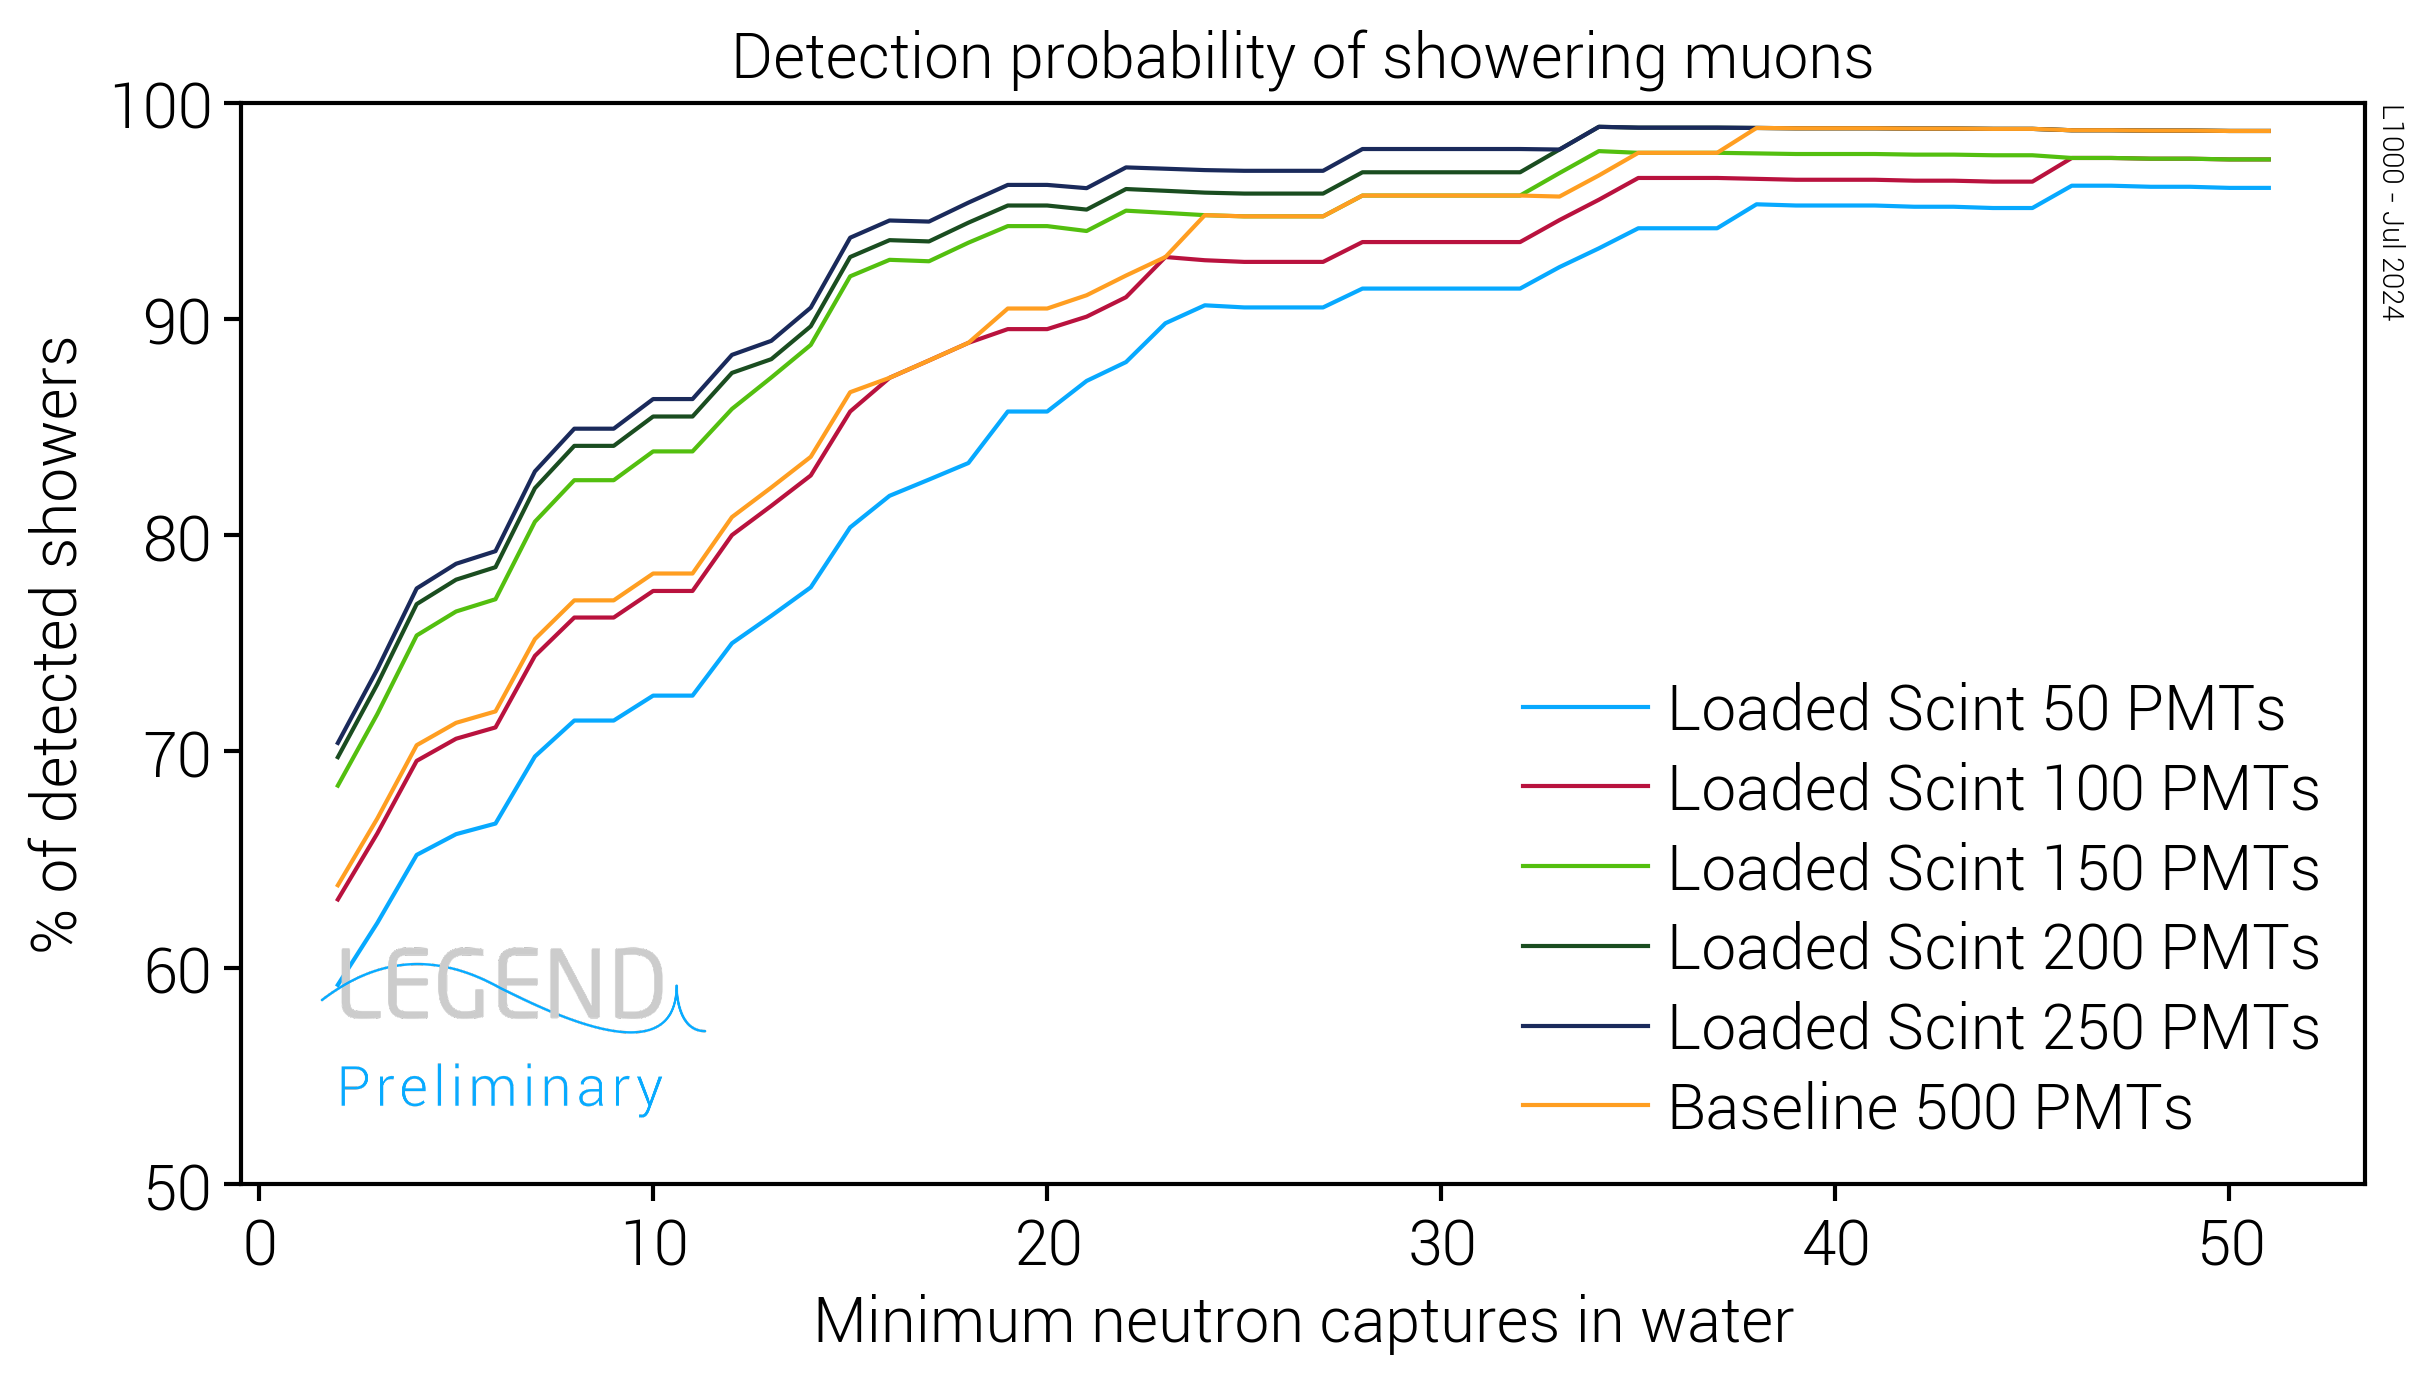

In [21]:
fig, ax1 = plt.subplots()
ax1.plot(neutrons_per_shower, Showers_detected_50PMTs*100,  color = lps.colors["legend_blue"], label = name1 + " 50 PMTs")
ax1.plot(neutrons_per_shower, Showers_detected_100PMTs*100,  color = lps.colors["red"], label = name1 + " 100 PMTs")
ax1.plot(neutrons_per_shower, Showers_detected_150PMTs*100,  color = lps.colors["legend_green"], label = name1 + " 150 PMTs")
ax1.plot(neutrons_per_shower, Showers_detected_200PMTs*100,  color = lps.colors["legend_darkgreen"], label = name1 + " 200 PMTs")
ax1.plot(neutrons_per_shower, Showers_detected_250PMTs*100,  color = lps.colors["legend_darkblue"], label = name1 + " 250 PMTs")
ax1.plot(neutrons_per_shower, Showers_detectedSetup2*100,  color = lps.colors["legend_orange"], label = name2 + " 500 PMTs")

ax1.set_xlabel('Minimum neutron captures in water')
ax1.set_ylabel('% of detected showers')
ax1.set_title('Detection probability of showering muons')
ax1.set_ylim(ymin=50, ymax=100)
ax1.legend(loc="lower right")
ax1.set_legend_logo(position="lower left")
ax1.set_legend_annotation()
plt.tight_layout()
#plt.savefig("/home/eric/sim/WWLegend/Plots/LoadedScint/LoadedScintAverage_Showers_detected.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

Plots for deadtime

NameError: name 'PMMADeadtime_firstPlot_5' is not defined

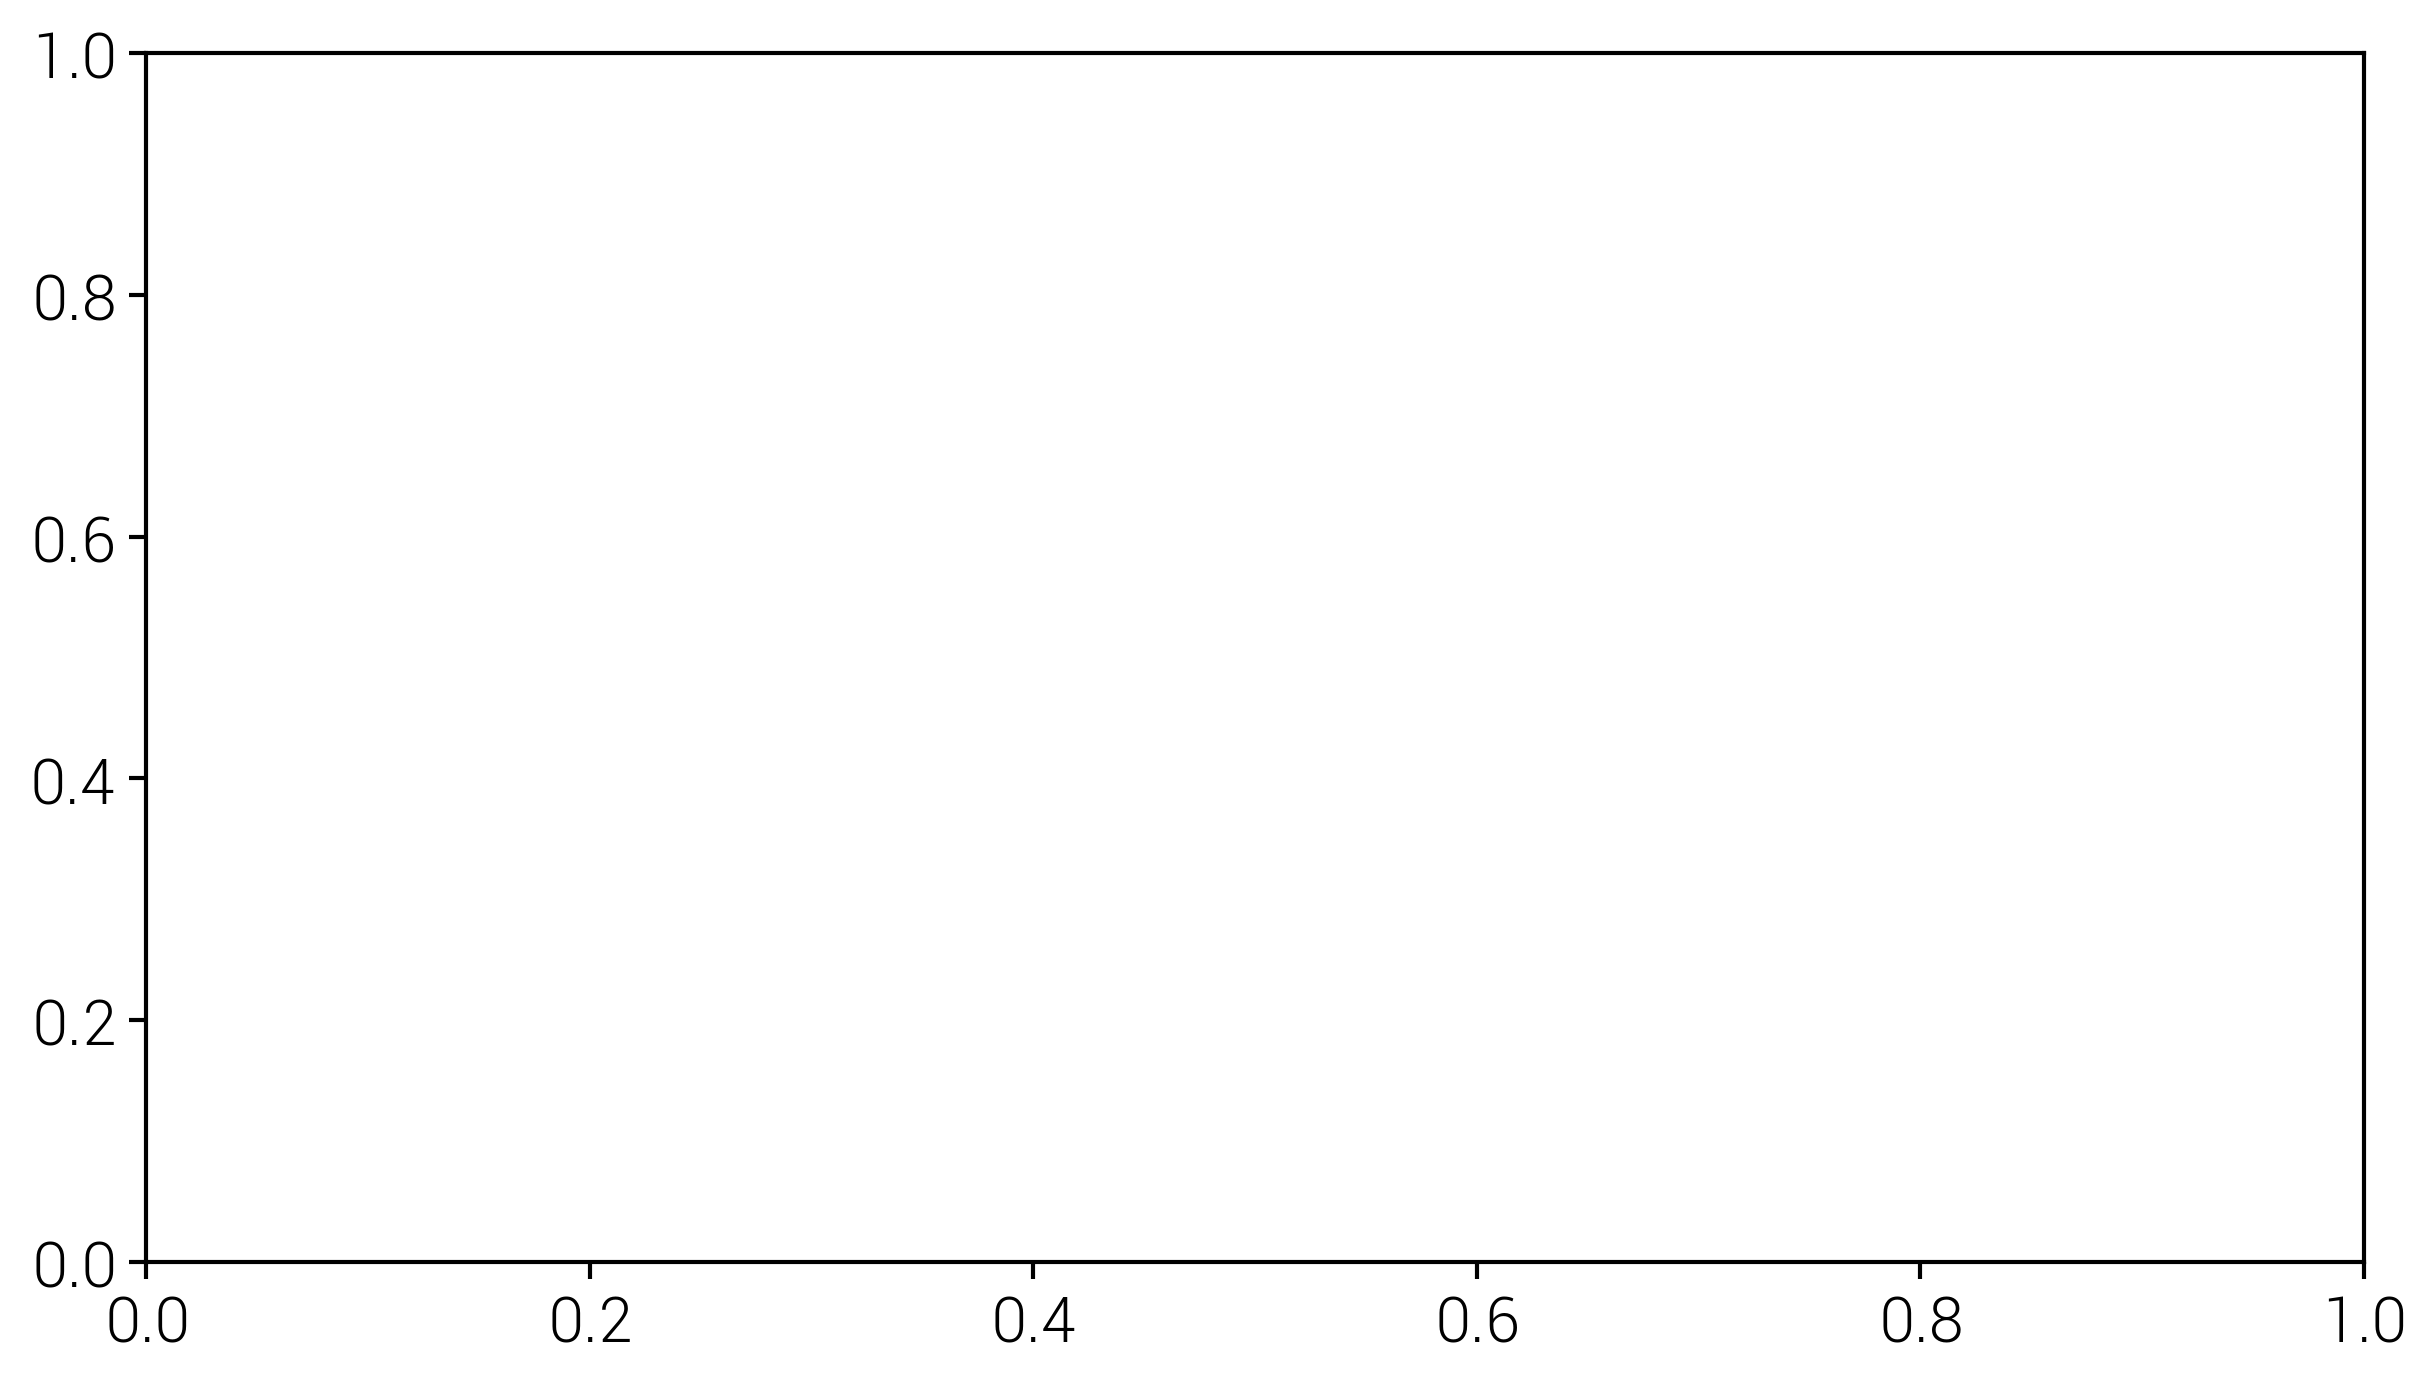

In [22]:
fig, ax1 = plt.subplots()
#  Total number of muons * rate * time in s (270s veto time) * 100%
factor = (14153/100000)*514*270/(60*60)*100 #Convert % of detections to deadtime
#ax1.plot(multiplicitys, PMMAFoil1*factor, color = "#004488", linewidth=2.5,  label="1 Neutrons per Shower"  )
#ax1.plot(multiplicitys, PMMAFoil2*factor, color = "#DDAA33", linewidth=2.5, label="2 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMADeadtime_firstPlot_5*factor, linewidth=2.5, linestyle="--",label="5 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMADeadtime_firstPlot_7*factor, linewidth=2.5, linestyle="--",label="7 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMADeadtime_firstPlot_10*factor, linewidth=2.5, linestyle="--",label="10 Neutrons per Shower"  )
ax1.plot(multiplicitys, PMMADeadtime_firstPlot_15*factor, linewidth=2.5, linestyle="--",label="15 Neutrons per Shower"  )

ax2 = ax1.twinx()
ax2.plot(multiplicitys, PMMA2_morethan50, linewidth=2.5, label="3 Neutrons per Shower"  )
ax2.plot(multiplicitys, PMMA5_morethan50, linewidth=2.5, label="5 Neutrons per Shower"  )
ax2.plot(multiplicitys, PMMA7_morethan50, linewidth=2.5, label="7 Neutrons per Shower"  )
ax2.plot(multiplicitys, PMMA3_morethan50, linewidth=2.5, label="10 Neutrons per Shower"  )
ax2.plot(multiplicitys, PMMA15_morethan50, linewidth=2.5, label="15 Neutrons per Shower"  )

ax1.set_xlabel('effectiv pe multiplicity per neutron')
ax2.set_ylabel('Detection Chance')
ax1.set_ylabel('Deadtime in %')
ax1.set_title('Detection probability of Showers due to neutrons')
ax1.set_xlim(xmin = 4, xmax=8)
ax1.grid()



ax2.legend(loc='best')


#plt.savefig("/home/eric/sim/WWLegend/Plots/EfficiencyNoFoil.png")
plt.show()

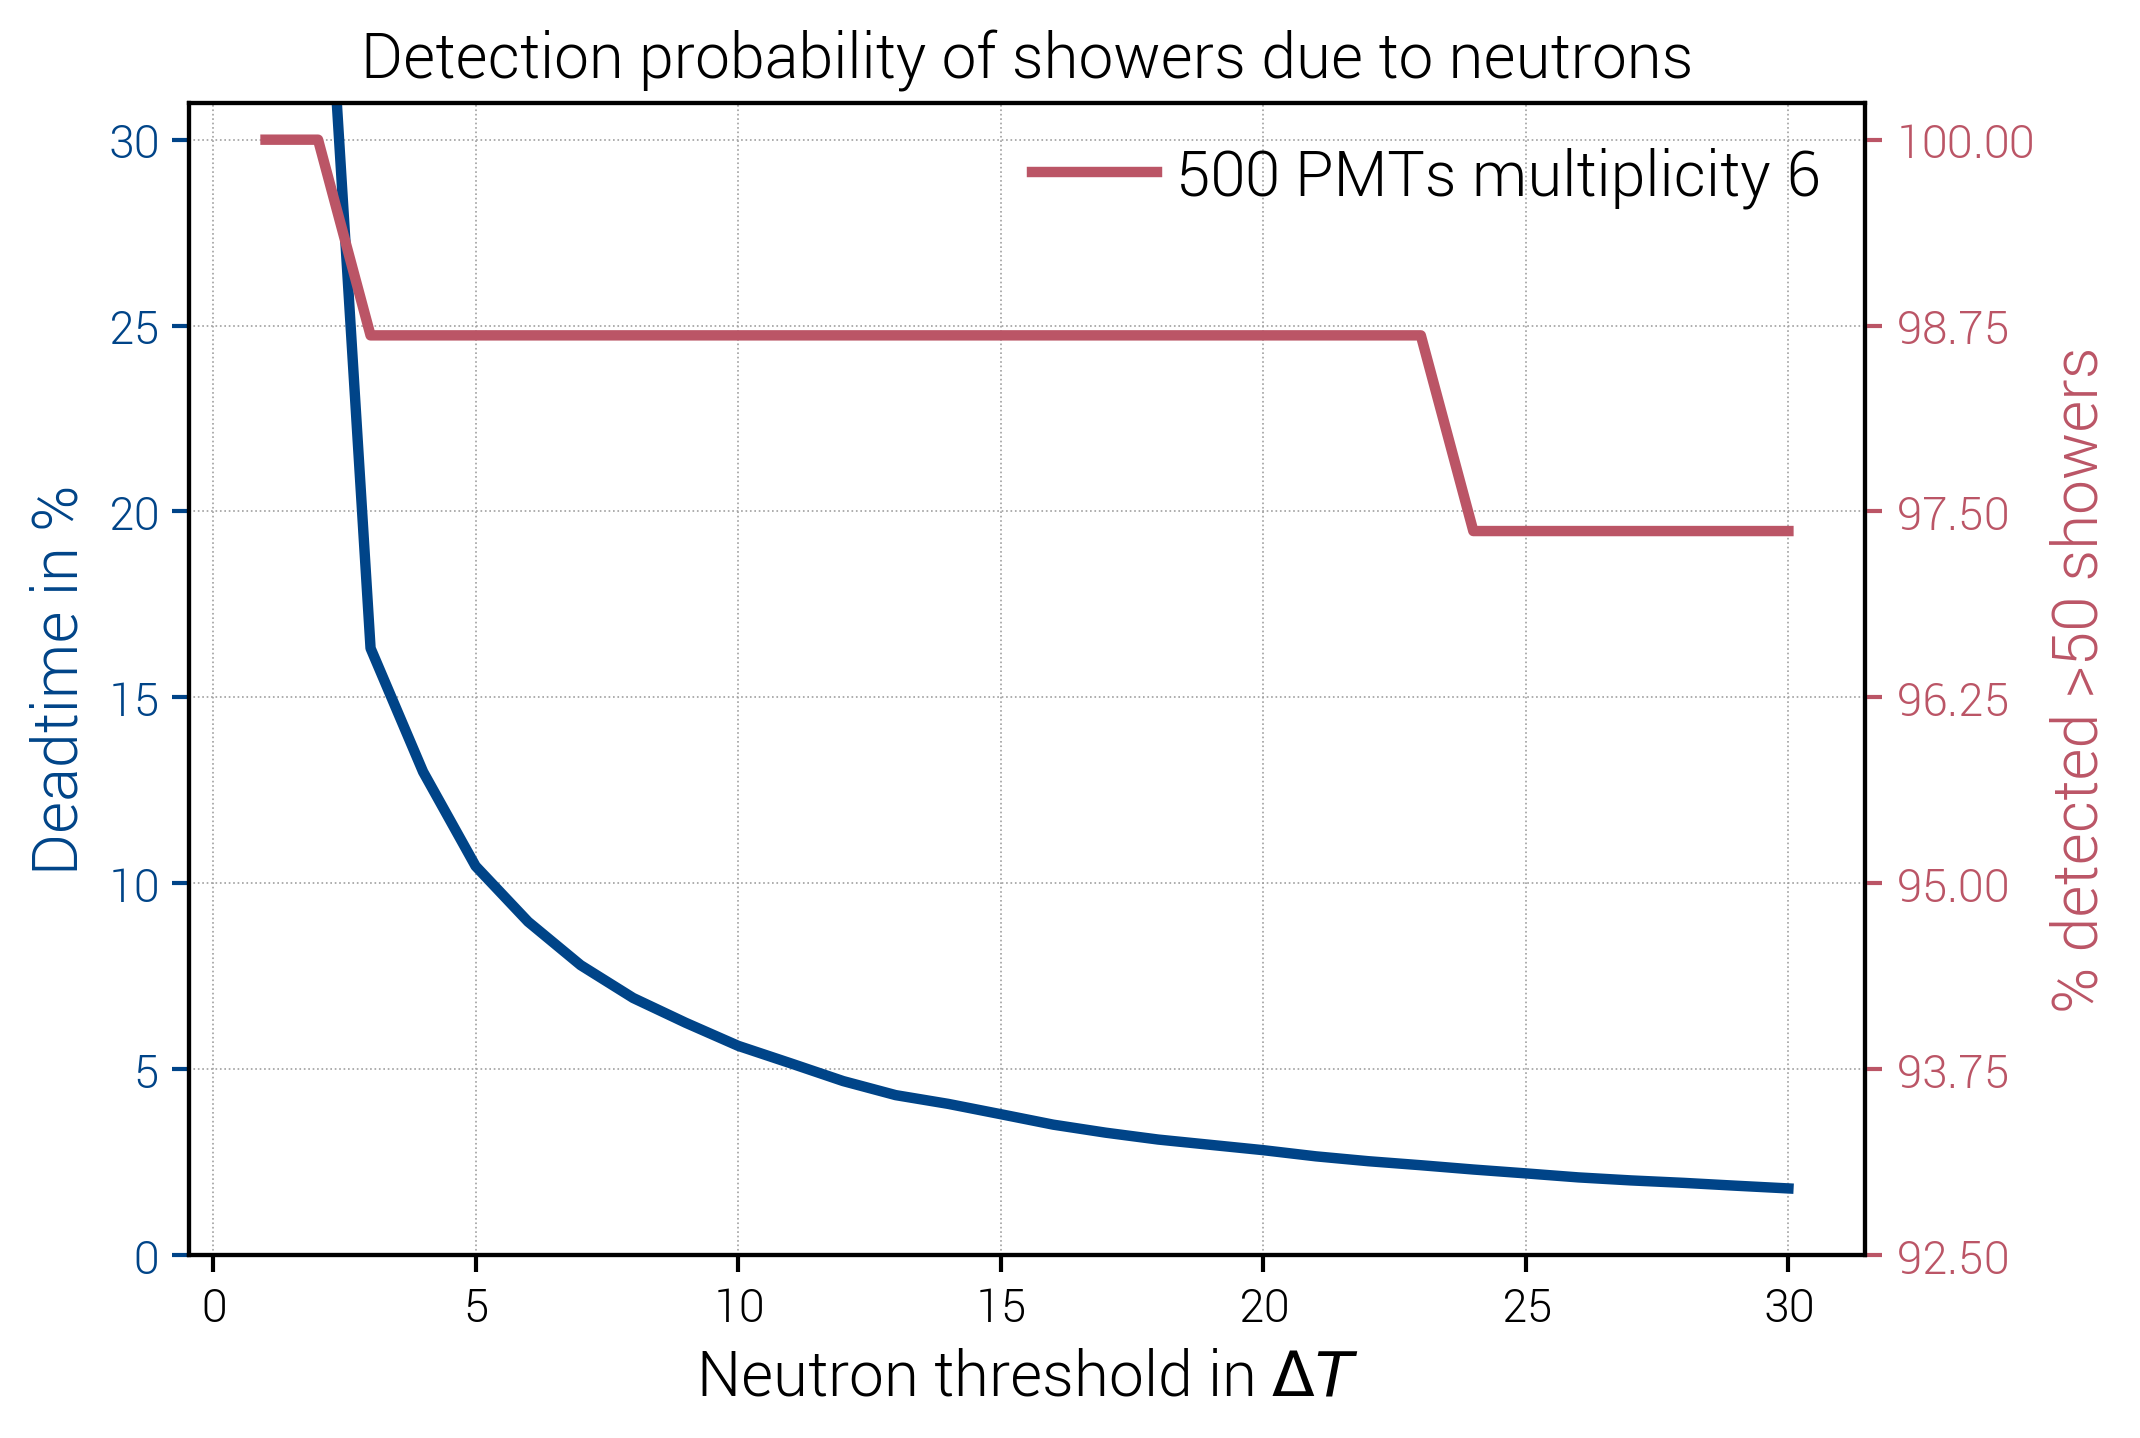

3.789465
0.9868421052631579


In [ ]:
fig, ax1 = plt.subplots(figsize=(7.02, 4.68))
plt.rc('font', size=12)
#  Total number of muons * rate * time in s (270s veto time) * 100%
factor = (141527/1000000)*514*270/(60*60)*100 #Convert % of detections to deadtime
ax1.plot(Neutron_x, PMMADeadtime*factor, linewidth=2.5, color= "#004488", label="500 PMTs multiplicity 6"  )
ax2 = ax1.twinx()
ax2.plot(Neutron_x, PMMADetected650*100, linewidth=2.5, color="#BB5566", label="500 PMTs multiplicity 6"  )

ax1.set_xlabel(r'Neutron threshold in $\Delta T$')
ax1.set_ylabel('Deadtime in %', color=  "#004488" )
ax2.set_ylabel('% detected >50 showers', color="#BB5566")
ax1.set_ylim(0,31)
ax1.set_yticks(np.linspace(0,30, 7))

#ax2.set_ylim(0.9,1)
ax2.set_yticks(np.linspace(92.5,100, 7))
ax1.tick_params(axis='y', colors='#004488')
ax2.tick_params(axis='y', colors='#BB5566')
ax1.set_title('Detection probability of showers due to neutrons')
#ax1.set_xlim(xmin=8, xmax=20)
#ax1.set_ylim(ymin=0, ymax=5)
ax1.grid()

ax2.set_ylim(ymin=92.5,ymax=100.25)


ax2.legend(loc='best')
ax1.tick_params(axis='both', which='major', labelsize=11)
ax2.tick_params(axis='both', which='major', labelsize=11)
plt.tight_layout()
plt.savefig("/home/eric/sim/WWLegend/Plots/DeadTimeAndDetected.svg", bbox_inches="tight", pad_inches=0.1)
plt.show()
print(PMMADeadtime[14]*factor)
print(PMMADetected650[14])

Wavelength Stuff

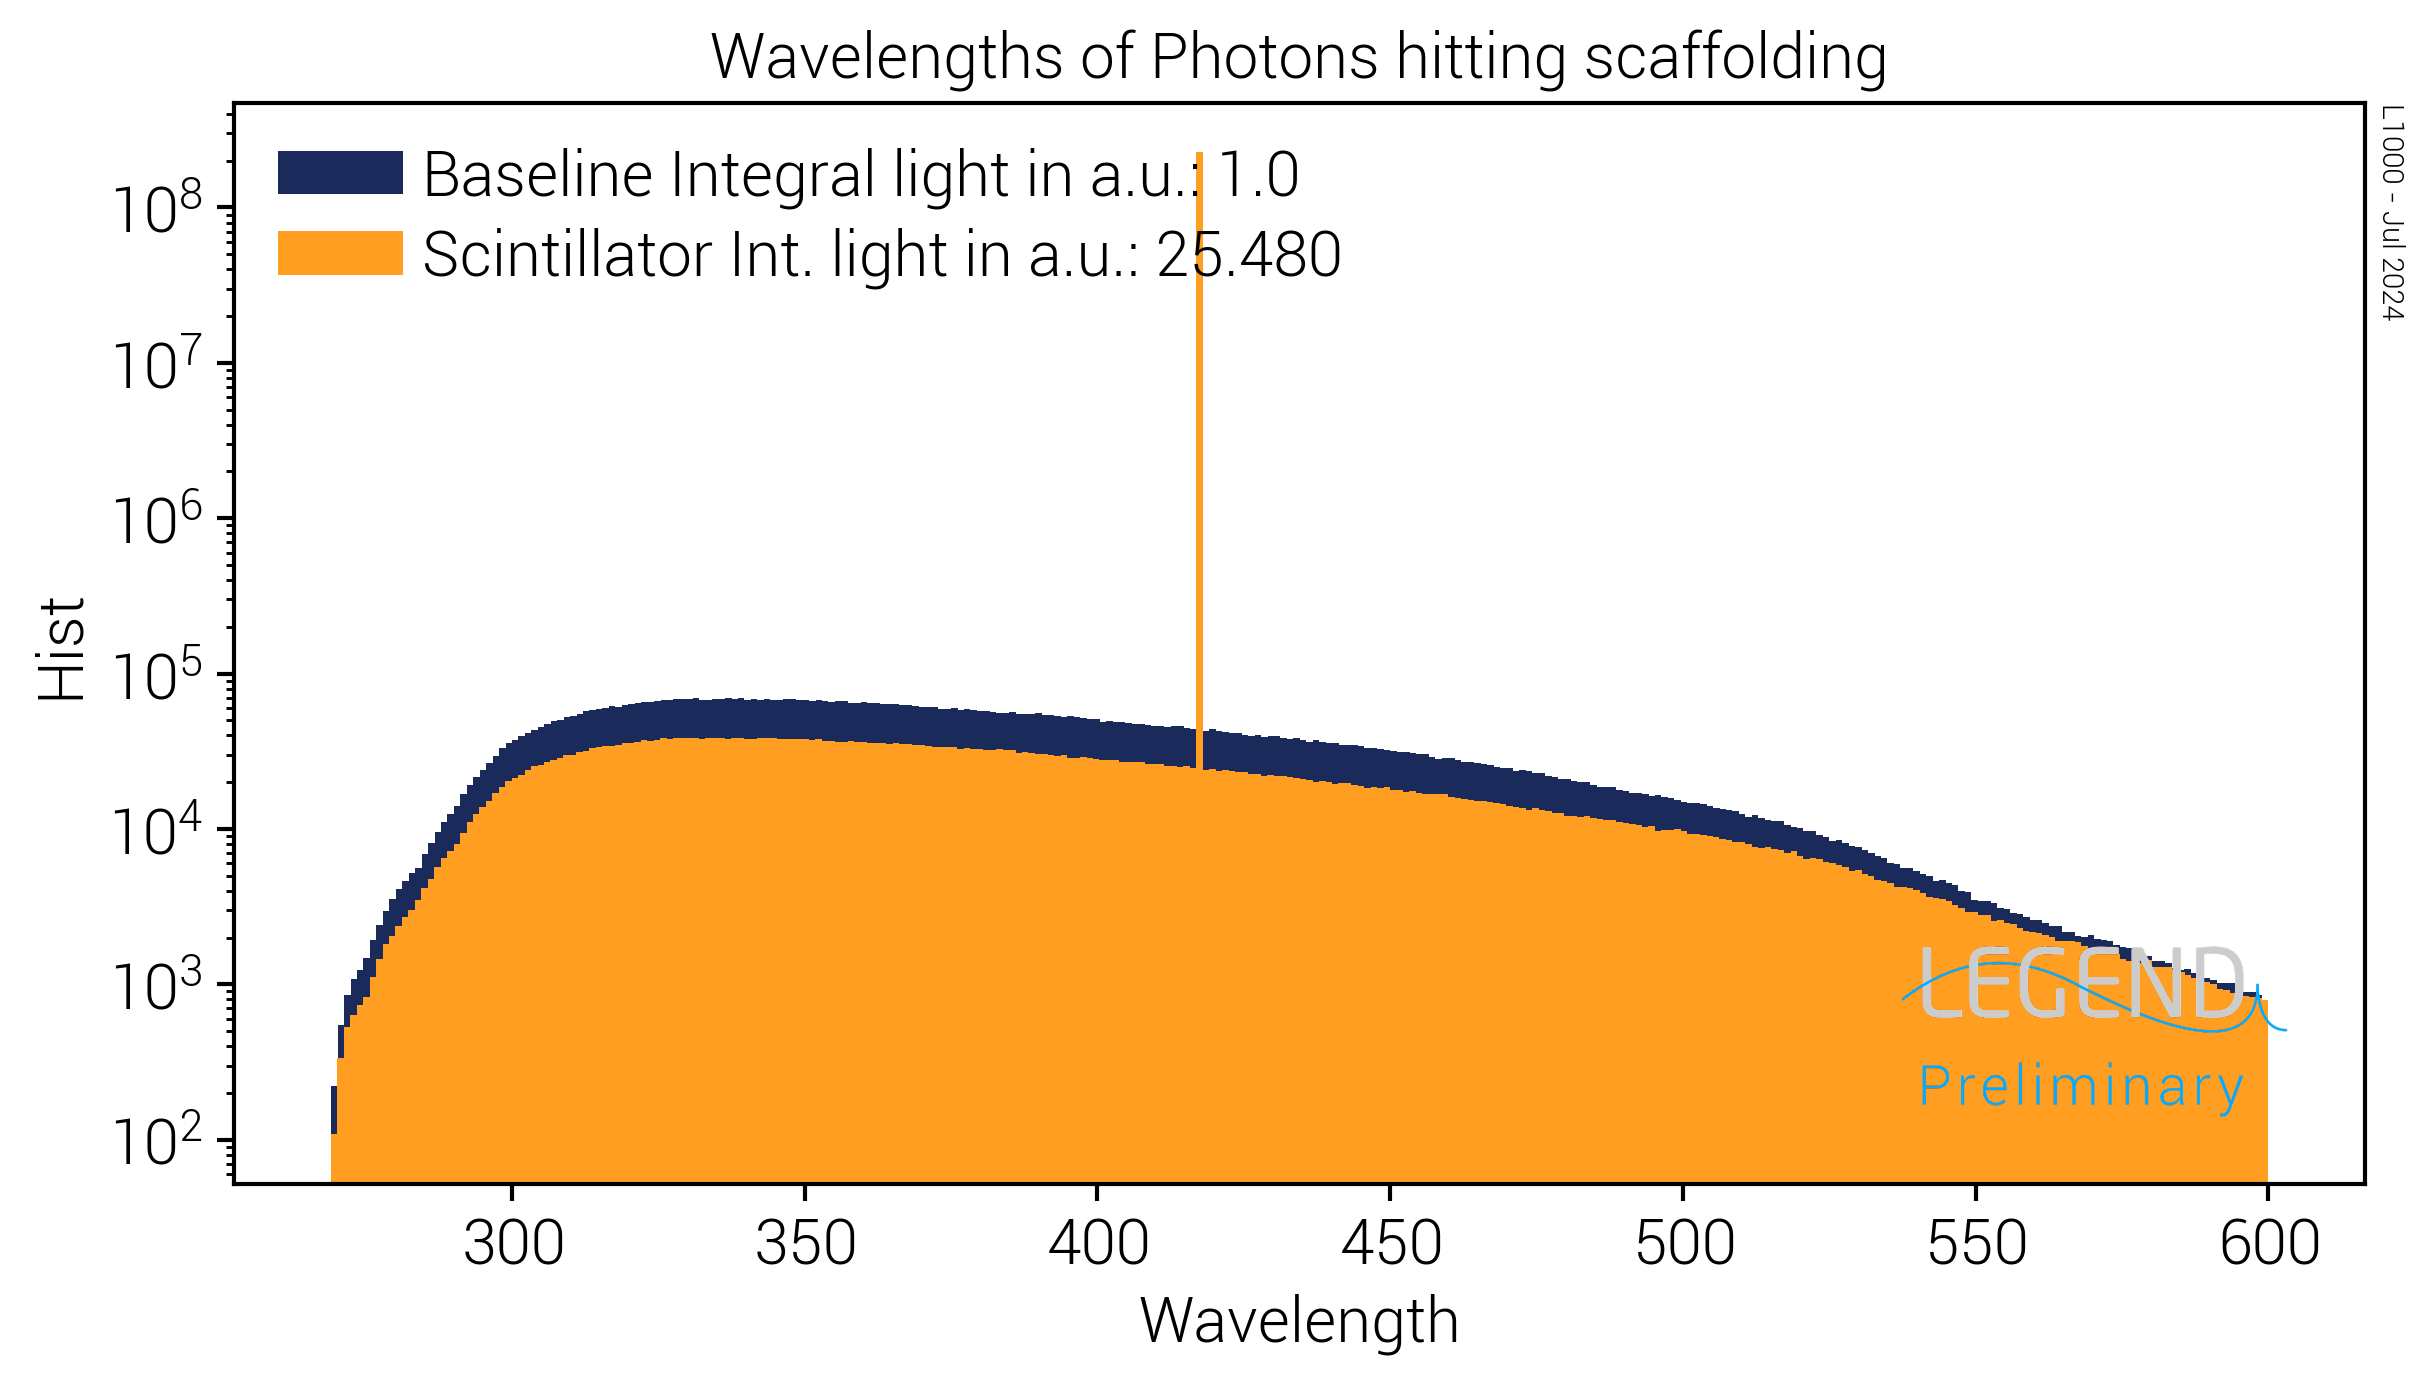

Photons orange: 234062043.0
Photons blue: 9186269.0
Fraction more in orange: 25.47955464835615


In [ ]:
fig, ax1 = plt.subplots()
sum1 = np.sum(nPMMA)
sum2 = np.sum(nPMMAFoil)

ax1.hist(WavelengthsPMMAFoil, bins=300, color = lps.colors["legend_darkblue"], label= f"Baseline Integral light in a.u.: {sum2/sum2}")
ax1.hist(WavelengthsPMMA, bins=300, color = lps.colors["legend_orange"], label= f"Scintillator Int. light in a.u.: {(sum1/sum2):.3f}")

ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Hist')
ax1.set_yscale("log")
ax1.set_title('Wavelengths of Photons hitting scaffolding')
ax1.legend(loc= "upper left")
ax1.set_legend_logo(position="lower right")
ax1.set_legend_annotation()
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/LoadedScint/PhotonWavelengthsWithLoadedScint.png")
plt.show()

print(f"Photons orange: {sum1}")
print(f"Photons blue: {sum2}")
print(f"Fraction more in orange: {sum1/sum2}")

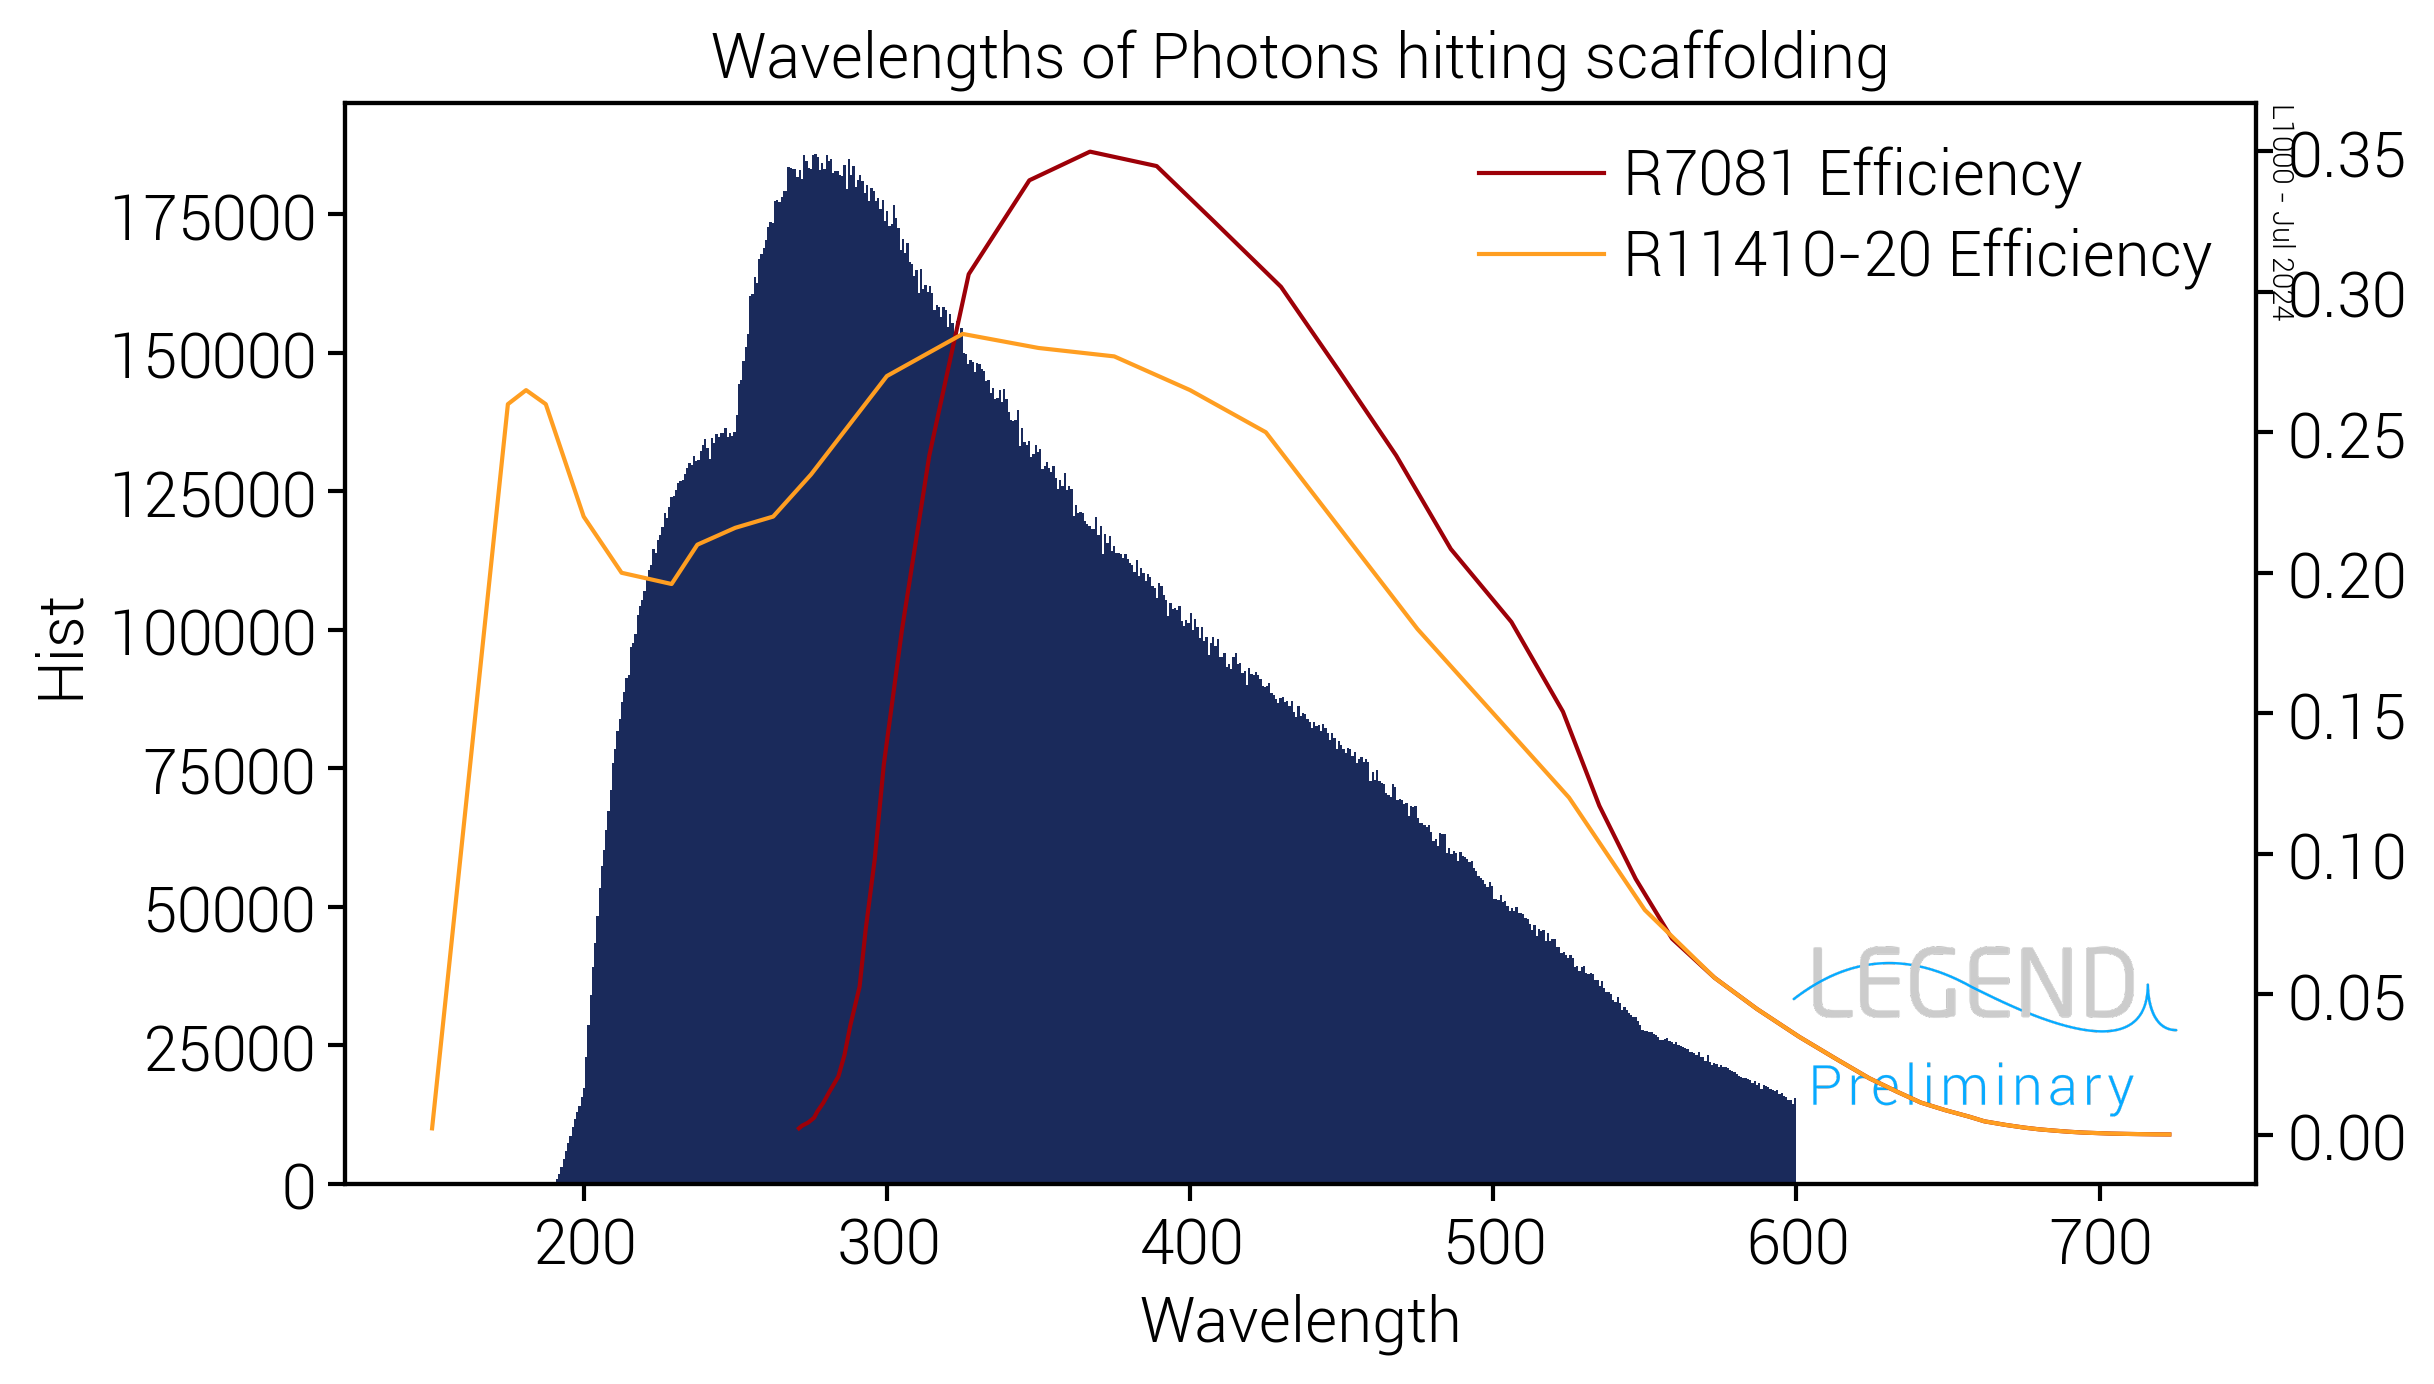

In [ ]:
PMTWavelength, PMTqe = np.loadtxt("/home/eric/sim/WWLegend/Archive/R7081_QE.csv", dtype=float, delimiter=',', skiprows=1, unpack=True)
UPMTWavelength, UPMTqe = np.loadtxt("/home/eric/sim/WWLegend/Archive/R11410-20_QE.csv", dtype=float, delimiter=',', skiprows=1, unpack=True)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
counts, bins, patches = ax1.hist(WavelengthsPMMAFoil, color = lps.colors["legend_darkblue"], label="Simulation")
ax2.plot(PMTWavelength, PMTqe/100, color = lps.colors["darkred"], label= "R7081 Efficiency")
ax2.plot(UPMTWavelength, UPMTqe/100, color = lps.colors["legend_orange"], label= "R11410-20 Efficiency")

ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Hist')
ax1.set_title('Wavelengths of Photons hitting scaffolding')
ax2.legend(loc= "upper right")
ax1.set_legend_logo(position="lower right")
ax1.set_legend_annotation()
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/WavelengthPMT/PhotonWavelengthsAndPMTs.png")
#TOODO: Dann berechnen wie viel detected each.
plt.show()

Calculate detected Photons

In [ ]:
efficiency_interpolatorPMT = interp1d(PMTWavelength, PMTqe/100, kind='linear', bounds_error=False, fill_value=0)
efficiency_interpolatorUPMT = interp1d(UPMTWavelength, UPMTqe/100, kind='linear', bounds_error=False, fill_value=0)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Interpolate the PMT efficiency at the bin centers
interpolated_efficiencyPMT = efficiency_interpolatorPMT(bin_centers)
interpolated_efficiencyUPMT = efficiency_interpolatorUPMT(bin_centers)

# Calculate the number of detected photons in each bin
detected_photons_per_binPMT = counts * interpolated_efficiencyPMT
detected_photons_per_binUPMT = counts * interpolated_efficiencyUPMT

# Sum to get the total number of detected photons
total_detected_photonsPMT = detected_photons_per_binPMT.sum()
total_detected_photonsUPMT = detected_photons_per_binUPMT.sum()

print("Total detected photons normal PMT:", total_detected_photonsPMT)
print("Total detected photons UV PMT:", total_detected_photonsUPMT)

Total detected photons normal PMT: 9141688.813436842
Total detected photons UV PMT: 12042240.887831915


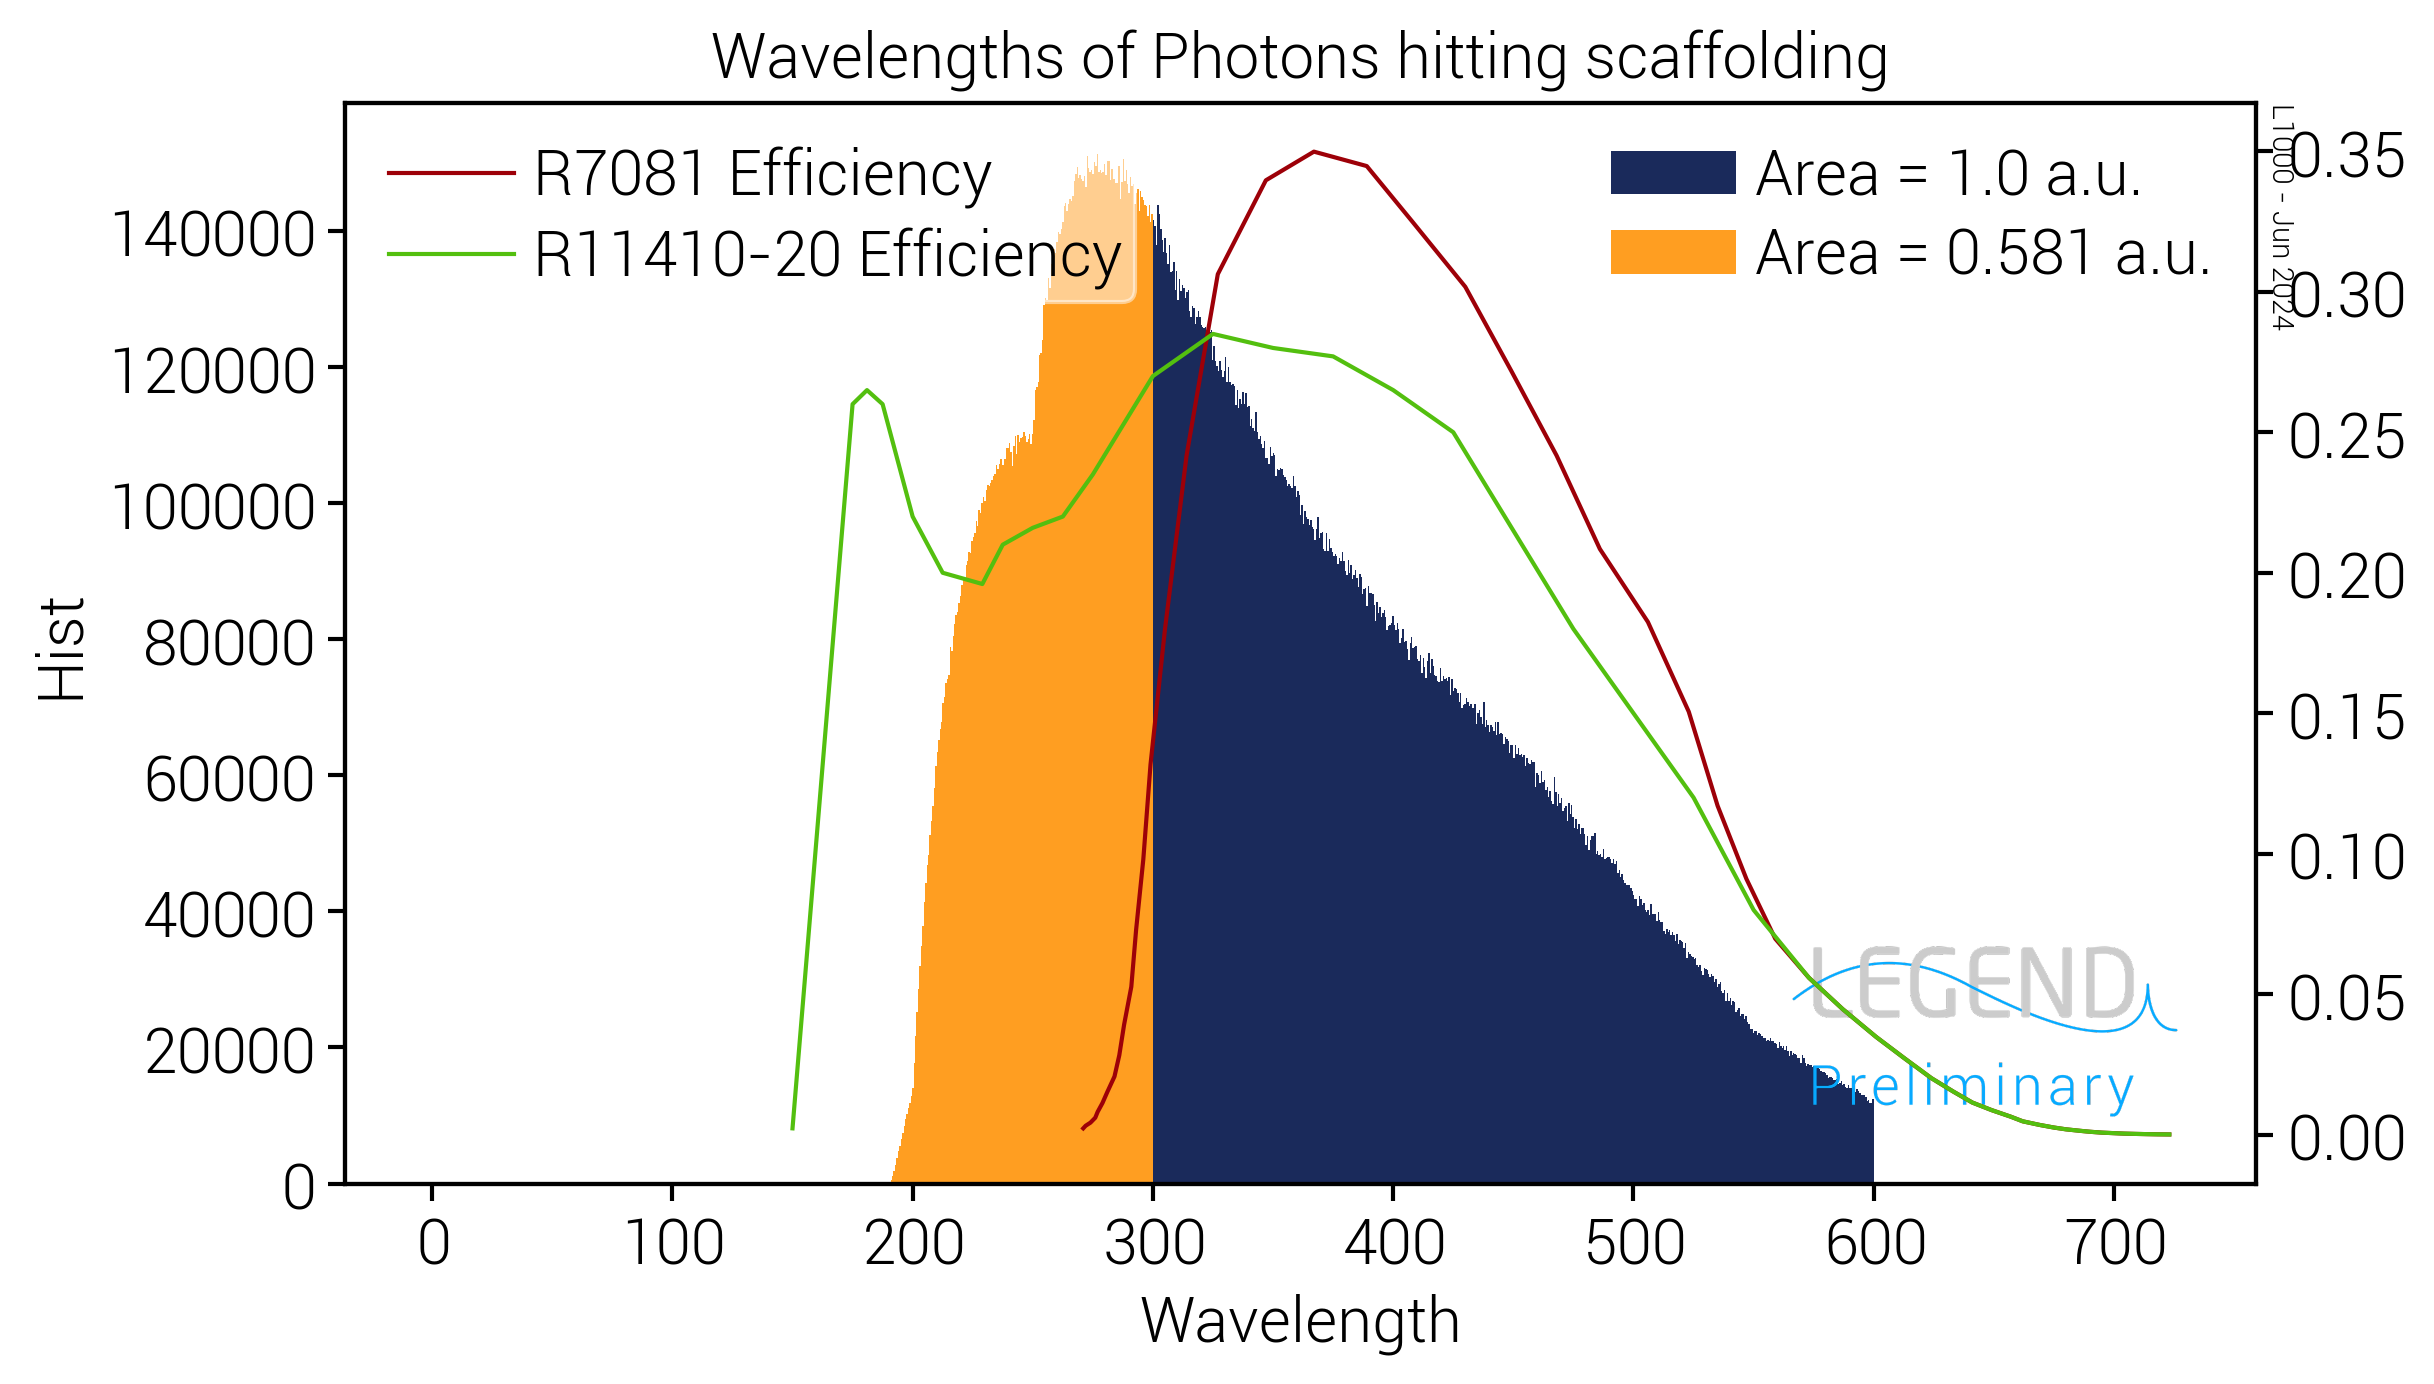

In [ ]:
fig, ax1 = plt.subplots()
counts1, bins1, patches = ax1.hist(WavelengthsPMMAFoil,bins= 500, range=(300, 600), color = lps.colors["legend_darkblue"])
counts2, bins2, patches = ax1.hist(WavelengthsPMMAFoil, bins=500, range=(0, 300), color = lps.colors["legend_orange"])
area1 = np.sum(counts1)
area2 = np.sum(counts2)
ax1.hist(WavelengthsPMMAFoil,bins= 1, range=(0, 1), color = lps.colors["legend_darkblue"], label=f"Area = {area1/area1} a.u.")
ax1.hist(WavelengthsPMMAFoil, bins=1, range=(0, 1), color = lps.colors["legend_orange"],  label=f"Area = {(area2/area1):.3f} a.u.")
ax2 = ax1.twinx()
ax2.plot(PMTWavelength, PMTqe/100, color = lps.colors["darkred"], label= f"R7081 Efficiency")
ax2.plot(UPMTWavelength, UPMTqe/100, color = lps.colors["legend_green"], label= f"R11410-20 Efficiency")

ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Hist')
ax1.set_title('Wavelengths of Photons hitting scaffolding')
ax1.legend(loc= "upper right")
ax2.legend(loc= "upper left", facecolor='white', framealpha=0.5)
ax1.set_legend_logo(position="lower right")
ax1.set_legend_annotation()
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/WavelengthPMT/WavelengthAreas.png")
plt.show()

Convolution doesnt work, just plot bins

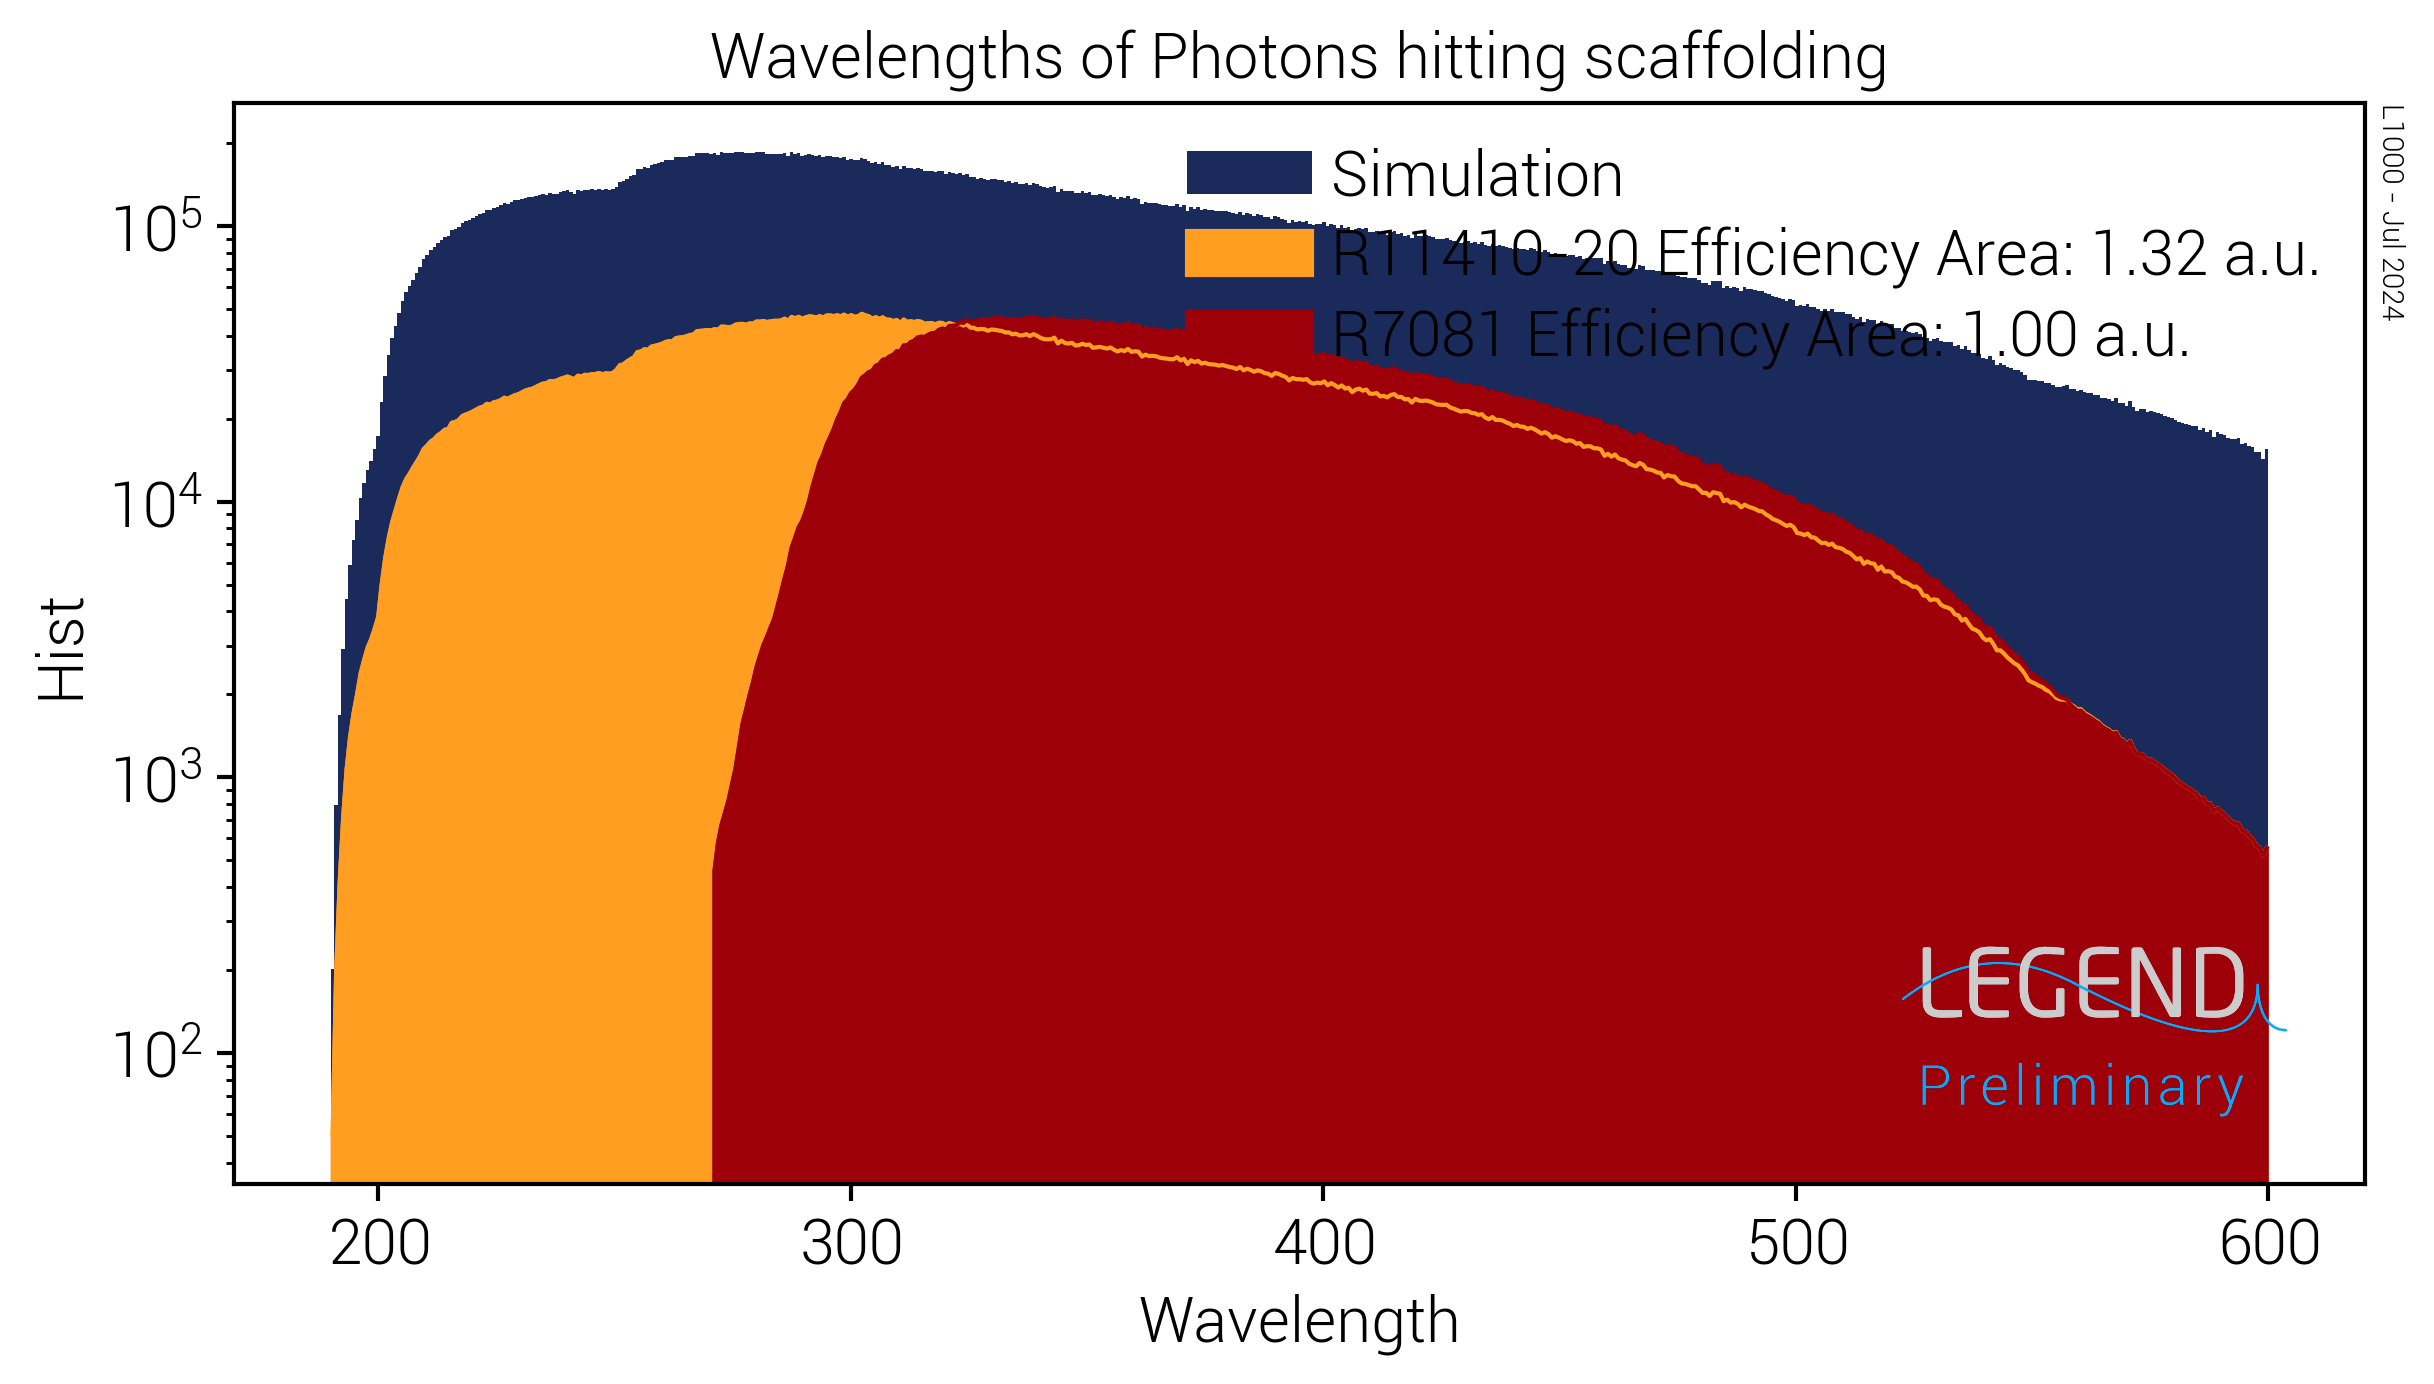

In [ ]:
fig, ax1 = plt.subplots()
ax1.hist(WavelengthsPMMAFoil, color = lps.colors["legend_darkblue"], label="Simulation")
ax1.plot(bin_centers, detected_photons_per_binUPMT, color = lps.colors["legend_orange"])
ax1.fill_between(bin_centers, detected_photons_per_binUPMT, color = lps.colors["legend_orange"], label= f"R11410-20 Efficiency Area: {(total_detected_photonsUPMT/total_detected_photonsPMT):.2f} a.u.")
ax1.plot(bin_centers, detected_photons_per_binPMT, color = lps.colors["darkred"])
ax1.fill_between(bin_centers, detected_photons_per_binPMT, color = lps.colors["darkred"], label= f"R7081 Efficiency Area: {(total_detected_photonsPMT/total_detected_photonsPMT):.2f} a.u.")

ax1.set_xlabel('Wavelength')
ax1.set_ylabel('Hist')
ax1.set_yscale("log")
ax1.set_title('Wavelengths of Photons hitting scaffolding')
ax1.legend(loc= "upper right")
ax1.set_legend_logo(position="lower right")
ax1.set_legend_annotation()
#ax1.grid()
plt.savefig("/home/eric/sim/WWLegend/Plots/WavelengthPMT/PMTAreas.png")
#TOODO: Dann berechnen wie viel detected each.
plt.show()

Stuff To investigate a 200ns event

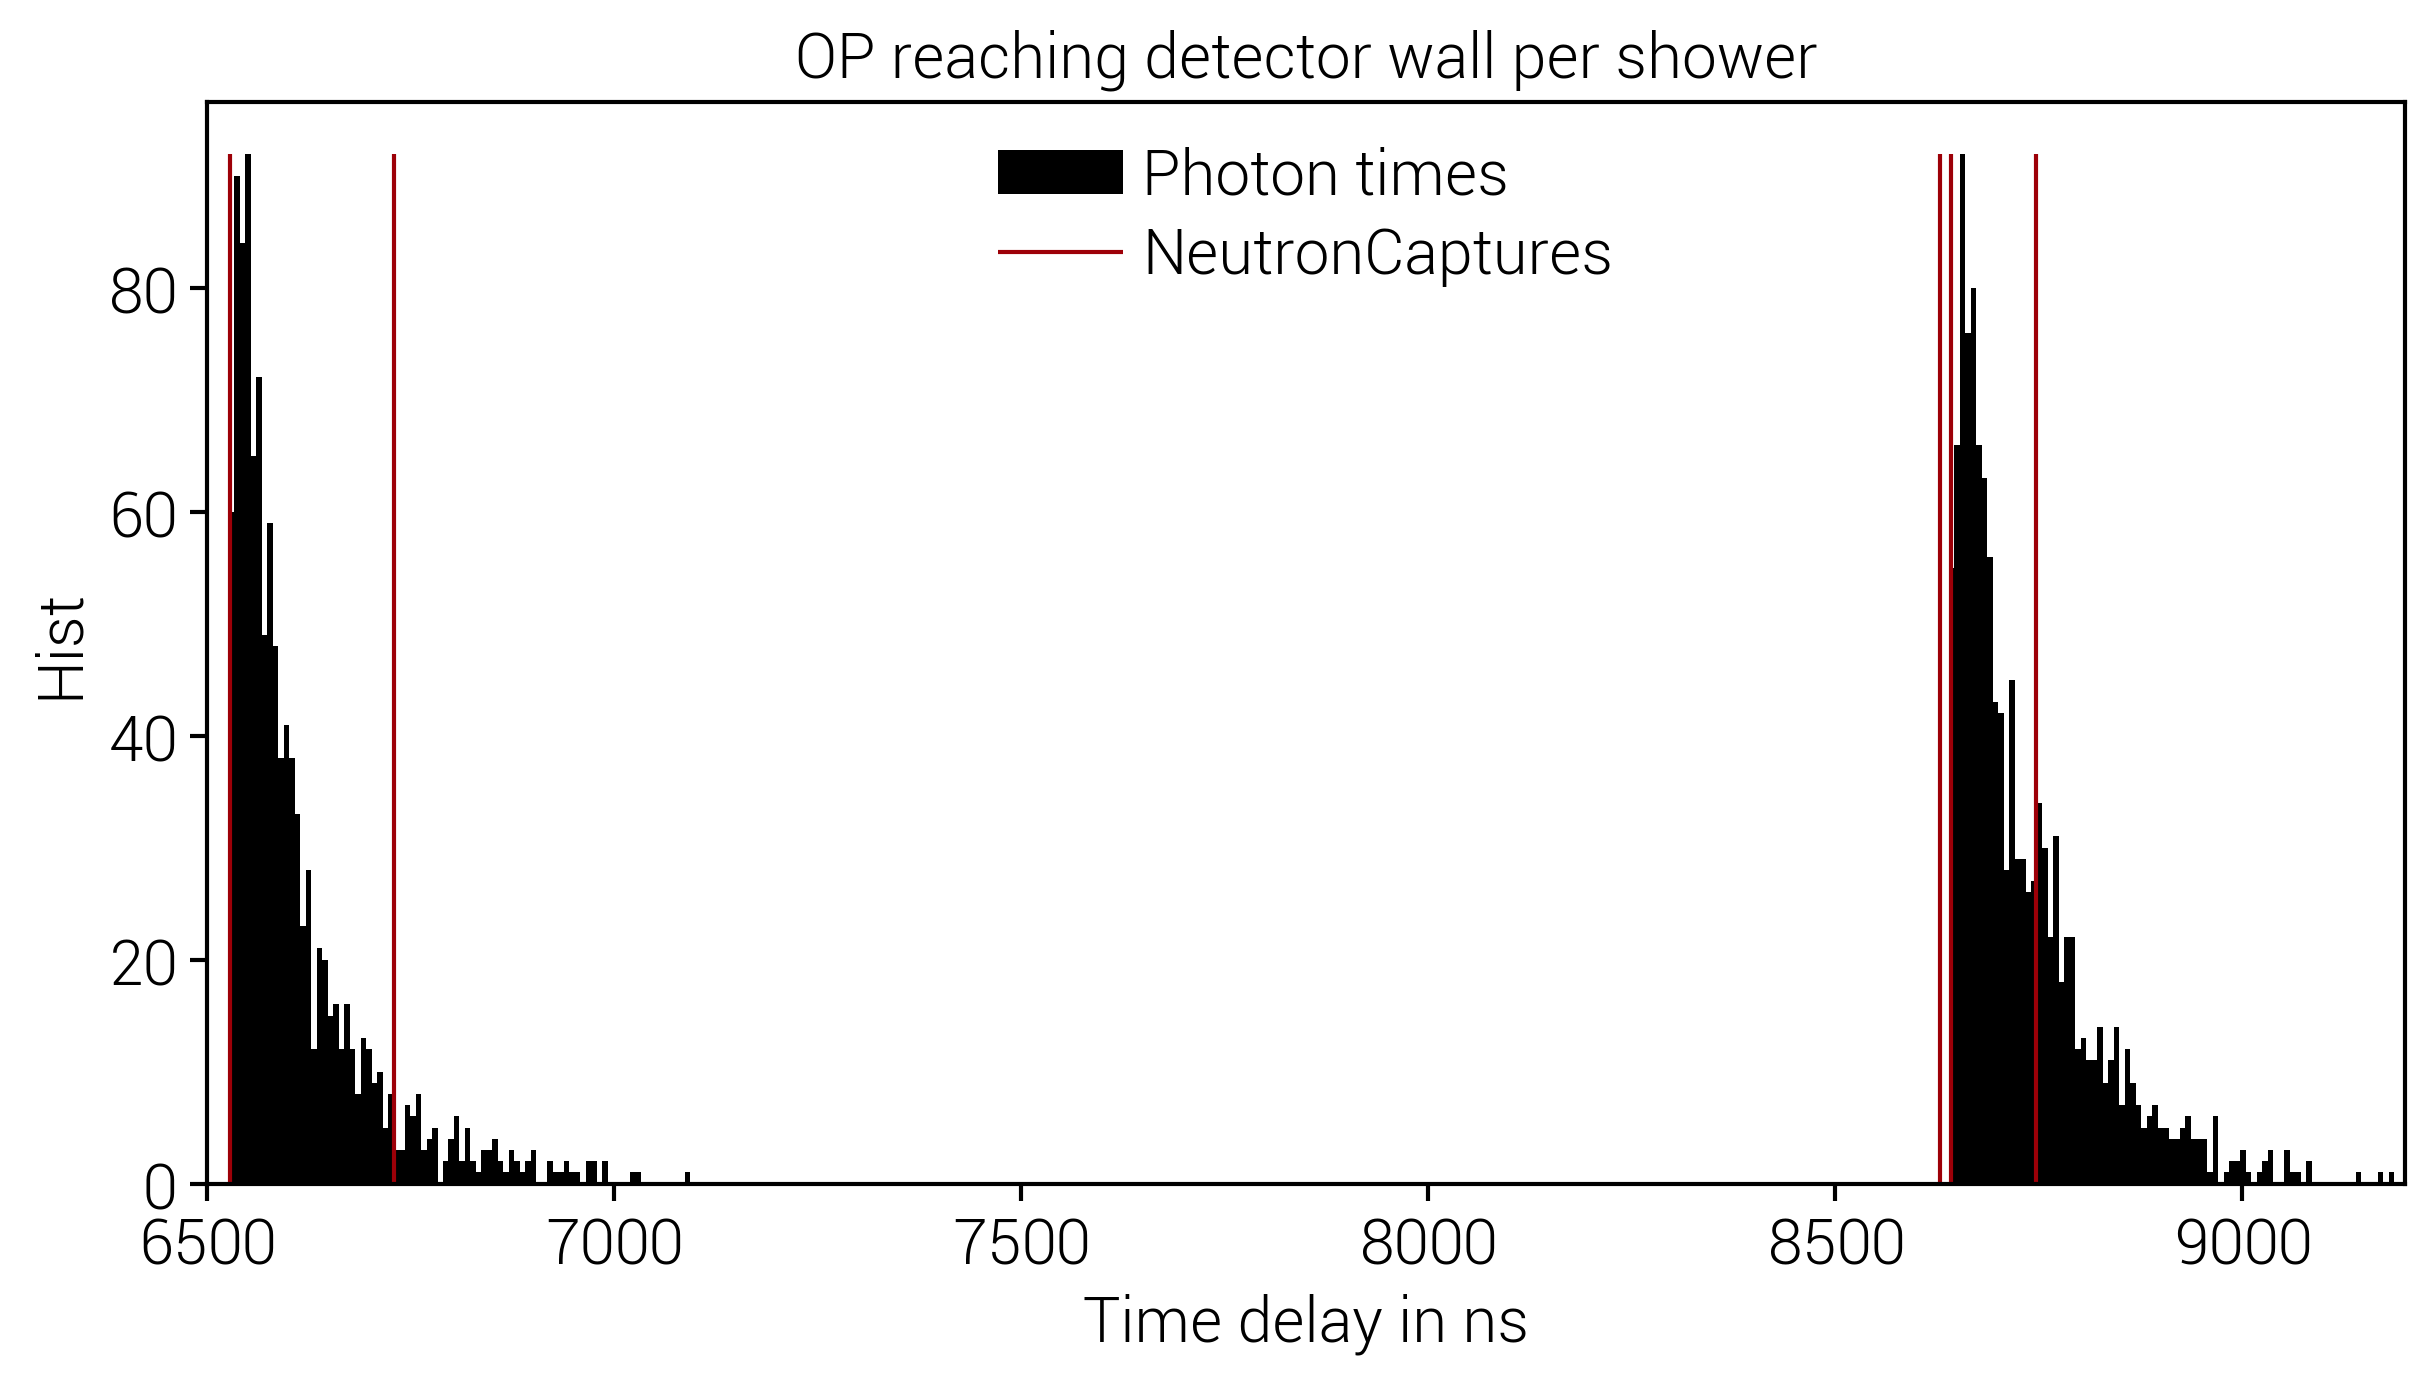

In [ ]:
ShowerNumber = 5
Neutrontimes = NeutronCaptureTimeDelay[no == ShowerNumber]


fig, ax1 = plt.subplots()
lowerbound= 6.5e3
upperbound = 9.2e3
n, bins, patches = ax1.hist(subPMMASetup2[ShowerNumber], bins = 400, range = (lowerbound, upperbound), label= "Photon times")

ax1.set_xlabel('Time delay in ns')
ax1.set_ylabel('Hist')
ax1.set_title('OP reaching detector wall per shower')
#ax1.set_xscale('log')
#ax1.set_ylim(bottom=0, top=1000)
ax1.vlines(Neutrontimes, ymin=0,ymax=np.max(n), color=lps.colors["darkred"], label = "NeutronCaptures")
ax1.set_xlim(xmin=lowerbound, xmax=upperbound)
#ax1.hlines(y=120,xmin=lowerbound, xmax=upperbound, color = lps.colors["red"], label="Current cut (roughly)")
ax1.legend(loc= "upper center")
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/Baseline/EventBaseResolution.png")
plt.show()

Histogramm NeutronCaptureDelay

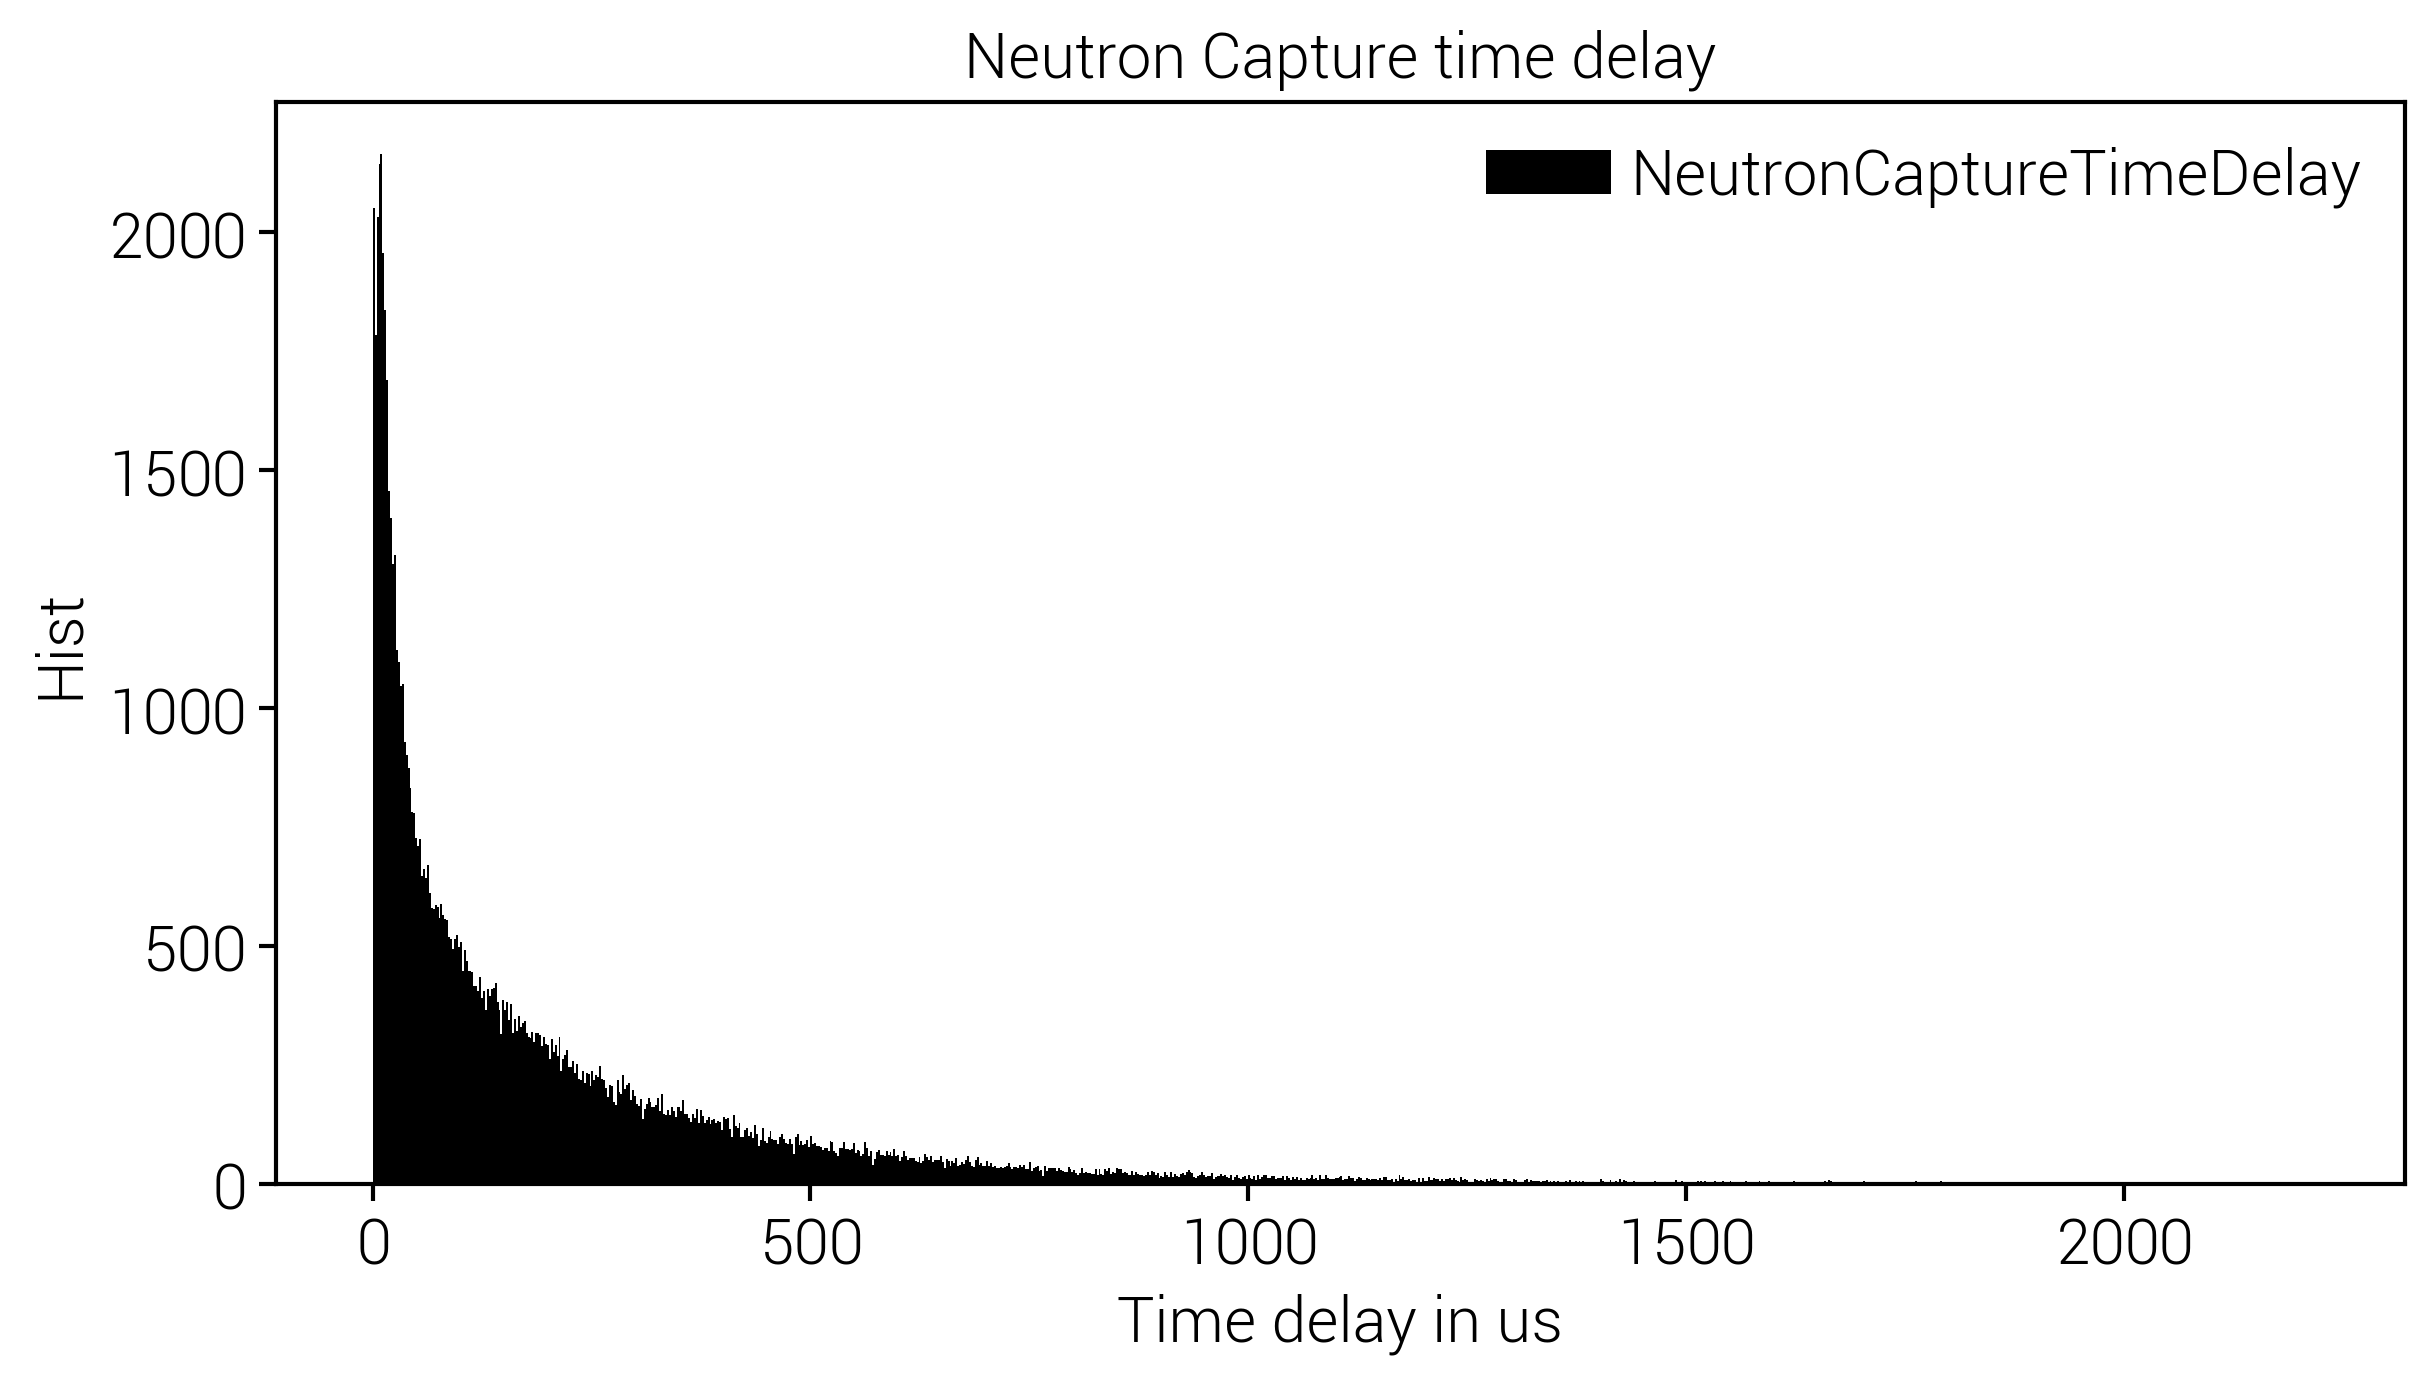

In [ ]:

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(NeutronCaptureTimeDelay / 1e3, bins = 1000, label= "NeutronCaptureTimeDelay")

ax1.set_xlabel('Time delay in us')
ax1.set_ylabel('Hist')
ax1.set_title('Neutron Capture time delay')
#ax1.set_xscale('log')
#ax1.set_ylim(bottom=0, top=1000)
#ax1.hlines(y=120,xmin=lowerbound, xmax=upperbound, color = lps.colors["red"], label="Current cut (roughly)")
ax1.legend(loc= "upper right")
#ax1.grid()
#plt.savefig("/home/eric/sim/WWLegend/Plots/Scintillator/EventScintResolution.png")
plt.show()

Calculate the % of neutrons captured within 200ns of each other

In [ ]:
ShowerNumbers, counts = np.unique(no, return_counts=True)


totalzähler = 0
totalnenner = 0

# Define the time window
time_window = 200  # nanoseconds
ShowerNumbers = ShowerNumbers[counts < 50]
for j in ShowerNumbers:
    Neutrontimes = NeutronCaptureTimeDelay[(no == j) & (identifierPMMA != 4)]
    # Initialize a boolean array to keep track of capture times that are within 200ns of any other capture
    within_200ns = np.zeros(len(Neutrontimes), dtype=bool)

    # Iterate through each capture time and check the condition
    for i in range(len(Neutrontimes)):
        # Check if there are any other capture times within 200ns of the current capture time
        is_within = np.abs(Neutrontimes - Neutrontimes[i]) <= time_window
        is_within[i] = False  # Ignore self comparison
        if np.any(is_within):
            within_200ns[i] = True
    totalzähler = totalzähler + np.sum(within_200ns)
    totalnenner = totalnenner + len(Neutrontimes)

# Calculate the percentage
percentage_within_200ns = totalzähler / totalnenner * 100

print(percentage_within_200ns)

ValueError: operands could not be broadcast together with shapes (93505,) (209,) 

Individual Shower

In [ ]:

ShowerNumber = 15
Neutrontimes = NeutronCaptureTimeDelay[(no == ShowerNumber) & (identifierPMMA != 4)]

# Define the time window
time_window = 200  # nanoseconds

# Initialize a boolean array to keep track of capture times that are within 200ns of any other capture
within_200ns = np.zeros(len(Neutrontimes), dtype=bool)

# Iterate through each capture time and check the condition
for i in range(len(Neutrontimes)):
    # Check if there are any other capture times within 200ns of the current capture time
    is_within = np.abs(Neutrontimes - Neutrontimes[i]) <= time_window
    is_within[i] = False  # Ignore self comparison
    if np.any(is_within):
        within_200ns[i] = True

# Calculate the percentage
percentage_within_200ns = np.sum(within_200ns) / len(Neutrontimes) * 100

print(percentage_within_200ns)

66.75675675675676
